In [2]:
import networkx as nx 
import matplotlib.pyplot as plt 
import matplotlib.cm as mplcm
import matplotlib
from matplotlib.gridspec import GridSpec
import numpy as np 
from scipy.stats import linregress
from mpmath import zeta
import math
import json
import subprocess
import pickle
from itertools import combinations, product
import os

In [3]:
def generate_colors(k, p):
    cm = plt.get_cmap('gist_rainbow')
    cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=p*(k-1))
    scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

    c = []
    for i in range(k):
        c.append(matplotlib.colors.to_hex(scalarMap.to_rgba(p*i)))
    return c

In [4]:
def load_graph_from_file(file_path: str):
    with open(file_path, 'r') as f:
        data = json.load(f)

    G = nx.Graph()

    for node in data['nodes']:
        if 'id' in node and 'color' in node:
            G.add_node(node['id'], color=node['color'])
        elif 'id' in node:
            G.add_node(node['id'])

    for edge in data['edges']:
        if 'source' in edge and 'target' in edge and 'color' in edge:
            G.add_edge(edge['source'], edge['target'], color=edge['color'])
        elif 'source' in edge and 'target' in edge and 'metrics' in edge:
            G.add_edge(edge['source'], edge['target'], metrics={'k33': float(edge['metrics']['k33']), 'k5': float(edge['metrics']['k5'])})
        elif 'source' in edge and 'target' in edge:
            G.add_edge(edge['source'], edge['target'])

    return G

def save_graph_to_file(G, file_path: str):
    data = {
        'nodes': [],
        'edges': []
    }

    for node in G.nodes(data=True):
        data['nodes'].append({'id': node[0]})

    for edge in G.edges(data=True):
        data['edges'].append({'source': edge[0], 'target': edge[1]})

    with open(file_path, 'w') as f:
        json.dump(data, f)

In [5]:
EMBEDDING_COLORS = [
    '#1f77b4.txt',
    '#ff7f0e.txt',
    '#2ca02c.txt',
    '#d62728.txt',
    '#9467bd.txt',
    '#8c564b.txt',
    '#e377c2.txt',
    '#7f7f7f.txt',
    '#bcbd22.txt',
    '#17becf.txt'
]

def generate_graph(initial_nodes: int, final_nodes: int, edges_per_node: int):
    filename = 'graph.json'
    subprocess.run(['./implementation/graphs', 'G', str(initial_nodes), str(edges_per_node), str(final_nodes), filename])
    graph = load_graph_from_file(filename)
    
    os.remove(filename)
    
    return graph

def generate_graph_with_metric(initial_nodes: int, final_nodes: int, edges_per_node: int):
    filename = 'graph.json'
    subprocess.run(['./implementation/graphs', 'M', str(initial_nodes), str(edges_per_node), str(final_nodes), filename])
    graph = load_graph_from_file(filename)
    
    os.remove(filename)
    
    return graph

def generate_graph_with_embeddings(initial_nodes: int, final_nodes: int, edges_per_node: int, embeddings_number: int, output_dir: str):
    filename = 'graph.json'
    subprocess.run(['./implementation/graphs', 'C', str(initial_nodes), str(edges_per_node), str(final_nodes), str(embeddings_number), output_dir])

    graph = load_graph_from_file(f'{output_dir}/{filename}')
    embeddings = [load_graph_from_file(f'{output_dir}/embedding_{embedding_color}') for embedding_color in EMBEDDING_COLORS[:embeddings_number]]

    os.remove(f'{output_dir}/{filename}')

    times_x = []
    times_total_y = []
    times_metric_y = []
    times_merge_y = []
    with open(f'{output_dir}/times.txt', 'r') as f:
        for line in f.readlines():
            x, total_time, metric_time, merge_time = line.split()
            times_x.append(float(x))
            times_total_y.append(float(total_time))
            times_metric_y.append(float(metric_time))
            times_merge_y.append(float(merge_time))

    metrics = []
    for embedding_color in EMBEDDING_COLORS[:embeddings_number]:
        metric = [[[0,0] for _ in range(final_nodes)] for _ in range(final_nodes)]
        with open(f'{output_dir}/metrics_{embedding_color}', 'r') as f:
            metric_lines = [line.split('\n') for line in f.readlines()[1:]]
            metric_values = [line[0].replace(')', '').split('(')[1:] for line in metric_lines]
            for i in range(final_nodes):
                for j in range(final_nodes):
                    metric_k33, metric_k5 = metric_values[i][j].split(',')
                    metric[i][j] = [float(metric_k33.strip()), float(metric_k5.strip())]
        metrics.append(metric)

    return graph, embeddings, (times_x, times_total_y, times_metric_y, times_merge_y), metrics

def set_metric_for_graph(graph):
    in_filename = 'in-graph.json'
    out_filename = 'out-graph.json'

    save_graph_to_file(graph, in_filename)

    subprocess.run(['./implementation/graphs', 'S', in_filename, out_filename])
    graph = load_graph_from_file(out_filename)

    os.remove(in_filename)
    os.remove(out_filename)

    return graph

In [6]:
def draw_graph(G: nx.Graph, only_properties = False, name: str = 'BA Graph', pos: dict = None, hist_max_deg: int = None):
    fig = plt.figure(figsize=(14, 7))
    gs = GridSpec(2, 3, figure=fig)
    ax0 = fig.add_subplot(gs[:, :2])
    ax1 = fig.add_subplot(gs[0, 2])
    ax2 = fig.add_subplot(gs[1, 2])

    if not only_properties:
        node_colors = [G.nodes[node]['color'] if 'color' in G.nodes[node] else 'black' for node in G.nodes()]
        edge_colors = [G.edges[edge]['color'] if 'color' in G.edges[edge] else 'black' for edge in G.edges()]
        if pos == None:
            pos = nx.kamada_kawai_layout(G)
        nx.draw(G, pos, ax=ax0, node_color=node_colors, node_size=50, edge_color=edge_colors, with_labels=False)
        ax0.set_title(name)

    degrees = [G.degree(n) for n in G.nodes()]

    if hist_max_deg == None:
        hist_max_deg = max(degrees) + 2
    ax1.hist(degrees, bins=range(1, hist_max_deg), align='left', color='deepskyblue')
    ax1.set_title("Degree Histogram")
    ax1.set_xlabel("Degree")
    ax1.set_ylabel("Frequency")

    degree_counts = np.bincount(degrees)[1:]
    cdf = np.cumsum(degree_counts[::-1])[::-1]
    cdf = cdf / cdf[0]

    nonzero_indices = degree_counts > 0
    k = np.arange(1, len(degree_counts) + 1)[nonzero_indices]
    cdf = cdf[nonzero_indices]

    log_k = np.log(k)
    log_cdf = np.log(cdf)

    slope, intercept, r_value, p_value, std_err = linregress(log_k, log_cdf)
    lambda_estimate = -(slope - 1)

    ax2.scatter(k, cdf, s=10, alpha=0.75, label='Degree CDF', color='deepskyblue')
    ax2.plot(k, np.exp(intercept) * k ** slope, label=f'Power-law fit: $\\lambda = {lambda_estimate:.3f}$', color='deeppink')

    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('Degree')
    ax2.set_ylabel('CDF')
    ax2.set_title('Degree Distribution and Power-law Fit')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    return pos, hist_max_deg

In [7]:
def visualise_metric(ax, metric, with_labels, title, edge_cmap, edge_min_normalizer, edge_max_normalizer, vertex_cmap, vertex_min_normalizer, vertex_max_normalizer, pos=None, edge_threshold=None, label_threshold=None):
    if edge_threshold == None:
        edge_threshold = edge_min_normalizer
    if label_threshold == None:
        label_threshold = edge_min_normalizer

    n = len(metric)

    G = nx.Graph()
    for i in range(n):
        G.add_node(i)

    for i in range(n):
        for j in range(i+1, n):
            if metric[i][j] >= edge_threshold and metric[i][j] != 0:
                G.add_edge(i, j, weight=metric[i][j])

    edge_weights = nx.get_edge_attributes(G, 'weight')
    edge_colors = [edge_weights[edge] for edge in G.edges()]
    node_colors = [metric[i][i] for i in G.nodes()]

    if pos == None:
        pos = nx.kamada_kawai_layout(G)

    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=50, node_color=node_colors, cmap=vertex_cmap, vmin=vertex_min_normalizer, vmax=vertex_max_normalizer)
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color=edge_colors, edge_cmap=edge_cmap, edge_vmin=edge_min_normalizer, edge_vmax=edge_max_normalizer)

    if with_labels:
        nx.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=edge_weights, font_color='black', font_size=6)

    ax.set_title(title)


def visualise_metrics(metric, metric_num, with_labels, edge_cmap, edge_min_normalizer, edge_max_normalizer, vertex_cmap, vertex_min_normalizer, vertex_max_normalizer, pos=None, edge_threshold=None, label_threshold=None):
    fig = plt.figure(figsize=(14, 7))
    gs = GridSpec(1, 2, figure=fig)
    ax_k33 = fig.add_subplot(gs[0, 0])
    ax_k5 = fig.add_subplot(gs[0, 1])

    k33_metric = [[item[0] for item in row] for row in metric]
    k5_metric = [[item[1] for item in row] for row in metric]

    visualise_metric(ax_k33, k33_metric, with_labels, f"Metric K33 for {EMBEDDING_COLORS[metric_num].replace('.txt', '')}", edge_cmap, edge_min_normalizer, edge_max_normalizer, vertex_cmap, vertex_min_normalizer, vertex_max_normalizer, pos, edge_threshold, label_threshold)
    visualise_metric(ax_k5, k5_metric, with_labels, f"Metric K5 for {EMBEDDING_COLORS[metric_num].replace('.txt', '')}", edge_cmap, edge_min_normalizer, edge_max_normalizer, vertex_cmap, vertex_min_normalizer, vertex_max_normalizer, pos, edge_threshold, label_threshold)

    plt.tight_layout()
    plt.show()

def visualise_metric_on_graph(ax, graph, metric, with_labels, title, edge_cmap, edge_min_normalizer, edge_max_normalizer, vertex_cmap, vertex_min_normalizer, vertex_max_normalizer, pos=None):
    edge_weights = {(edge[0], edge[1]): metric[edge[0]][edge[1]] for edge in graph.edges()}
    edge_colors = [metric[edge[0]][edge[1]] for edge in graph.edges()]
    node_colors = [metric[i][i] for i in graph.nodes()]

    if pos == None:
        pos = nx.kamada_kawai_layout(graph)

    nx.draw_networkx_nodes(graph, pos, ax=ax, node_size=50, node_color=node_colors, cmap=vertex_cmap, vmin=vertex_min_normalizer, vmax=vertex_max_normalizer)
    nx.draw_networkx_edges(graph, pos, ax=ax, edge_color=edge_colors, edge_cmap=edge_cmap, edge_vmin=edge_min_normalizer, edge_vmax=edge_max_normalizer)

    if with_labels:
        nx.draw_networkx_edge_labels(graph, pos, ax=ax, edge_labels=edge_weights, font_color='black', font_size=6)


    ax.set_title(title)

def visualise_metrics_on_graph(graph, metric, with_labels, title, edge_cmap, edge_min_normalizer, edge_max_normalizer, vertex_cmap, vertex_min_normalizer, vertex_max_normalizer, pos=None):
    fig = plt.figure(figsize=(14, 7))
    gs = GridSpec(1, 2, figure=fig)
    ax_k33 = fig.add_subplot(gs[0, 0])
    ax_k5 = fig.add_subplot(gs[0, 1])

    k33_metric = [[item[0] for item in row] for row in metric]
    k5_metric = [[item[1] for item in row] for row in metric]

    visualise_metric_on_graph(ax_k33, graph, k33_metric, with_labels, title, edge_cmap, edge_min_normalizer, edge_max_normalizer, vertex_cmap, vertex_min_normalizer, vertex_max_normalizer, pos)
    visualise_metric_on_graph(ax_k5, graph, k5_metric, with_labels, title, edge_cmap, edge_min_normalizer, edge_max_normalizer, vertex_cmap, vertex_min_normalizer, vertex_max_normalizer, pos)

    plt.tight_layout()
    plt.show()

In [8]:
def visualise_times(times):
    fig = plt.figure(figsize=(14, 7))
    gs = GridSpec(1, 3, figure=fig)
    ax_total = fig.add_subplot(gs[0, 0])
    ax_metric = fig.add_subplot(gs[0, 1])
    ax_merge = fig.add_subplot(gs[0, 2])

    times_x, times_total_y, times_metric_y, times_merge_y = times

    ax_total.plot(times_x, times_total_y, label='Total time', color='deepskyblue')
    ax_total.set_title('Total time')
    ax_total.set_xlabel('Number of nodes')
    ax_total.set_ylabel('Time (s)')

    ax_metric.plot(times_x, times_metric_y, label='Metric time', color='deepskyblue')
    ax_metric.set_title('Metric time')
    ax_metric.set_xlabel('Number of nodes')
    ax_metric.set_ylabel('Time (s)')

    ax_merge.plot(times_x, times_merge_y, label='Merge time', color='deepskyblue')
    ax_merge.set_title('Merge time')
    ax_merge.set_xlabel('Number of nodes')
    ax_merge.set_ylabel('Time (s)')

    plt.tight_layout()
    plt.show()

In [9]:
def get_crossings(graph):
    counter = 0
    while True:
        is_planar, counterexample = nx.check_planarity(graph, True)
        if is_planar:
            return counter
        else:
            edge_to_remove = list(counterexample.edges())[0]
            graph.remove_edge(*edge_to_remove)
            counter += 1
        
    # if nx.is_planar(graph):
    #     return 0
    
    # for k in range(1, len(graph.nodes()) - 2):
    #     for edges in combinations(graph.edges(), k):
    #         graph_copy = graph.copy()
    #         graph_copy.remove_edges_from(edges)
    #         if nx.is_planar(graph_copy):
    #             return k
            

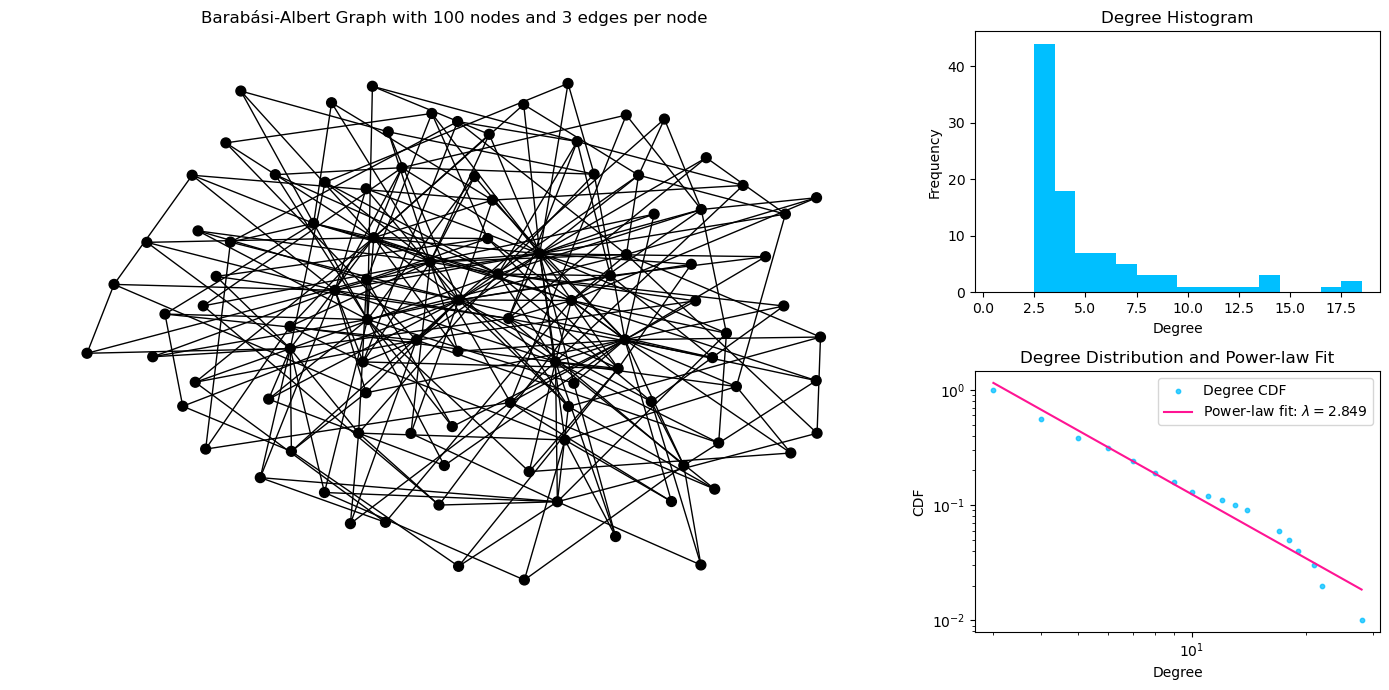

In [10]:
INITIAL_NODES = 5
FINAL_NODES = 100
EDGES_PER_NODE = 3

graph = generate_graph(INITIAL_NODES, FINAL_NODES, EDGES_PER_NODE)

planar_info = 'is planar' if nx.is_planar(graph) else 'is not planar'
pos, hist_max_deg = draw_graph(graph, name=f'Barabási-Albert Graph with {FINAL_NODES} nodes and {EDGES_PER_NODE} edges per node', hist_max_deg=20)

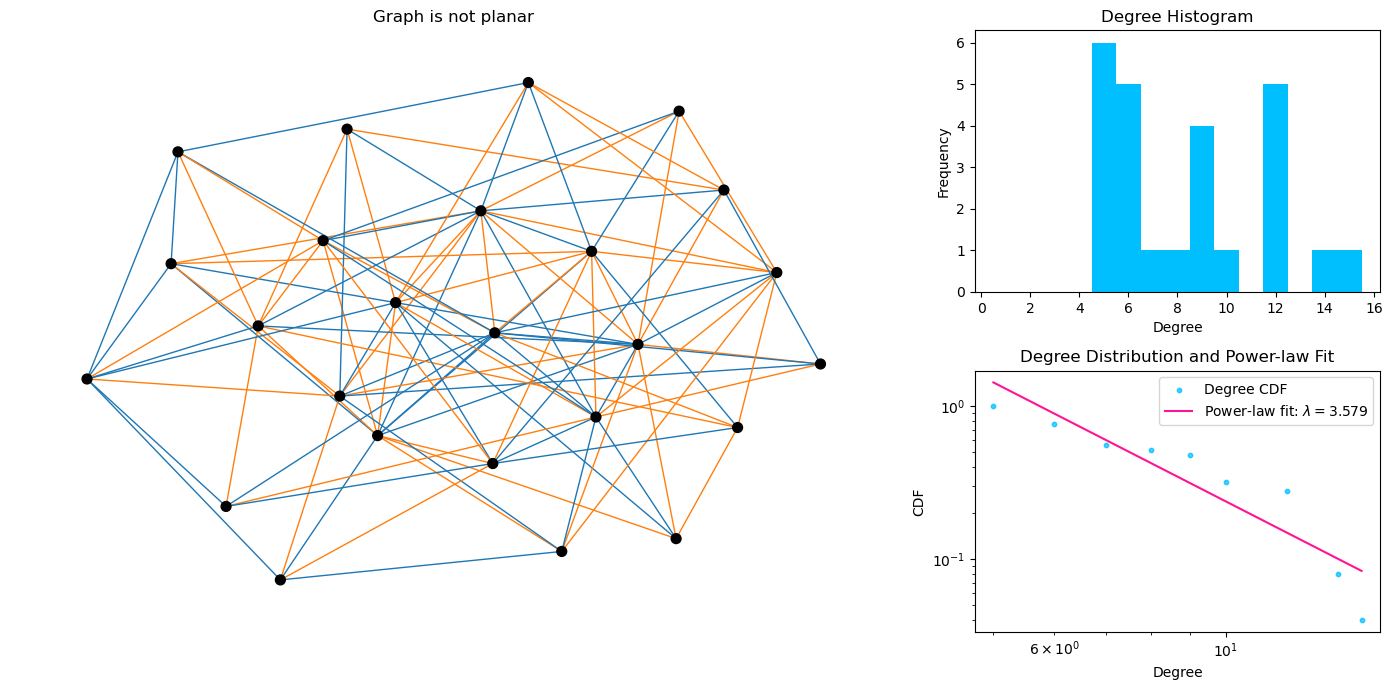

Crossings: 11
Crossings: 11


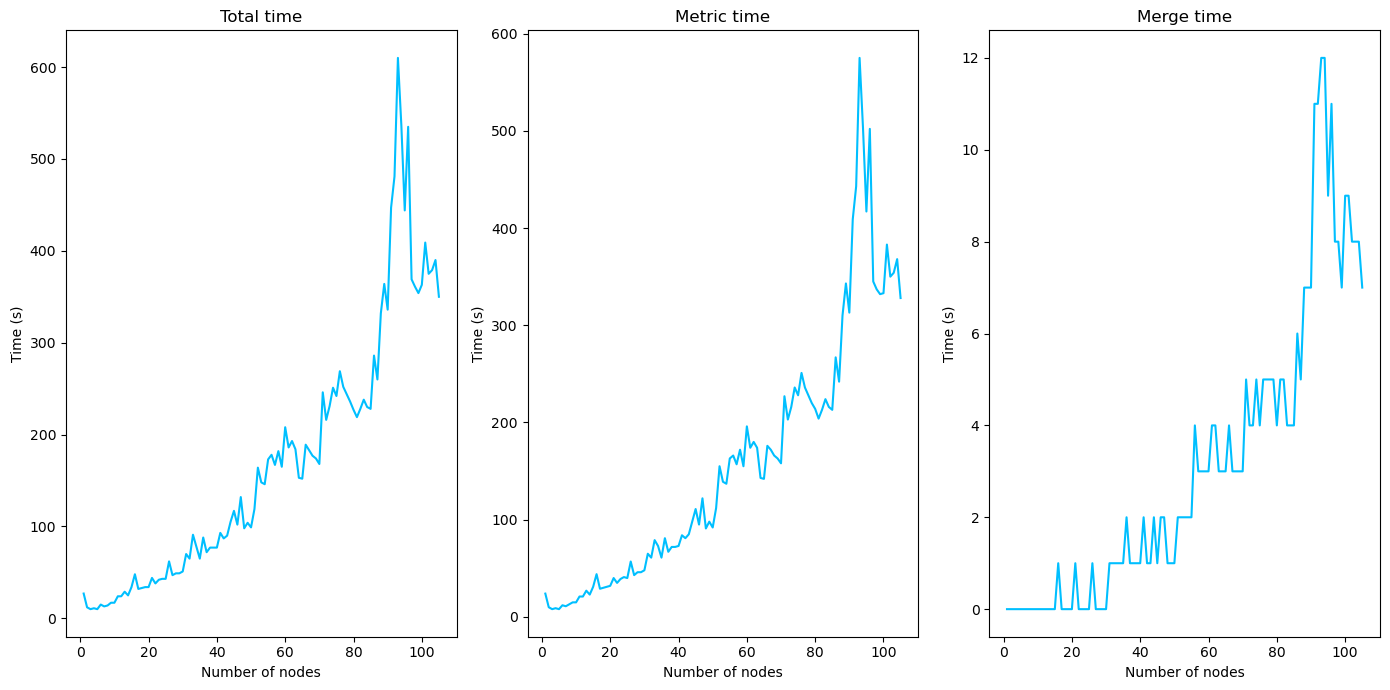

In [11]:
INITIAL_NODES = 5
FINAL_NODES = 25
EDGES_PER_NODE = 5
EMBEDDING_NUMBERS = 2

DRAW_THRESHOLD = None

ba, embbs, times, metrics = generate_graph_with_embeddings(INITIAL_NODES, FINAL_NODES, EDGES_PER_NODE, EMBEDDING_NUMBERS, 'out')

all_edge_metric_values = []
all_vertex_metric_values = []
for metric in metrics:
    for i in range(FINAL_NODES):
        for j in range(FINAL_NODES):
            if i != j:
                all_edge_metric_values.append(metric[i][j][0])
                all_edge_metric_values.append(metric[i][j][1])
            else:
                all_vertex_metric_values.append(metric[i][j][0])
                all_vertex_metric_values.append(metric[i][j][1])

sorted_edge_metric_values = sorted(all_edge_metric_values)
sorted_vertex_metric_values = sorted(all_vertex_metric_values)

min_edge_metric_value = sorted_edge_metric_values[0]
max_edge_metric_value = sorted_edge_metric_values[-1]

min_vertex_metric_value = sorted_vertex_metric_values[0]
max_vertex_metric_value = sorted_vertex_metric_values[-1]

planar_info = 'is planar' if nx.is_planar(ba) else 'is not planar'
pos, hist_max_deg = draw_graph(ba, False, 'Graph ' + planar_info, None, None)

for index, embb in enumerate(embbs):
    is_planar, counterexample = nx.check_planarity(embb, True)
    planar_info = ' is planar'if is_planar else ' is not planar'
    print('Crossings:', get_crossings(embb))
    # draw_graph(embb, False, 'Embedding ' + EMBEDDING_COLORS[index].replace('.txt', '') + planar_info, pos, hist_max_deg)
    # visualise_metrics(metrics[index], index, True, plt.cm.Purples, min_edge_metric_value, max_edge_metric_value, plt.cm.Purples, min_vertex_metric_value, max_vertex_metric_value, pos, DRAW_THRESHOLD, DRAW_THRESHOLD)

    # if not is_planar:
        # draw_graph(counterexample, False, 'Counterexample for ' + EMBEDDING_COLORS[index].replace('.txt', ''), pos, hist_max_deg)
        # visualise_metrics_on_graph(counterexample, metrics[index], True, f'Counterexample for {EMBEDDING_COLORS[index].replace(".txt", "")}', plt.cm.Purples, min_edge_metric_value, max_edge_metric_value, plt.cm.Purples, min_vertex_metric_value, max_vertex_metric_value, pos)

visualise_times(times)

# print('Metrics:')
# for index, metric in enumerate(metrics):
#     print(f'Embedding {index + 1}:')
#     for i in range(FINAL_NODES):
#         for j in range(FINAL_NODES):
#             print(f'({metric[i][j][0]:.3f}, {metric[i][j][1]:.3f})', end=' ')
#         print()
#     print()

# for emmb in embbs:
#     set_metric_for_graph(emmb)

In [12]:
def mst_embeddings_without_weights(G, complement=False):
    msts = []
    while G.number_of_edges() > 0:
        if nx.is_planar(G):
            msts.append(G)
            break
        
        mst = nx.minimum_spanning_tree(G)
        for edge in mst.edges():
            G.remove_edge(*edge)
    
        if complement:
            for edge in G.edges():
                mst.add_edge(*edge)
                if 'metrics' in G.edges[edge]:
                    mst.edges[edge]['metrics'] = G.edges[edge]['metrics']
                if nx.is_planar(mst):
                    G.remove_edge(*edge)
                else:
                    mst.remove_edge(*edge)

        msts.append(mst)

    return msts

def mst_embeddings_with_weights(G, complement=False):
    msts = []
    while G.number_of_edges() > 0:
        G = set_metric_for_graph(G)
        for edge in G.edges():
            G.edges[edge]['weight'] = (499 * G.edges[edge]['metrics']['k33'] + 1 * G.edges[edge]['metrics']['k5']) / 500
            
        mst = nx.minimum_spanning_tree(G, weight='weight')
        for edge in mst.edges():
            G.remove_edge(*edge)
    
        if complement:
            for edge in sorted(G.edges(), key=lambda edge: G.edges[edge]['weight'], reverse=False):
                mst.add_edge(*edge)
                if 'metrics' in G.edges[edge]:
                    mst.edges[edge]['metrics'] = G.edges[edge]['metrics']
                if nx.is_planar(mst):
                    mst
                    G.remove_edge(*edge)
                else:
                    mst.remove_edge(*edge)

        msts.append(mst)
    
    return msts

In [13]:
def cactus_embeddings_without_weights(G, complement=False):
    def check_triangle_in_different_components(components, triangle):
        return len({comp_id for node in triangle for comp_id, comp in enumerate(components) if node in comp}) == 3

    def check_edge_in_different_components(components, edge):
        u,v = edge
        u_comp = next(comp_id for comp_id, comp in enumerate(components) if u in comp)
        v_comp = next(comp_id for comp_id, comp in enumerate(components) if v in comp)
        return u_comp != v_comp
    
    def find_cactus_structure(G):
        E1 = nx.Graph()
        for node in G.nodes():
            E1.add_node(node)

        while True:
            components = list(nx.connected_components(E1))
            changed = False
            for triangle in [triangle for triangle in nx.enumerate_all_cliques(G) if len(triangle) == 3]:
                if check_triangle_in_different_components(components, triangle):
                    E1.add_edges_from([(triangle[i], triangle[j]) for i in range(3) for j in range(i+1, 3)])
                    components = list(nx.connected_components(E1))
                    changed = True

            if not changed:
                break
            
        
        while True:
            components = list(nx.connected_components(E1))
            changed = False
            for edge in G.edges():
                if check_edge_in_different_components(components, edge):
                    E1.add_edge(*edge)
                    components = list(nx.connected_components(E1))
                    changed = True

            if not changed:
                break
        
        return E1
    
    cactuses = []
    while G.number_of_edges() > 0: 
        cactus = find_cactus_structure(G)
        for edge in cactus.edges():
            G.remove_edge(*edge)

        if complement:
            for edge in G.edges():
                cactus.add_edge(*edge)
                if nx.is_planar(cactus):
                    G.remove_edge(*edge)
                else:
                    cactus.remove_edge(*edge)
    
        cactuses.append(cactus)

    return cactuses

def cactus_embeddings_with_weights(G, complement=False):
    def check_triangle_in_different_components(components, triangle):
        return len({comp_id for node in triangle for comp_id, comp in enumerate(components) if node in comp}) == 3

    def check_edge_in_different_components(components, edge):
        u,v = edge
        u_comp = next(comp_id for comp_id, comp in enumerate(components) if u in comp)
        v_comp = next(comp_id for comp_id, comp in enumerate(components) if v in comp)
        return u_comp != v_comp
    
    def triangle_key(triangle, G):
        res = -1
        for node in triangle:
            res *= G.degree(node)
        return res
        # return product([G.degree(node) for node in triangle])
    
    def find_cactus_structure(G):
        E1 = nx.Graph()
        for node in G.nodes():
            E1.add_node(node)

        while True:
            components = list(nx.connected_components(E1))
            changed = False
            triangles = [triangle for triangle in nx.enumerate_all_cliques(G) if len(triangle) == 3]
            sorted(triangles, key=lambda triangle: triangle_key(triangle, G), reverse=False)
            for triangle in triangles:
                if check_triangle_in_different_components(components, triangle):
                    E1.add_edges_from([(triangle[i], triangle[j]) for i in range(3) for j in range(i+1, 3)])
                    components = list(nx.connected_components(E1))
                    changed = True

            if not changed:
                break
            
        
        while True:
            components = list(nx.connected_components(E1))
            changed = False
            for edge in sorted(G.edges(), key=lambda edge: G.edges[edge]['weight'], reverse=False):
                if check_edge_in_different_components(components, edge):
                    E1.add_edge(*edge)
                    components = list(nx.connected_components(E1))
                    changed = True

            if not changed:
                break
        
        return E1
    
    cactuses = []
    while G.number_of_edges() > 0: 
        G = set_metric_for_graph(G)
        for edge in G.edges():
            G.edges[edge]['weight'] = (499 * G.edges[edge]['metrics']['k33'] + 1 * G.edges[edge]['metrics']['k5']) / 500

        cactus = find_cactus_structure(G)
        for edge in cactus.edges():
            G.remove_edge(*edge)

        if complement:
            for edge in G.edges():
                cactus.add_edge(*edge)
                if 'metrics' in G.edges[edge]:
                    cactus.edges[edge]['metrics'] = G.edges[edge]['metrics']
                if nx.is_planar(cactus):
                    G.remove_edge(*edge)
                else:
                    cactus.remove_edge(*edge)
    
        cactuses.append(cactus)

    return cactuses

In [14]:
def mst_embeddings_without_weights_given_size(G, embbeddings_number):
    for edge in G.edges():
        G.edges[edge]['weight'] = (499 * G.edges[edge]['metrics']['k33'] + 1 * G.edges[edge]['metrics']['k5']) / 500
            
    msts = []
    for _ in range(embbeddings_number):
        mst = nx.minimum_spanning_tree(G)
        for edge in mst.edges():
            G.remove_edge(*edge)
        msts.append(mst)

    for edge in sorted(G.edges(), key=lambda edge: G.edges[edge]['weight'], reverse=False):
        for mst_index in range(embbeddings_number):
            msts[mst_index].add_edge(*edge)
            if 'metrics' in G.edges[edge]:
                msts[mst_index].edges[edge]['metrics'] = G.edges[edge]['metrics']
            
            if nx.is_planar(msts[mst_index]):
                G.remove_edge(*edge)
                break
            else:
                msts[mst_index].remove_edge(*edge)

            mst_index = (mst_index + 1) % embbeddings_number
            
    return msts, G.edges()

In [15]:
def get_ratio(graph: nx.Graph, edge_numbers: list[int]):
    max_edges_number = 3 * graph.number_of_nodes() - 6

    return [edge_number / max_edges_number for edge_number in edge_numbers]

In [16]:
INITIAL_NODES = 10
FINAL_NODES = 100
EDGES_PER_NODE = 3

graph = generate_graph_with_metric(INITIAL_NODES, FINAL_NODES, EDGES_PER_NODE)

msts = mst_embeddings_without_weights(graph.copy(), True)
msts2, remaining_edges = mst_embeddings_without_weights_given_size(graph.copy(), 2)

print([len(mst.edges()) for mst in msts])
print([len(mst.edges()) for mst in msts2])
print(len(remaining_edges))

print(get_ratio(graph, [len(mst.edges()) for mst in msts]))
print(get_ratio(graph, [len(mst.edges()) for mst in msts2]))

[167, 107, 6]
[148, 115]
17
[0.5680272108843537, 0.36394557823129253, 0.02040816326530612]
[0.5034013605442177, 0.391156462585034]


In [17]:
INITIAL_NODES = 5
FINAL_NODES = 50
EDGES_PER_NODE = 5

graph = generate_graph_with_metric(INITIAL_NODES, FINAL_NODES, EDGES_PER_NODE)

mst_method = mst_embeddings_without_weights(graph.copy(), True)
mst_with_weights_method = mst_embeddings_with_weights(graph.copy(), True)

cactus_method = cactus_embeddings_without_weights(graph.copy(), True)
cactus_with_weights_method = cactus_embeddings_with_weights(graph.copy(), True)

print([len(m.edges()) for m in mst_method])
print([len(m.edges()) for m in mst_with_weights_method])

print([len(m.edges()) for m in cactus_method])
print([len(m.edges()) for m in cactus_with_weights_method])

print(get_ratio(graph, [len(m.edges()) for m in mst_method]))
print(get_ratio(graph, [len(m.edges()) for m in mst_with_weights_method]))

print(get_ratio(graph, [len(m.edges()) for m in cactus_method]))
print(get_ratio(graph, [len(m.edges()) for m in cactus_with_weights_method]))

[106, 82, 42]
[106, 81, 43]
[106, 84, 40]
[106, 80, 43, 1]
[0.7361111111111112, 0.5694444444444444, 0.2916666666666667]
[0.7361111111111112, 0.5625, 0.2986111111111111]
[0.7361111111111112, 0.5833333333333334, 0.2777777777777778]
[0.7361111111111112, 0.5555555555555556, 0.2986111111111111, 0.006944444444444444]


In [ ]:
INITIAL_NODES = 5
TRIES = 50

for m in [4, 5]:
    print(f'm = {m}')
    n_value = []
    mst_ratios = []
    cactus_ratios = []
    mst_with_weights_ratios = []
    cactus_with_weights_ratios = []
    for n in [30, 50, 70, 100]:
        print(f'n = {n}')
        n_value.append(n)
        mst_sum = 0
        cactus_sum = 0
        mst_with_weights_sum = 0
        cactus_with_weights_sum = 0
        
        for _ in range(TRIES):
            graph = generate_graph_with_metric(INITIAL_NODES, n, m)

            mst_method = mst_embeddings_without_weights(graph.copy(), True)
            cactus_method = cactus_embeddings_without_weights(graph.copy(), True)
            mst_with_weights_method = mst_embeddings_with_weights(graph.copy(), True)
            cactus_with_weights_method = cactus_embeddings_with_weights(graph.copy(), True)

            mst_sum += get_ratio(graph, [len(m.edges()) for m in mst_method])[0]
            cactus_sum += get_ratio(graph, [len(m.edges()) for m in cactus_method])[0]
            mst_with_weights_sum += get_ratio(graph, [len(m.edges()) for m in mst_with_weights_method])[0]
            cactus_with_weights_sum += get_ratio(graph, [len(m.edges()) for m in cactus_with_weights_method])[0]

        mst_ratios.append(mst_sum / TRIES)
        cactus_ratios.append(cactus_sum / TRIES)
        mst_with_weights_ratios.append(mst_with_weights_sum / TRIES)
        cactus_with_weights_ratios.append(cactus_with_weights_sum / TRIES)

    plt.plot(n_value, mst_ratios, label=f'MST without weights(avg={sum(mst_ratios) / len(mst_ratios):.3f})', color='blue')
    plt.plot(n_value, cactus_ratios, label=f'Cactus without weights(avg={sum(cactus_ratios) / len(cactus_ratios):.3f})', color='red')
    plt.plot(n_value, mst_with_weights_ratios, label=f'MST with weights(avg={sum(mst_with_weights_ratios) / len(mst_with_weights_ratios):.3f})', color='green')
    plt.plot(n_value, cactus_with_weights_ratios, label=f'Cactus with weights(avg={sum(cactus_with_weights_ratios) / len(cactus_with_weights_ratios):.3f})', color='purple')

    plt.xlabel('Number of nodes')
    plt.ylabel('Ratio')
    plt.title(f'Ratio of edges in the embedding to the maximum possible number of edges - m = {m}')
    plt.legend()
    plt.show()


In [ ]:
INITIAL_NODES = 5
TRIES = 10

for m in [3]:
    print(f'm = {m}')
    n_value = []
    mst_ratios = []
    mst_with_weights_ratios = []
    for n in [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:
        print(f'n = {n}')
        n_value.append(n)
        mst_sum = 0
        mst_with_weights_sum = 0
        
        for _ in range(TRIES):
            graph = generate_graph_with_metric(INITIAL_NODES, n, m)

            mst_method = mst_embeddings_without_weights(graph.copy(), True)
            mst_with_weights_method = mst_embeddings_with_weights(graph.copy(), True)

            mst_sum += mst_method[0].number_of_edges()
            mst_with_weights_sum += mst_with_weights_method[0].number_of_edges()

        mst_ratios.append(mst_sum / TRIES)
        mst_with_weights_ratios.append(mst_with_weights_sum / TRIES)

    plt.plot(n_value, mst_ratios, label=f'MST without weights(avg={sum(mst_ratios) / len(mst_ratios):.3f})', color='blue')
    plt.plot(n_value, mst_with_weights_ratios, label=f'MST with weights(avg={sum(mst_with_weights_ratios) / len(mst_with_weights_ratios):.3f})', color='green')

    plt.xlabel('Number of nodes')
    plt.ylabel('Ratio')
    plt.title(f'Ratio of edges in the embedding to the maximum possible number of edges - m = {m}')
    plt.legend()
    plt.show()

In [ ]:
pickle.dump(n_value, open('n_value3.pkl', 'wb'))
pickle.dump(mst_ratios, open('mst_ratios3.pkl', 'wb'))
pickle.dump(mst_with_weights_ratios, open('mst_with_weights_ratios3.pkl', 'wb'))

In [ ]:
n_values = pickle.load(open('n_value3.pkl', 'rb'))[:5]
mst_ratios = pickle.load(open('mst_ratios3.pkl', 'rb'))
mst_with_weights_ratios = pickle.load(open('mst_with_weights_ratios3.pkl', 'rb'))

# mst  = [m / (3*n - 6) for m, n in zip(mst_ratios, n_values)]
# mst_with_weights = [m / (3*n - 6) for m, n in zip(mst_with_weights_ratios, n_values)]

plt.plot(n_values, mst_ratios, label=f'MST without weights (avg={sum(mst_ratios) / len(mst_ratios):.3f})', color='blue')
plt.plot(n_values, mst_with_weights_ratios, label=f'MST with weights (avg={sum(mst_with_weights_ratios) / len(mst_with_weights_ratios):.3f})', color='green')
plt.legend()
plt.show()

m = 3
n = 250
Try 0
[366, 279, 85]
[368, 284, 78]
Try 1
[369, 285, 76]
[385, 280, 65]
Try 2
[373, 283, 74]
[393, 278, 59]
Try 3
[358, 285, 87]
[371, 278, 81]
Try 4
[375, 275, 80]
[383, 277, 70]
Try 5
[370, 283, 77]
[385, 285, 60]
Try 6
[359, 285, 86]
[370, 283, 77]
Try 7
[368, 282, 80]
[380, 284, 66]
Try 8
[361, 284, 85]
[379, 279, 72]
Try 9
[368, 287, 75]
[376, 277, 77]
n = 500
Try 0
[680, 560, 240]
[697, 553, 230]
Try 1
[702, 561, 217]
[710, 546, 224]
Try 2
[691, 566, 223]
[709, 546, 225]
Try 3
[678, 566, 236]
[683, 562, 235]
Try 4
[670, 566, 244]
[691, 549, 240]
Try 5
[687, 551, 242]
[701, 559, 220]
Try 6
[691, 556, 233]
[690, 560, 230]
Try 7
[693, 558, 229]
[709, 561, 210]
Try 8
[668, 560, 252]
[699, 563, 218]
Try 9
[687, 558, 235]
[674, 566, 240]
n = 750
Try 0
[997, 844, 389]
[1014, 830, 386]
Try 1
[1012, 818, 400]
[1022, 817, 391]
Try 2
[995, 824, 411]
[1020, 818, 392]
Try 3
[994, 832, 404]
[1006, 824, 400]
Try 4
[1009, 836, 385]
[1009, 820, 401]
Try 5
[987, 827, 416]
[1028, 826,

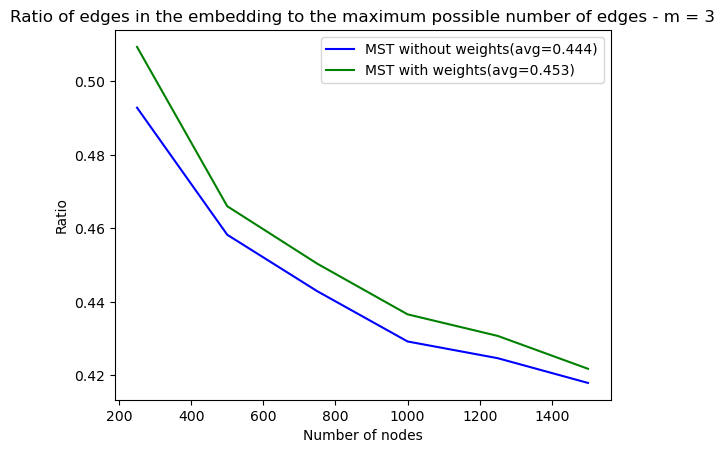

In [ ]:
INITIAL_NODES = 10
TRIES = 10

for m in [3]:
    print(f'm = {m}')
    n_value = []
    mst_ratios = []
    cactus_ratios = []
    mst_with_weights_ratios = []
    cactus_with_weights_ratios = []
    for n in [250, 500, 750, 1000, 1250, 1500]:
        print(f'n = {n}')
        n_value.append(n)
        mst_sum = 0
        # cactus_sum = 0
        mst_with_weights_sum = 0
        # cactus_with_weights_sum = 0
        
        for _ in range(TRIES):
            print(f'Try {_}')
            graph = generate_graph_with_metric(INITIAL_NODES, n, m)

            mst_method = mst_embeddings_without_weights(graph.copy(), True)
            # cactus_method = cactus_embeddings_without_weights(graph.copy(), True)
            mst_with_weights_method = mst_embeddings_with_weights(graph.copy(), True)
            # cactus_with_weights_method = cactus_embeddings_with_weights(graph.copy(), True)

            print([len(m.edges()) for m in mst_method])
            # print([len(m.edges()) for m in cactus_method])
            print([len(m.edges()) for m in mst_with_weights_method])
            # print([len(m.edges()) for m in cactus_with_weights_method])

            mst_sum += get_ratio(graph, [len(m.edges()) for m in mst_method])[0]
            # cactus_sum += get_ratio(graph, [len(m.edges()) for m in cactus_method])[0]
            mst_with_weights_sum += get_ratio(graph, [len(m.edges()) for m in mst_with_weights_method])[0]
            # cactus_with_weights_sum += get_ratio(graph, [len(m.edges()) for m in cactus_with_weights_method])[0]

        mst_ratios.append(mst_sum / TRIES)
        # cactus_ratios.append(cactus_sum / TRIES)
        mst_with_weights_ratios.append(mst_with_weights_sum / TRIES)
        # cactus_with_weights_ratios.append(cactus_with_weights_sum / TRIES)

    plt.plot(n_value, mst_ratios, label=f'MST without weights(avg={sum(mst_ratios) / len(mst_ratios):.3f})', color='blue')
    # plt.plot(n_value, cactus_ratios, label=f'Cactus without weights(avg={sum(cactus_ratios) / len(cactus_ratios):.3f})', color='red')
    plt.plot(n_value, mst_with_weights_ratios, label=f'MST with weights(avg={sum(mst_with_weights_ratios) / len(mst_with_weights_ratios):.3f})', color='green')
    # plt.plot(n_value, cactus_with_weights_ratios, label=f'Cactus with weights(avg={sum(cactus_with_weights_ratios) / len(cactus_with_weights_ratios):.3f})', color='purple')

    plt.xlabel('Number of nodes')
    plt.ylabel('Ratio')
    plt.title(f'Ratio of edges in the embedding to the maximum possible number of edges - m = {m}')
    plt.legend()
    plt.show()


m = 4
n = 30
Try 0
Try 10
Try 20
Try 30
Try 40
Try 50
Try 60
Try 70
Try 80
Try 90
n = 50
Try 0
Try 10
Try 20
Try 30
Try 40
Try 50
Try 60
Try 70
Try 80
Try 90
n = 70
Try 0
Try 10
Try 20
Try 30
Try 40
Try 50
Try 60
Try 70
Try 80
Try 90
n = 100
Try 0
Try 10
Try 20
Try 30
Try 40
Try 50
Try 60
Try 70
Try 80
Try 90


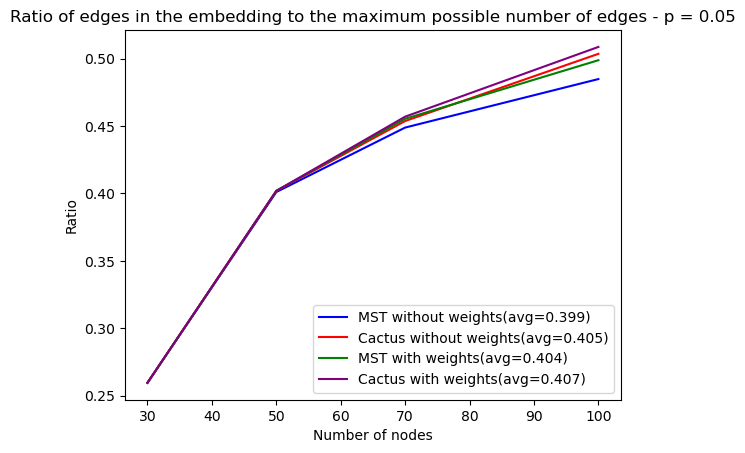

m = 4
n = 30
Try 0
Try 10
Try 20
Try 30
Try 40
Try 50
Try 60
Try 70
Try 80
Try 90
n = 50
Try 0
Try 10
Try 20
Try 30
Try 40
Try 50
Try 60
Try 70
Try 80
Try 90
n = 70
Try 0
Try 10
Try 20
Try 30
Try 40
Try 50
Try 60
Try 70
Try 80
Try 90
n = 100
Try 0
Try 10
Try 20
Try 30
Try 40
Try 50
Try 60
Try 70
Try 80
Try 90


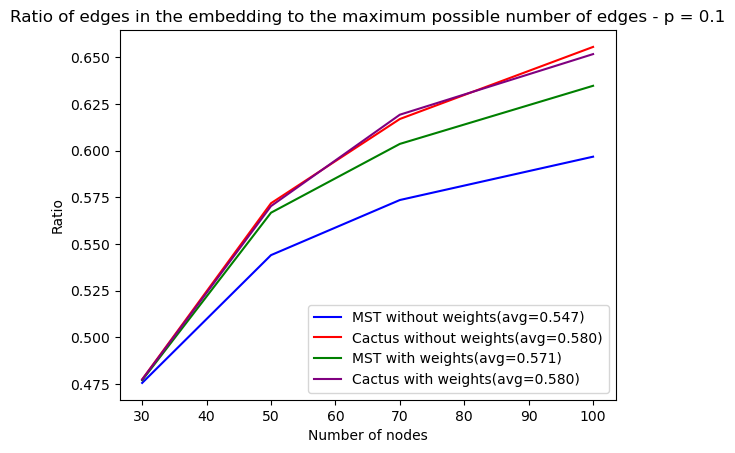

m = 4
n = 30
Try 0
Try 10
Try 20
Try 30
Try 40
Try 50
Try 60
Try 70
Try 80
Try 90
n = 50
Try 0
Try 10
Try 20
Try 30
Try 40
Try 50
Try 60
Try 70
Try 80
Try 90
n = 70
Try 0
Try 10
Try 20
Try 30
Try 40
Try 50
Try 60
Try 70
Try 80
Try 90
n = 100
Try 0
Try 10
Try 20
Try 30
Try 40
Try 50
Try 60
Try 70
Try 80
Try 90


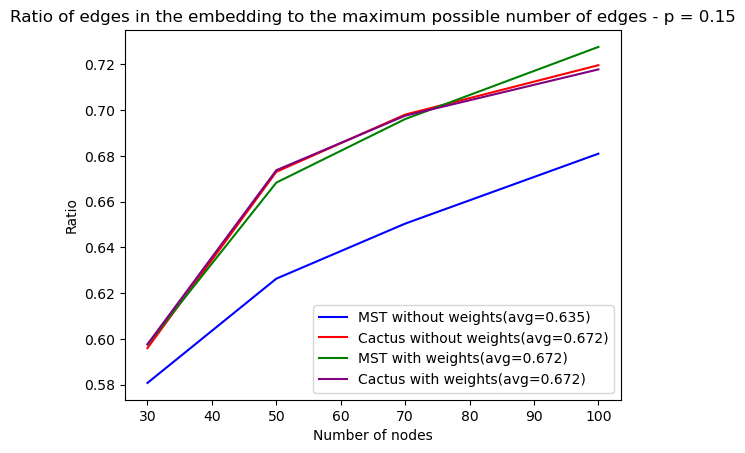

m = 4
n = 30
Try 0
Try 10
Try 20
Try 30
Try 40
Try 50
Try 60
Try 70
Try 80
Try 90
n = 50
Try 0
Try 10
Try 20
Try 30
Try 40
Try 50
Try 60
Try 70
Try 80
Try 90
n = 70
Try 0
Try 10
Try 20
Try 30
Try 40
Try 50
Try 60
Try 70
Try 80
Try 90
n = 100
Try 0
Try 10
Try 20
Try 30
Try 40
Try 50
Try 60
Try 70
Try 80
Try 90


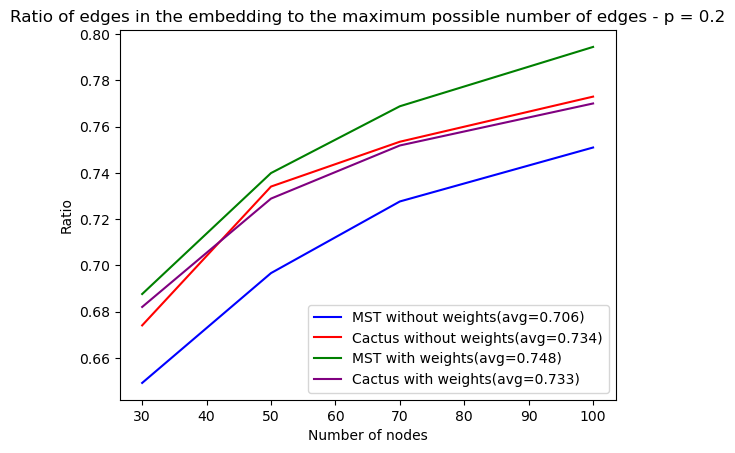

In [ ]:
TRIES = 100

mst_ratios = []
mst_with_weights_ratios = []

for p in [0.05, 0.1, 0.15, 0.2]:
    print(f'm = {m}')
    n_value = []
    mst_ratios = []
    cactus_ratios = []
    mst_with_weights_ratios = []
    cacuts_with_weights_ratios = []
    for n in [30, 50, 70, 100]:
        print(f'n = {n}')
        n_value.append(n)
        mst_sum = 0
        cactus_sum = 0
        mst_with_weights_sum = 0
        cacuts_with_weights_sum = 0
        for _ in range(TRIES):
            if _ % 10 == 0:
                print(f'Try {_}')
            graph = nx.gnp_random_graph(n, p)

            mst_method = mst_embeddings_without_weights(graph.copy(), True)
            cactus_method = cactus_embeddings_without_weights(graph.copy(), True)
            mst_with_weights_method = mst_embeddings_with_weights(graph.copy(), True)
            cacuts_with_weights_method = cactus_embeddings_with_weights(graph.copy(), True)

            mst_sum += get_ratio(graph, [len(m.edges()) for m in mst_method])[0]
            cactus_sum += get_ratio(graph, [len(m.edges()) for m in cactus_method])[0]
            mst_with_weights_sum += get_ratio(graph, [len(m.edges()) for m in mst_with_weights_method])[0]
            cacuts_with_weights_sum += get_ratio(graph, [len(m.edges()) for m in cacuts_with_weights_method])[0]

        mst_ratios.append(mst_sum / TRIES)
        cactus_ratios.append(cactus_sum / TRIES)
        mst_with_weights_ratios.append(mst_with_weights_sum / TRIES)
        cacuts_with_weights_ratios.append(cacuts_with_weights_sum / TRIES)

    plt.plot(n_value, mst_ratios, label=f'MST without weights(avg={sum(mst_ratios) / len(mst_ratios):.3f})', color='blue')
    plt.plot(n_value, cactus_ratios, label=f'Cactus without weights(avg={sum(cactus_ratios) / len(cactus_ratios):.3f})', color='red')
    plt.plot(n_value, mst_with_weights_ratios, label=f'MST with weights(avg={sum(mst_with_weights_ratios) / len(mst_with_weights_ratios):.3f})', color='green')
    plt.plot(n_value, cacuts_with_weights_ratios, label=f'Cactus with weights(avg={sum(cacuts_with_weights_ratios) / len(cacuts_with_weights_ratios):.3f})', color='purple')

    plt.xlabel('Number of nodes')
    plt.ylabel('Ratio')
    plt.title(f'Ratio of edges in the embedding to the maximum possible number of edges - p = {p}')
    plt.legend()
    plt.show()

m = 2
n = 30
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
n = 50
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26

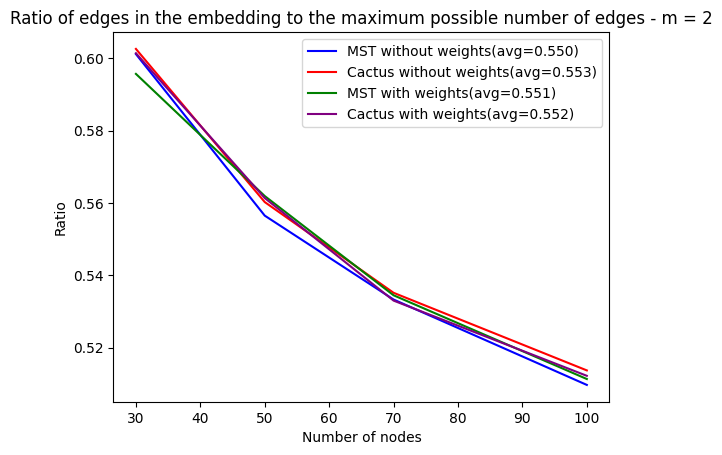

m = 3
n = 30
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
n = 50
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26

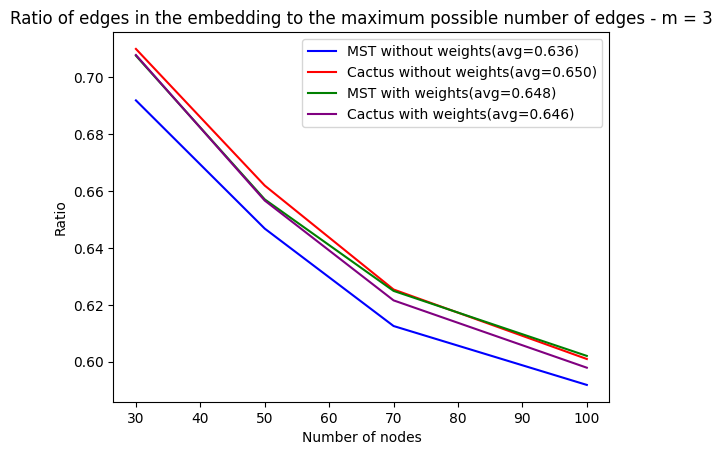

m = 4
n = 30
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
n = 50
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26

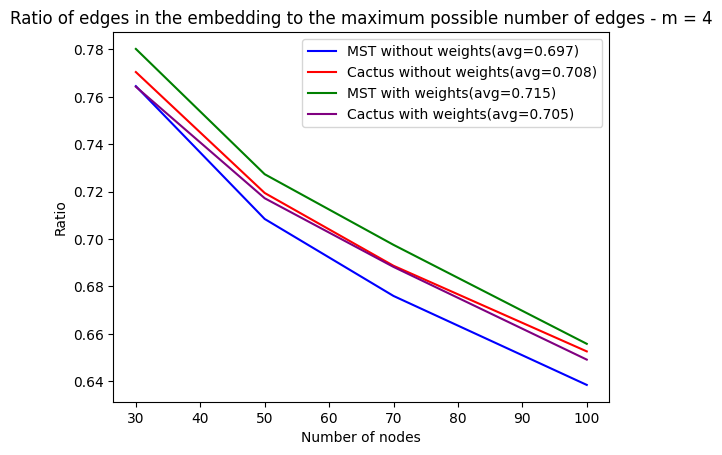

m = 5
n = 30
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
n = 50
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26

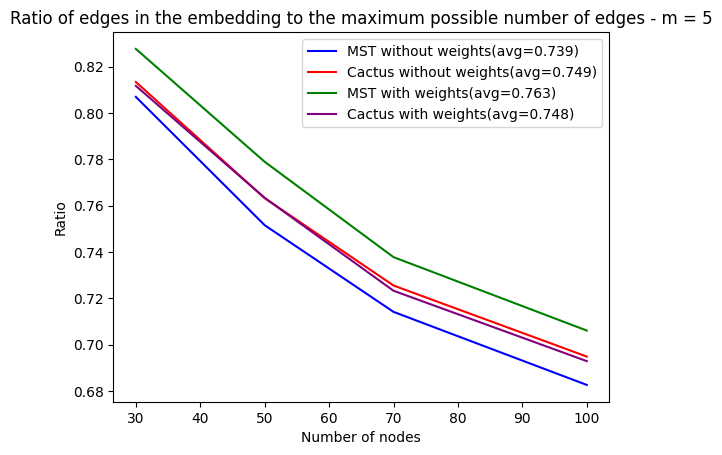

In [ ]:
TRIES = 50

mst_ratios = []
mst_with_weights_ratios = []

for m in [2, 3, 4, 5]:
    print(f'm = {m}')
    n_value = []
    mst_ratios = []
    cactus_ratios = []
    mst_with_weights_ratios = []
    cacuts_with_weights_ratios = []
    for n in [30, 50, 70, 100]:
        print(f'n = {n}')
        n_value.append(n)
        mst_sum = 0
        cactus_sum = 0
        mst_with_weights_sum = 0
        cacuts_with_weights_sum = 0
        for _ in range(TRIES):
            print(f'Iteration {_}')

            graph = nx.barabasi_albert_graph(n, m)

            mst_method = mst_embeddings_without_weights(graph.copy(), True)
            cactus_method = cactus_embeddings_without_weights(graph.copy(), True)
            mst_with_weights_method = mst_embeddings_with_weights(graph.copy(), True)
            cacuts_with_weights_method = cactus_embeddings_with_weights(graph.copy(), True)

            mst_sum += get_ratio(graph, [len(m.edges()) for m in mst_method])[0]
            cactus_sum += get_ratio(graph, [len(m.edges()) for m in cactus_method])[0]
            mst_with_weights_sum += get_ratio(graph, [len(m.edges()) for m in mst_with_weights_method])[0]
            cacuts_with_weights_sum += get_ratio(graph, [len(m.edges()) for m in cacuts_with_weights_method])[0]

        mst_ratios.append(mst_sum / TRIES)
        cactus_ratios.append(cactus_sum / TRIES)
        mst_with_weights_ratios.append(mst_with_weights_sum / TRIES)
        cacuts_with_weights_ratios.append(cacuts_with_weights_sum / TRIES)

    plt.plot(n_value, mst_ratios, label=f'MST without weights(avg={sum(mst_ratios) / len(mst_ratios):.3f})', color='blue')
    plt.plot(n_value, cactus_ratios, label=f'Cactus without weights(avg={sum(cactus_ratios) / len(cactus_ratios):.3f})', color='red')
    plt.plot(n_value, mst_with_weights_ratios, label=f'MST with weights(avg={sum(mst_with_weights_ratios) / len(mst_with_weights_ratios):.3f})', color='green')
    plt.plot(n_value, cacuts_with_weights_ratios, label=f'Cactus with weights(avg={sum(cacuts_with_weights_ratios) / len(cacuts_with_weights_ratios):.3f})', color='purple')

    plt.xlabel('Number of nodes')
    plt.ylabel('Ratio')
    plt.title(f'Ratio of edges in the embedding to the maximum possible number of edges - m = {m}')
    plt.legend()
    plt.show()

In [ ]:
def compare(initial_nodes, final_nodes, edges_per_node, with_complement, tries):
    mst_ratios = []
    mst_emmbeddings_number = []
    mst_with_weights_ratios = []
    mst_with_weights_emmbeddings_number = []
    cactus_ratios = []
    cactus_embeddings_number = []
    cactus_with_weights_ratios = []
    cactus_with_weights_embeddings_number = []

    for _ in range(tries):
        graph = generate_graph_with_metric(initial_nodes, final_nodes, edges_per_node)
        mst_method = mst_embeddings_without_weights(graph.copy(), with_complement)
        mst_with_weights_method = mst_embeddings_with_weights(graph.copy(), with_complement)

        cactus_method = cactus_embeddings_without_weights(graph.copy(), with_complement)
        cactus_with_weights_method = cactus_embeddings_with_weights(graph.copy(), with_complement)

        mst_ratios.append(get_ratio(graph, [len(m.edges()) for m in mst_method]))
        mst_emmbeddings_number.append(len(mst_method))
        mst_with_weights_ratios.append(get_ratio(graph, [len(m.edges()) for m in mst_with_weights_method]))
        mst_with_weights_emmbeddings_number.append(len(mst_with_weights_method))
        cactus_ratios.append(get_ratio(graph, [len(m.edges()) for m in cactus_method]))
        cactus_embeddings_number.append(len(cactus_method))
        cactus_with_weights_ratios.append(get_ratio(graph, [len(m.edges()) for m in cactus_with_weights_method]))
        cactus_with_weights_embeddings_number.append(len(cactus_with_weights_method))

    return mst_ratios, mst_emmbeddings_number, mst_with_weights_ratios, mst_with_weights_emmbeddings_number, cactus_ratios, cactus_embeddings_number, cactus_with_weights_ratios, cactus_with_weights_embeddings_number

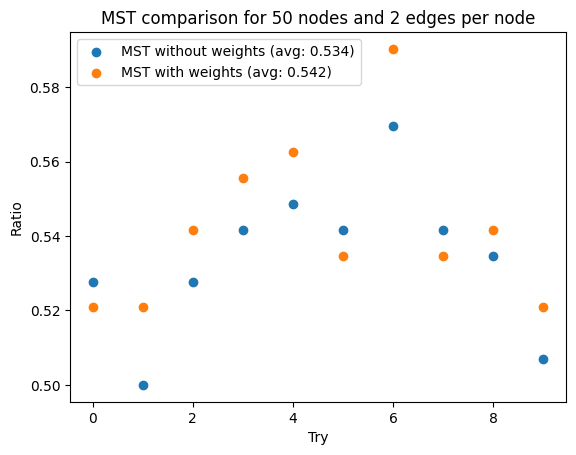

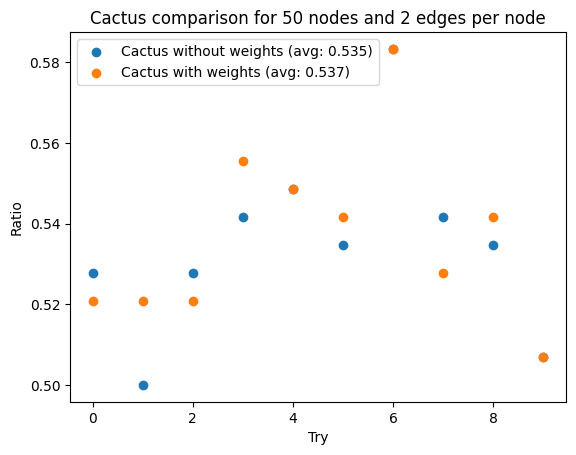

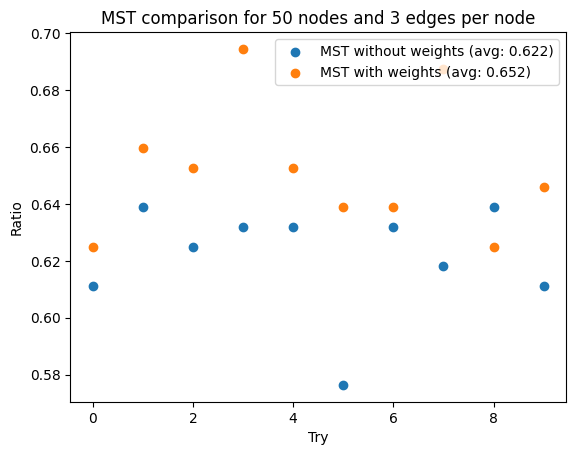

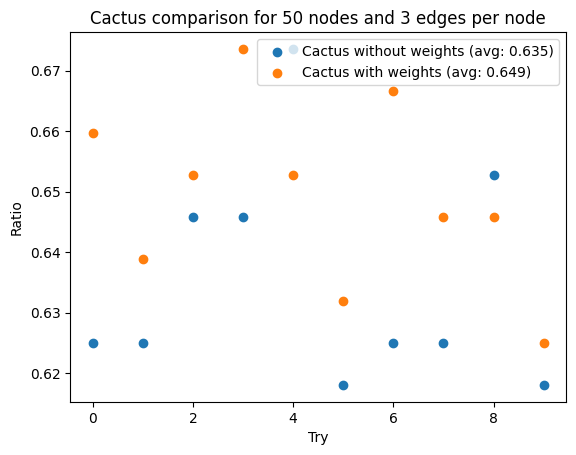

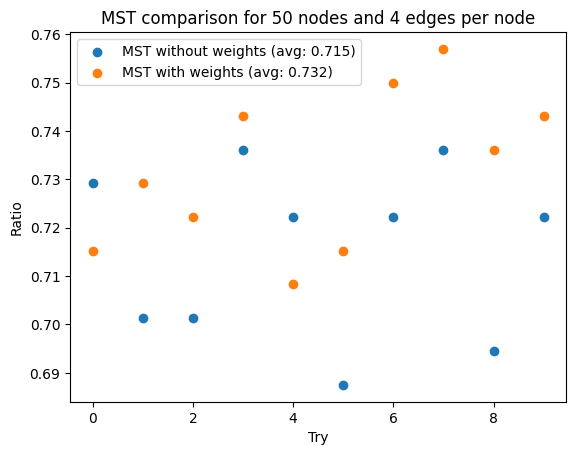

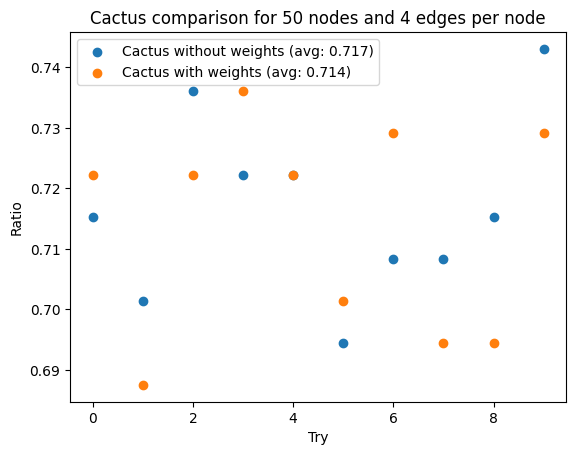

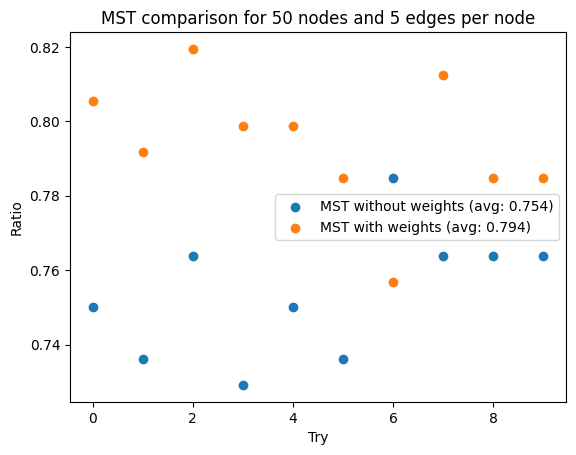

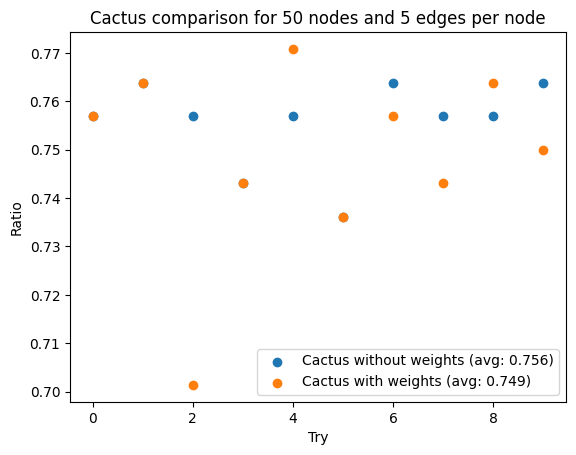

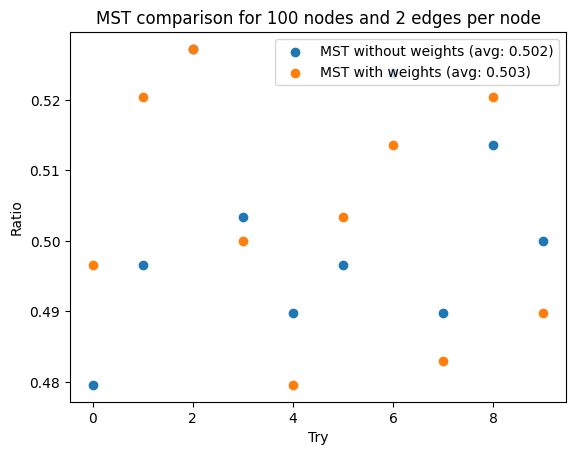

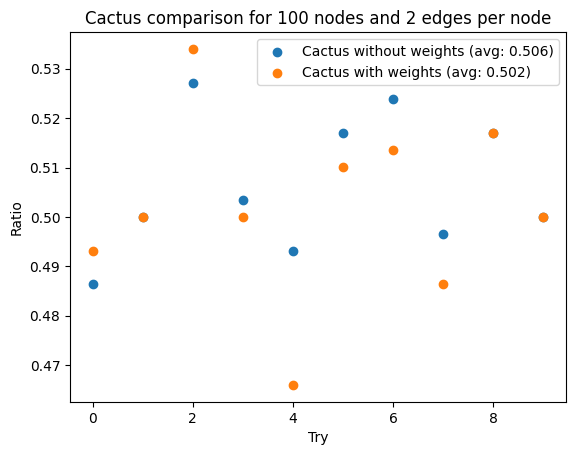

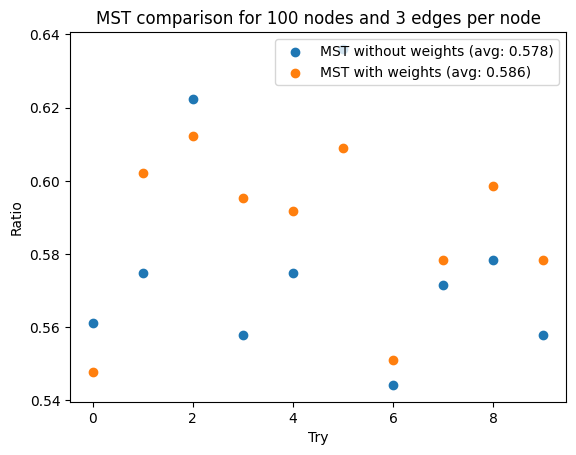

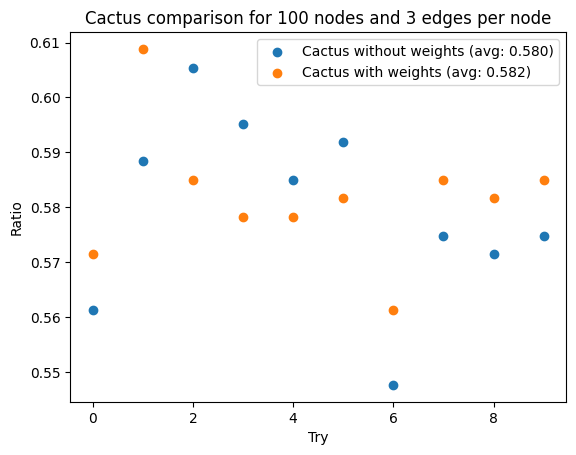

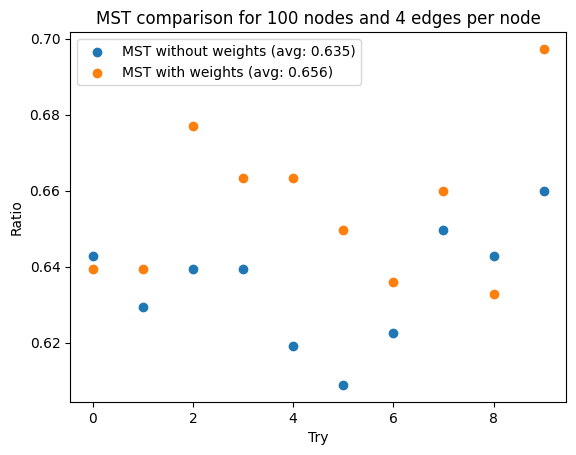

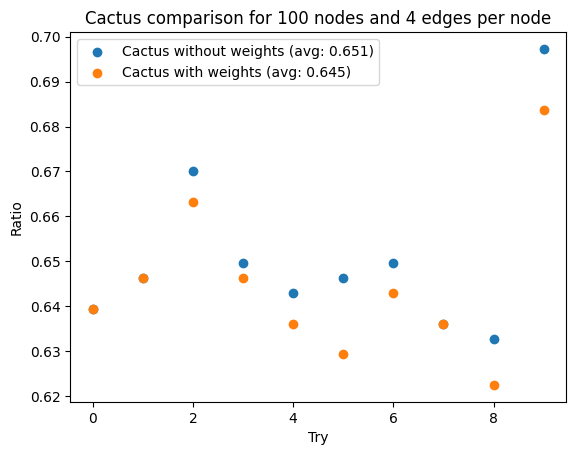

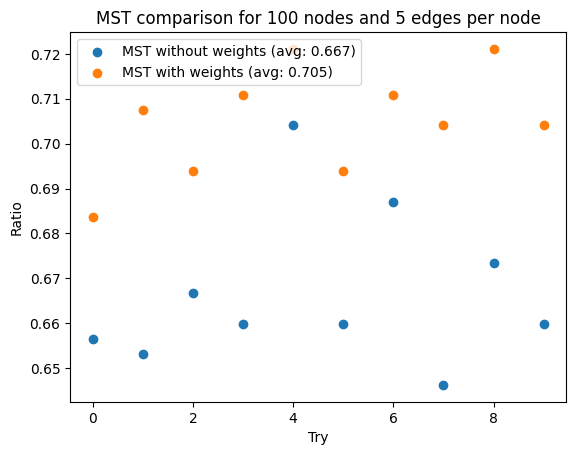

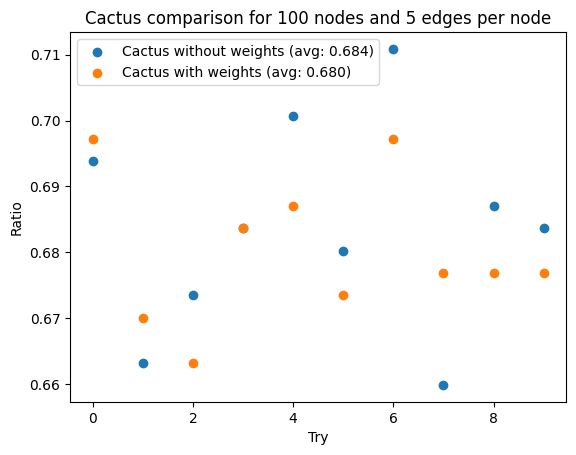

In [ ]:
TRIES = 10

for initial_nodes in [5]:
    for final_nodes in [50, 100]:
        for edges_per_node in [2, 3, 4, 5]:
            mst_ratios, mst_emmbeddings_number, mst_with_weights_ratios, mst_with_weights_emmbeddings_number, cactus_ratios, cactus_embeddings_number, cactus_with_weights_ratios, cactus_with_weights_embeddings_number = compare(initial_nodes, final_nodes, edges_per_node, True, TRIES)

            avg_mst_ratio = np.mean([ratio[0] for ratio in mst_ratios])
            avg_mst_with_weights_ratio = np.mean([ratio[0] for ratio in mst_with_weights_ratios])

            avg_mst_emmbbeddings_number = np.mean(mst_emmbeddings_number)
            avg_mst_with_weights_emmbeddings_number = np.mean(mst_with_weights_emmbeddings_number)

            avg_cactus_ratio = np.mean([ratio[0] for ratio in cactus_ratios])
            avg_cactus_with_weights_ratio = np.mean([ratio[0] for ratio in cactus_with_weights_ratios])

            avg_cactus_embeddings_number = np.mean(cactus_embeddings_number)
            avg_cactus_with_weights_embeddings_number = np.mean(cactus_with_weights_embeddings_number)

            tries = [i for i in range(TRIES)]

            plt.scatter(tries, [ratio[0] for ratio in mst_ratios], label='MST without weights (avg: {:.3f})'.format(avg_mst_ratio))
            plt.scatter(tries, [ratio[0] for ratio in mst_with_weights_ratios], label='MST with weights (avg: {:.3f})'.format(avg_mst_with_weights_ratio))
            plt.title(f'MST comparison for {final_nodes} nodes and {edges_per_node} edges per node')
            plt.xlabel('Try')
            plt.ylabel('Ratio')
            plt.legend()
            plt.show()

            plt.scatter(tries, [ratio[0] for ratio in cactus_ratios], label='Cactus without weights (avg: {:.3f})'.format(avg_cactus_ratio))
            plt.scatter(tries, [ratio[0] for ratio in cactus_with_weights_ratios], label='Cactus with weights (avg: {:.3f})'.format(avg_cactus_with_weights_ratio))
            plt.title(f'Cactus comparison for {final_nodes} nodes and {edges_per_node} edges per node')
            plt.xlabel('Try')
            plt.ylabel('Ratio')
            plt.legend()
            plt.show()

In [ ]:
TRIES = 10

for initial_nodes in [5]:
    for final_nodes in [50, 100]:
        for edges_per_node in [2, 3, 4]:
            mst_ratios, mst_emmbeddings_number, mst_with_weights_ratios, mst_with_weights_emmbeddings_number, cactus_ratios, cactus_embeddings_number, cactus_with_weights_ratios, cactus_with_weights_embeddings_number = compare(initial_nodes, final_nodes, edges_per_node, False, TRIES)

            avg_mst_ratio = np.mean([ratio[0] for ratio in mst_ratios])
            avg_mst_with_weights_ratio = np.mean([ratio[0] for ratio in mst_with_weights_ratios])

            avg_mst_emmbbeddings_number = np.mean(mst_emmbeddings_number)
            avg_mst_with_weights_emmbeddings_number = np.mean(mst_with_weights_emmbeddings_number)

            avg_cactus_ratio = np.mean([ratio[0] for ratio in cactus_ratios])
            avg_cactus_with_weights_ratio = np.mean([ratio[0] for ratio in cactus_with_weights_ratios])

            avg_cactus_embeddings_number = np.mean(cactus_embeddings_number)
            avg_cactus_with_weights_embeddings_number = np.mean(cactus_with_weights_embeddings_number)

            tries = [i for i in range(TRIES)]

            plt.scatter(tries, mst_emmbeddings_number, label='MST without weights (avg: {:.3f})'.format(avg_mst_emmbbeddings_number))
            plt.scatter(tries, mst_with_weights_emmbeddings_number, label='MST with weights (avg: {:.3f})'.format(avg_mst_with_weights_emmbeddings_number))
            plt.title(f'MST embeddings number comparison for {final_nodes} nodes and {edges_per_node} edges per node')
            plt.xlabel('Try')
            plt.ylabel('Embeddings number')
            plt.legend()
            plt.show()

            plt.scatter(tries, cactus_embeddings_number, label='Cactus without weights (avg: {:.3f})'.format(avg_cactus_embeddings_number))
            plt.scatter(tries, cactus_with_weights_embeddings_number, label='Cactus with weights (avg: {:.3f})'.format(avg_cactus_with_weights_embeddings_number))
            plt.title(f'Cactus embeddings number comparison for {final_nodes} nodes and {edges_per_node} edges per node')
            plt.xlabel('Try')
            plt.ylabel('Embeddings number')
            plt.legend()
            plt.show()

In [ ]:
TRIES = 10
INITIAL_NODES = 5
FINAL_NODES = 13
EDGES_PER_NODE = 4

results = []
for t in range(TRIES):
    print(f'Try {t + 1}')

    graph = generate_graph(INITIAL_NODES, n, m)
    
    paths_number_for_degrees = {}
    for node in graph.nodes():
        paths_number_for_degrees[graph.degree(node)] = 0

    edge_usage_number = {}
    for edge in graph.edges():
        if edge[0] < edge[1]:
            edge_usage_number[edge] = 0
        else:
            edge_usage_number[(edge[1], edge[0])] = 0

    for source in graph.nodes():
        for target in graph.nodes():
            if source != target:
                try:
                    paths = list(nx.all_simple_paths(graph, source, target))
                    paths_number_for_degrees[graph.degree(source)] += len(paths)
                    for path in paths:
                        for i in range(len(path) - 1):
                            if path[i] < path[i+1]:
                                edge_usage_number[(path[i], path[i+1])] += 1
                            else:
                                edge_usage_number[(path[i+1], path[i])] += 1

                except nx.NetworkXNoPath:
                    pass

    results.append((graph, paths_number_for_degrees, edge_usage_number))

pickle.dump(results, open(f'calculation-cache/results_{INITIAL_NODES}_{m}_{n}.pkl', 'wb'))

Try 1
Try 2
Try 3
Try 4
Try 5
Try 6
Try 7
Try 8
Try 9
Try 10


In [ ]:
input_data = {
    2: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
    3: [10, 11, 12, 13, 14, 15, 16, 17],
    4: [10, 11, 12, 13, 14]
}

for m, ns in input_data.items():
    data = {}
    for n in ns:
        results = pickle.load(open(f'calculation-cache/results_{3}_{m}_{n}.pkl', 'rb'))
        
        deg_paths = {}
        for result in results:
            for deg, paths_num in result[1].items():
                if deg not in deg_paths:
                    deg_paths[deg] = []
                deg_paths[deg].append(paths_num)

        degs = []
        avg_paths_num = []
        for deg, paths_num in deg_paths.items():
            degs.append(deg)
            avg_paths_num.append(sum(paths_num) / len(paths_num))

        for deg, avg in zip(degs, avg_paths_num):
            if deg not in data:
                data[deg] = {}
            data[deg][n] = avg

    def get_n(d, n, m):
        return (d ** -3) * (m ** (n+1))
    
    def logm(val, m):
        return math.log(val) / math.log(m)

    def coeff_p(val, d, n, m):
        return logm(val / (d ** -3), m) / n

    for d in data:
        x = []
        p1 = []
        p2 = []

        for n in data[d]:
            x.append(n)
            p1.append(data[d][n])
            p2.append(get_n(d, n, m))

        plt.scatter(x, p1, color='blue')
        plt.scatter(x, p2, color='red')
        plt.xlabel('Number of nodes')
        plt.ylabel('Average number of paths')
        plt.title(f'Average number of paths for degree {d} and m={m}')
        plt.show()

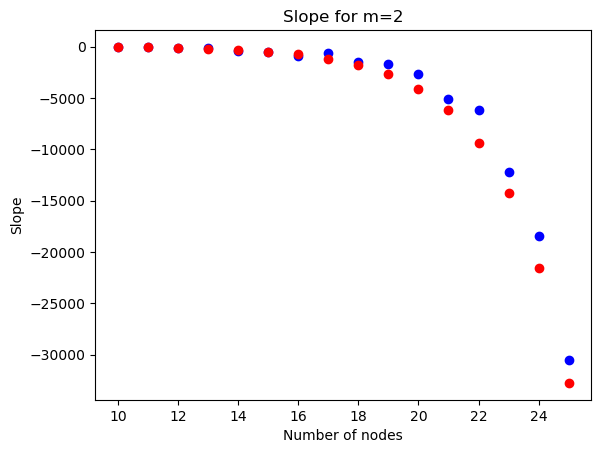

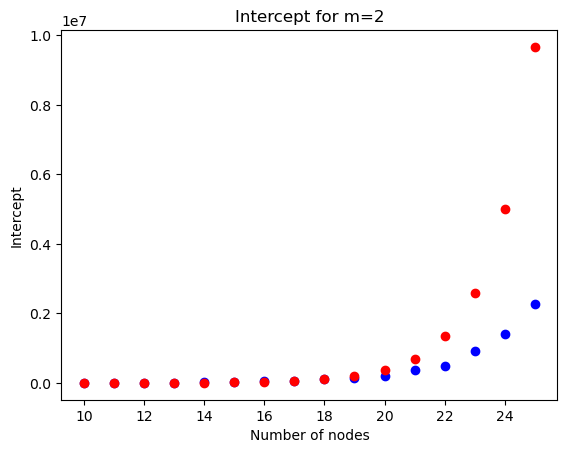

25 2 [0.63372627361902, 0.6346602075078548, 0.6356795723108268, 0.636740719169785, 0.6378158608125355, 0.6388872009025857, 0.6399433732602248, 0.6409772216695719, 0.6419843826469183, 0.6429623624866138, 0.6439099259074189, 0.6448266852749918, 0.6457128213155489, 0.6465688914232328, 0.6473956971427642, 0.6481941921203953]


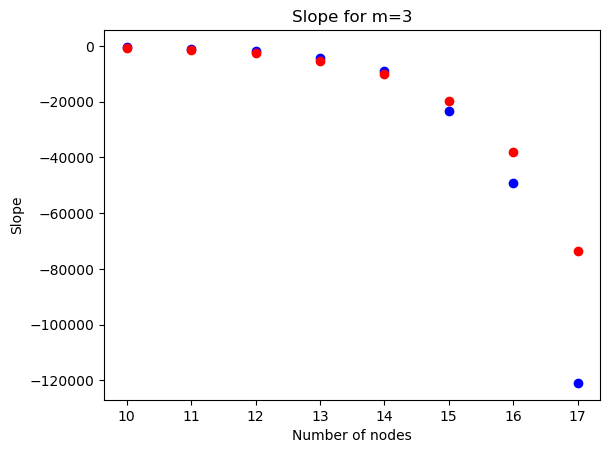

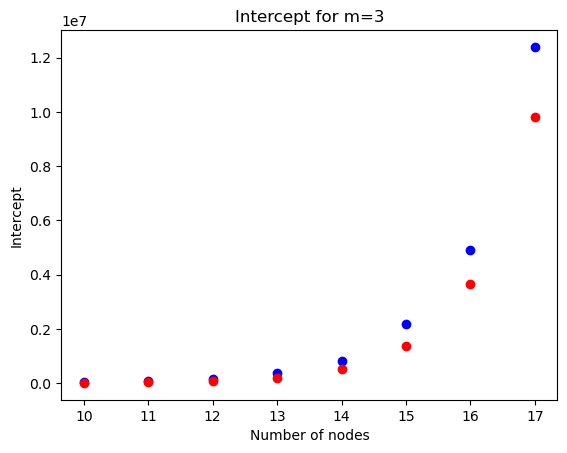

17 3 [0.56745254723804, 0.5693204150157096, 0.5713591446216536, 0.5734814383395701, 0.575631721625071, 0.5777744018051713, 0.5798867465204496, 0.5819544433391439]


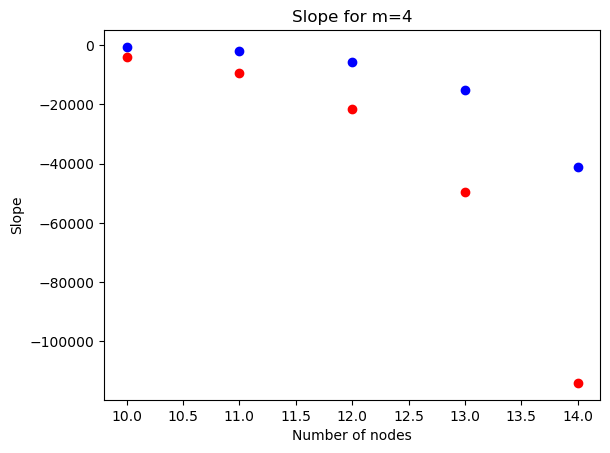

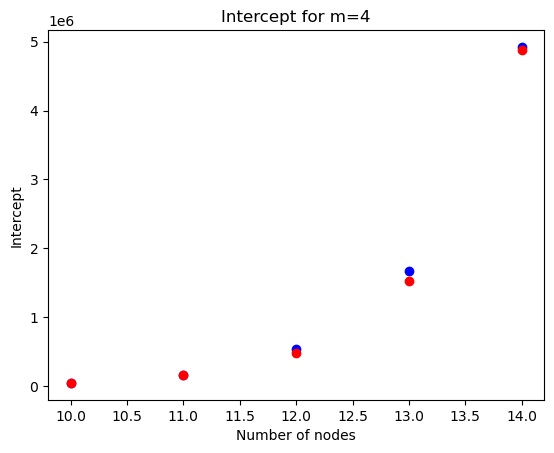

14 4 [0.50117882085706, 0.5039806225235646, 0.5070387169324805, 0.5102221575093553, 0.5134475824376066]


In [ ]:
input_data = {
    2: [3, [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]],
    3: [3, [10, 11, 12, 13, 14, 15, 16, 17]],
    4: [5, [10, 11, 12, 13, 14]]
}

comparison_data = {}

for m, n0_ns in input_data.items():
    n0, ns = n0_ns
    data = {}
    for n in ns:
        results = pickle.load(open(f'calculation-cache/results_{n0}_{m}_{n}.pkl', 'rb'))
        
        deg_mult_usages = {}
        for result in results:
            graph = result[0]
            for edge, usage in result[2].items():
                neighbors = list(graph.neighbors(edge[0])) + list(graph.neighbors(edge[1]))
                neighbors.remove(edge[0])
                neighbors.remove(edge[1])
                sum_of_neighbor_degrees = sum([graph.degree(neighbor) for neighbor in neighbors])
                mult = sum_of_neighbor_degrees

                if mult not in deg_mult_usages:
                    deg_mult_usages[mult] = []
                deg_mult_usages[mult].append(usage)

        mults = []
        avg_usages = []
        for mult, usages in deg_mult_usages.items():
            mults.append(mult)
            avg_usages.append(sum(usages) / len(usages))

        slope, intercept, r_value, p_value, std_err = linregress(mults, avg_usages)
        data[n] = (slope, intercept)
    
    def logm(x, m):
        return math.log(x) / math.log(m)
    
    def cluster_coeff(m, n):
        # if n < 1:
        #     return 0
        return (m-1) / 8 * math.log(n)**2 / n

    def get_s(n, m):
        return -m ** (0.6 * n)

    def get_i(n, m):
        # return m ** (0.9 * n)
        return m ** ((0.98 - cluster_coeff(m, n)) * n)

    def coeff_s(s, m, n):
        return logm(-s, m) / n
    
    def coeff_i(i, m, n):
        return logm(i, m) / n
    
    x = []
    s1 = []
    s2 = []
    i1 = []
    i2 = []

    r = []

    for n in data:
        x.append(n)
        s1.append(data[n][0])
        s2.append(get_s(n, m))
        i1.append(data[n][1])
        i2.append(get_i(n, m))
        r.append(0.7-cluster_coeff(m, n))
        
    plt.scatter(x, s1, color='blue')
    plt.scatter(x, s2, color='red')
    plt.xlabel('Number of nodes')
    plt.ylabel('Slope')
    plt.title(f'Slope for m={m}') 
    plt.show()

    plt.scatter(x, i1, color='blue')
    plt.scatter(x, i2, color='red')
    plt.xlabel('Number of nodes')
    plt.ylabel('Intercept')
    plt.title(f'Intercept for m={m}')
    plt.show()

    print(n, m, r)

    comparison_data[m] = (x, s1, s2, i1, i2)

m=2
clustering coefficient: 0.06627372638097999
clustering coefficient: 0.06533979249214515
clustering coefficient: 0.06432042768917316
clustering coefficient: 0.06325928083021491
clustering coefficient: 0.06218413918746445
clustering coefficient: 0.061112799097414336
clustering coefficient: 0.060056626739775174
clustering coefficient: 0.05902277833042799
clustering coefficient: 0.058015617353081694
clustering coefficient: 0.05703763751338624
clustering coefficient: 0.05609007409258102
clustering coefficient: 0.05517331472500818
clustering coefficient: 0.05428717868445112
clustering coefficient: 0.05343110857676714
clustering coefficient: 0.05260430285723567
clustering coefficient: 0.05180580787960469


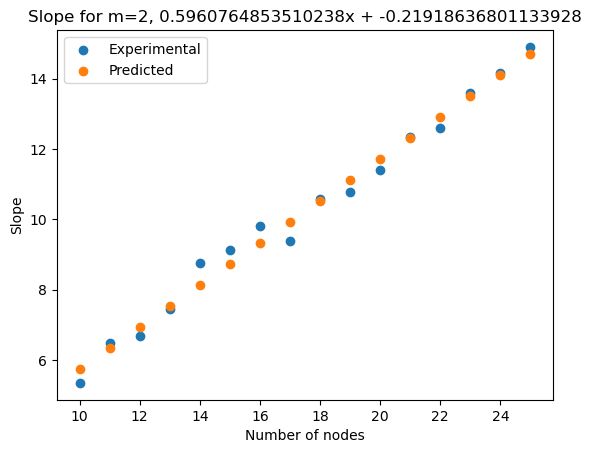

m=3
clustering coefficient: 0.13254745276195998
clustering coefficient: 0.1306795849842903
clustering coefficient: 0.12864085537834632
clustering coefficient: 0.12651856166042982
clustering coefficient: 0.1243682783749289
clustering coefficient: 0.12222559819482867
clustering coefficient: 0.12011325347955035
clustering coefficient: 0.11804555666085598


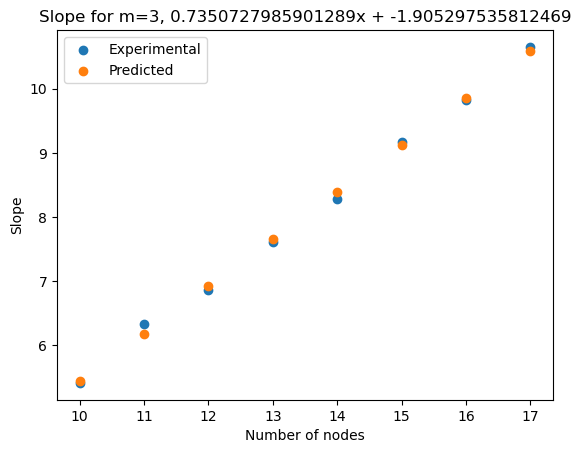

m=4
clustering coefficient: 0.19882117914293998
clustering coefficient: 0.19601937747643544
clustering coefficient: 0.1929612830675195
clustering coefficient: 0.18977784249064472
clustering coefficient: 0.18655241756239335


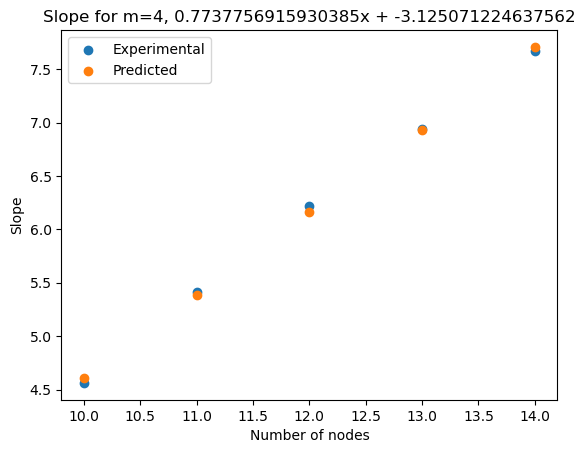

In [ ]:
input_data = {
    2: [3, [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]],
    3: [3, [10, 11, 12, 13, 14, 15, 16, 17]],
    4: [5, [10, 11, 12, 13, 14]]
}

comparison_data = {}

def calculate_degrees(graph, edge):
    degree = graph.degree(edge[0]) + graph.degree(edge[1])
    neighbors = list(graph.neighbors(edge[0])) + list(graph.neighbors(edge[1]))
    neighbors.remove(edge[0])
    neighbors.remove(edge[1])
    sum_of_neighbor_degrees = sum([graph.degree(neighbor) for neighbor in neighbors])
    neighbors_of_neighbors = set(
        nbr_of_nbr
        for neighbor in neighbors
        for nbr_of_nbr in graph.neighbors(neighbor)
        # if nbr_of_nbr != node
    )
    sum_of_neighbor_neighbors_degrees = sum([graph.degree(neighbor_neighbor) for neighbor_neighbor in neighbors_of_neighbors])

    return degree, sum_of_neighbor_degrees, sum_of_neighbor_neighbors_degrees

def logm(x, m):
    return math.log(x) / math.log(m)

def cluster_coeff(m, n):
    # if n < 1:
    #     return 0
    return (m-1) / 8 * math.log(n)**2 / n

def get_s(n, m):
    return -m ** (0.6 * n)

def get_i(n, m):
    # return m ** (0.9 * n)
    return m ** ((0.9 - cluster_coeff(m, n)) * n)

def coeff_s(s, m, n):
    return logm(-s, m) / n

def coeff_i(i, m, n):
    return logm(i, m) / n


def predict1(n, m, s):
    return m ** (0.9 * n) - m**(0.6 * n) * s

def predict2(n, m, s):
    c = 1 - cluster_coeff(m, n)
    return m ** (c * n) - m**(0.6 * n) * s

def predict3(n, m, s):
    return m ** (0.9 * n) - m**(0.3 * n) * s * n

for m, n0_ns in input_data.items():
    n0, ns = n0_ns
    print(f'm={m}')
    degree_data = {}
    neighbor_degree_data = {}
    neighbor_neighbor_degree_data = {}

    slopes = []
    intercepts = []

    for n in ns:
        results = pickle.load(open(f'calculation-cache/results_{n0}_{m}_{n}.pkl', 'rb'))
        
        degree_usages = {}
        neighbor_degree_usages = {}
        neighbor_neighbor_degree_usages = {}
        for result in results:
            graph = result[0]
            for edge, usage in result[2].items():
                degree, neighbor_degree, neighbor_neighbor_degree = calculate_degrees(graph, edge)

                if degree not in degree_usages:
                    degree_usages[degree] = []
                degree_usages[degree].append(usage)

                if neighbor_degree not in neighbor_degree_usages:
                    neighbor_degree_usages[neighbor_degree] = []
                neighbor_degree_usages[neighbor_degree].append(usage)

                if neighbor_neighbor_degree not in neighbor_neighbor_degree_usages:
                    neighbor_neighbor_degree_usages[neighbor_neighbor_degree] = []
                neighbor_neighbor_degree_usages[neighbor_neighbor_degree].append(usage)

        x1 = []
        y1 = []
        for degree, usages in degree_usages.items():
            x1.append(degree)
            y1.append(sum(usages) / len(usages))

        x2 = []
        y2 = []
        for degree, usages in neighbor_degree_usages.items():
            x2.append(degree)
            y2.append(sum(usages) / len(usages))
                      
        x3 = []
        y3 = []
        for degree, usages in neighbor_neighbor_degree_usages.items():
            x3.append(degree)
            y3.append(sum(usages) / len(usages))

        # plt.scatter(x1, y1, label=f'n={n}')
        # plt.scatter(x1, [predict1(n, m, x) for x in x1], label=f'Predicted')
        # plt.xlabel('Degree')
        # plt.ylabel('Average usage')
        # plt.title(f'Average usage for degree for m={m}')
        # plt.legend()
        # plt.show()

        print(f'clustering coefficient: {cluster_coeff(m, n)}')

        slope, intercept, r_value, p_value, std_err = linregress(x2, y2)
        slopes.append(slope)
        intercepts.append(intercept)

        # plt.scatter(x2, y2, label=f'n={n}')
        # plt.scatter(x2, [slope * x + intercept for x in x2], label=f'Predicted')
        # # plt.scatter(x2, [y / predict2(n, m, x) for x, y in zip(x2, y2)], label=f'n={n}')
        # plt.xlabel('Neighbor degree')
        # plt.ylabel('Average usage')
        # plt.title(f'Average usage for neighbor degree for m={m}')
        # plt.legend()
        # plt.show()

        # plt.scatter(x3, y3, label=f'n={n}')
        # plt.scatter(x3, [predict3(n, m, x) for x in x3], label=f'Predicted')
        # plt.xlabel('Neighbor neighbor degree')
        # plt.ylabel('Average usage')
        # plt.title(f'Average usage for neighbor neighbor degree for m={m}')
        # plt.legend()
        # plt.show()

        # slope, intercept, r_value, p_value, std_err = linregress(mults, avg_usages)
        # data[n] = (slope, intercept)

    slopes_array = [logm(-s, m) for s in slopes]
    intercepts_array = [logm(i, m) for i in intercepts]

    slopes_slope, slopes_intercept, r_value, p_value, std_err = linregress(ns, slopes_array)
    intercepts_slope, intercepts_intercept, r_value, p_value, std_err = linregress(ns, intercepts_array)
    
    # plt.scatter(ns, slopes, label='Slope')
    plt.scatter(ns, slopes_array, label='Experimental')
    plt.scatter(ns, [slopes_slope * n + slopes_intercept for n in ns], label='Predicted')
    plt.xlabel('Number of nodes')
    plt.ylabel('Slope')
    plt.title(f'Slope for m={m}, {slopes_slope}x + {slopes_intercept}')
    plt.legend()
    plt.show()

    # plt.scatter(ns, intercepts, label='Intercept')
    # plt.scatter(ns, intercepts_array, label='Experimental')
    # plt.scatter(ns, [intercepts_slope * n + intercepts_intercept for n in ns], label='Predicted')
    # plt.xlabel('Number of nodes')
    # plt.ylabel('Intercept')
    # plt.title(f'Intercept for m={m}, {intercepts_slope}x + {intercepts_intercept}')
    # plt.legend()
    # plt.show()


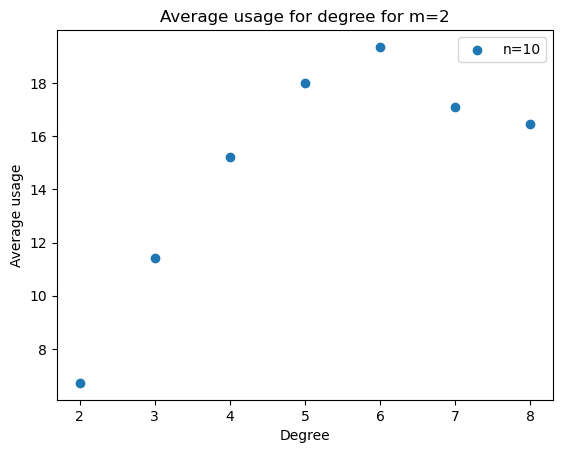

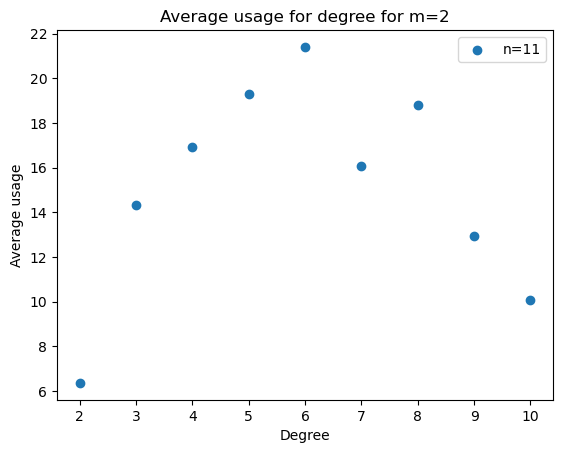

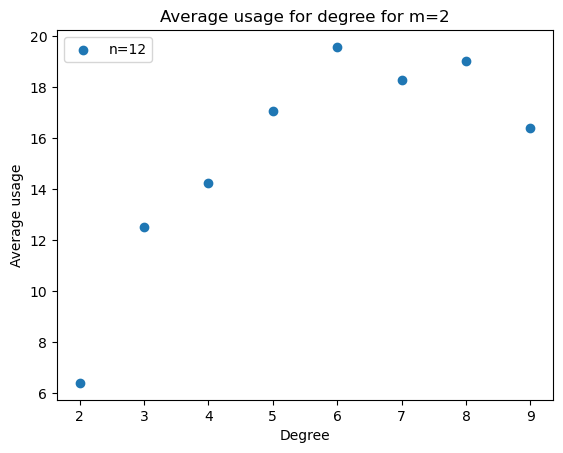

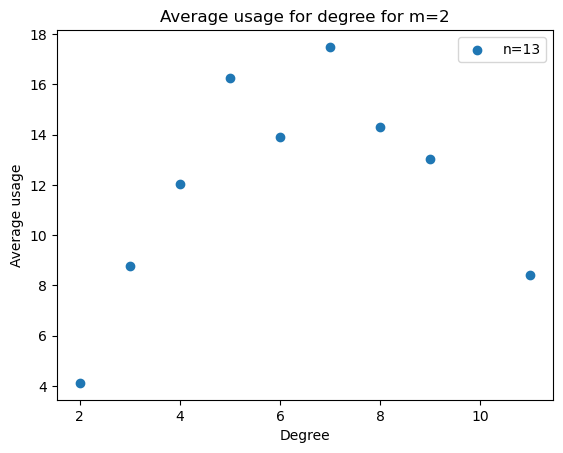

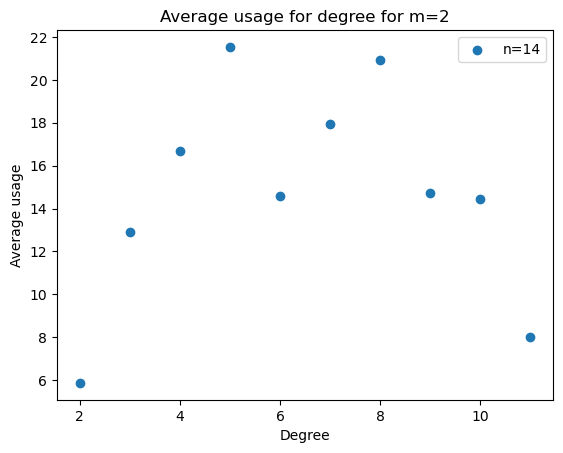

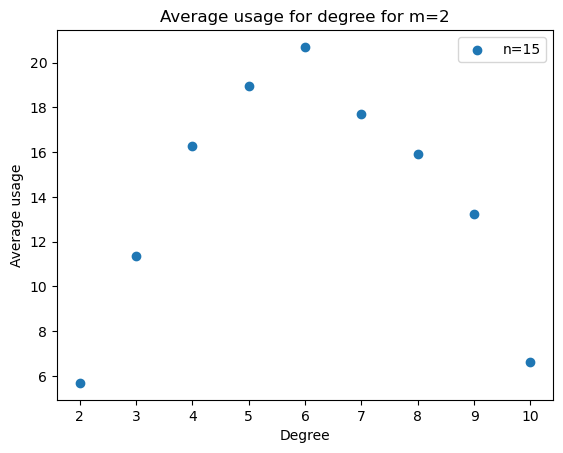

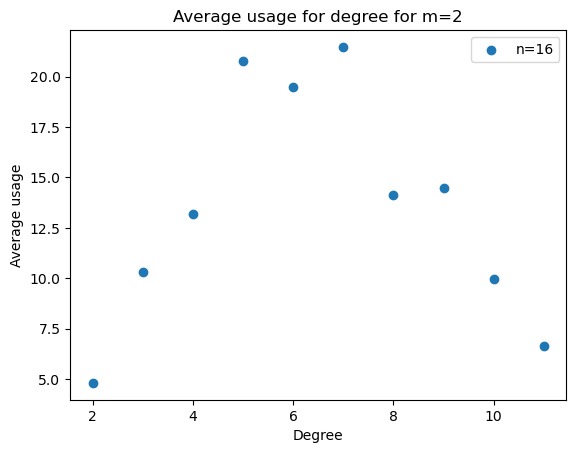

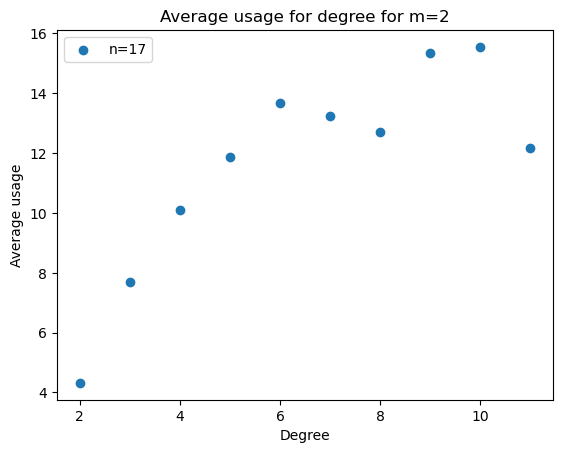

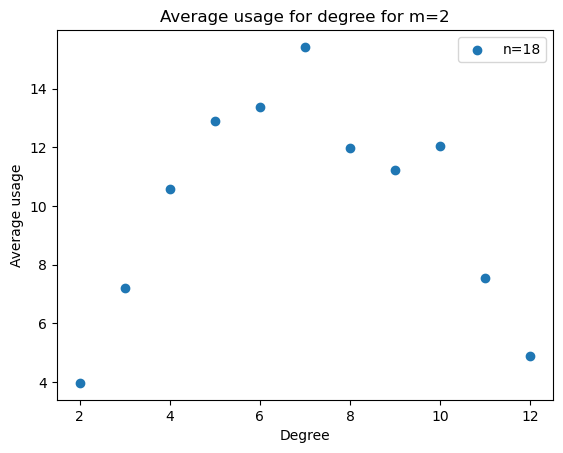

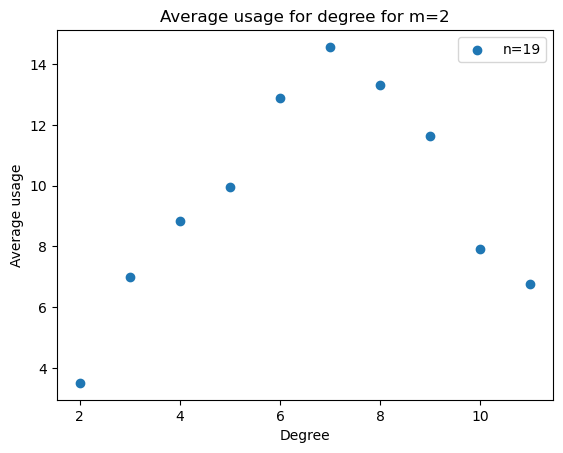

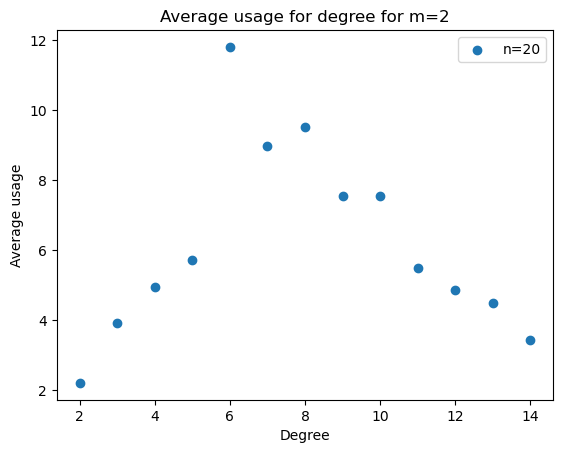

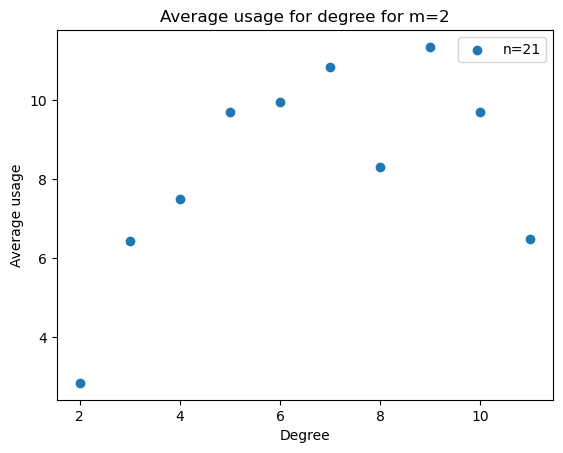

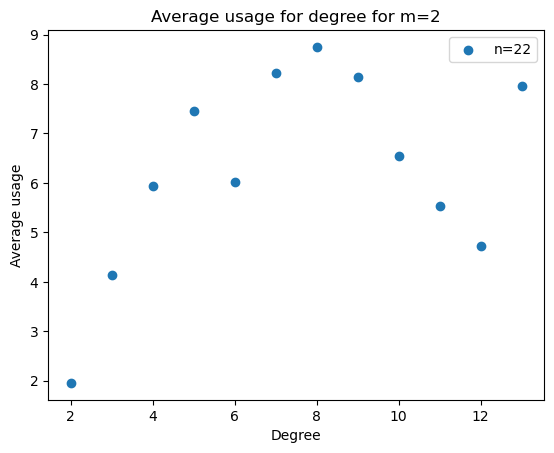

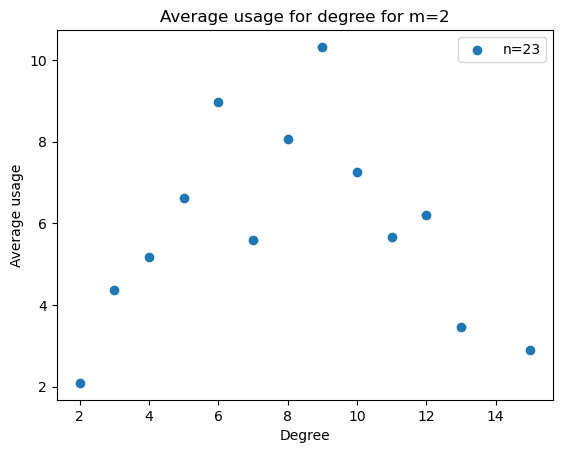

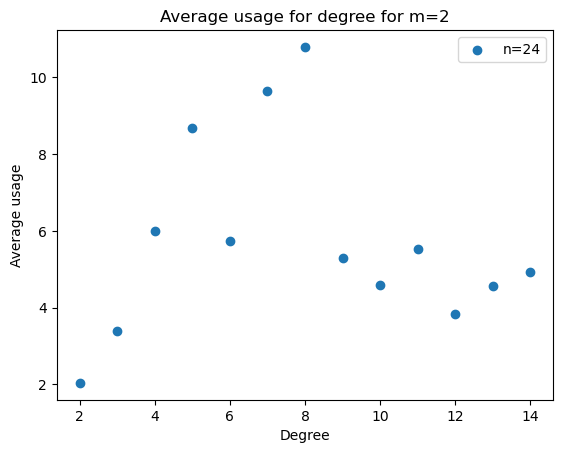

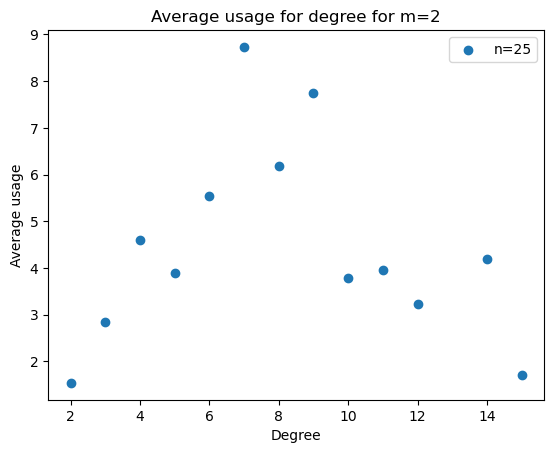

/tmp/ipykernel_7876/3133216028.py:145: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


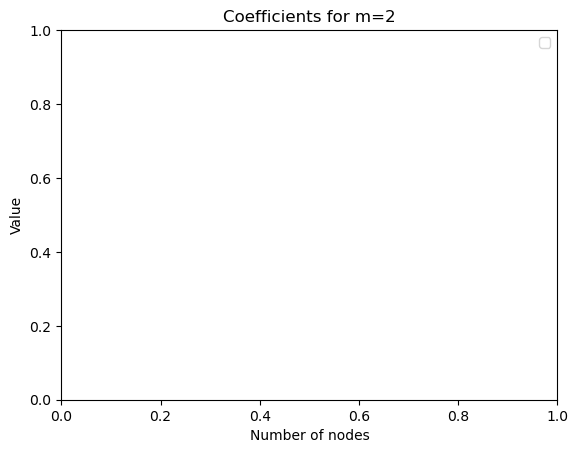

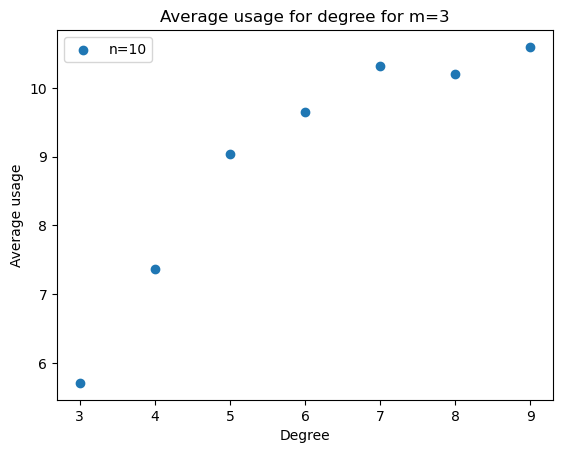

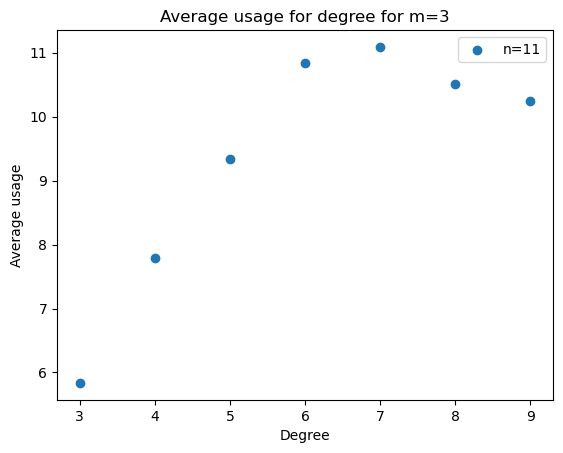

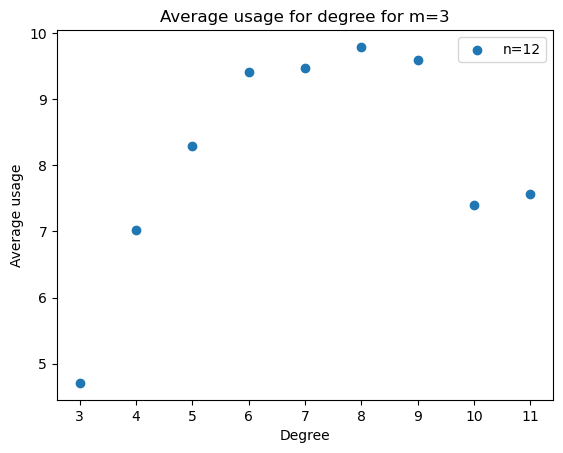

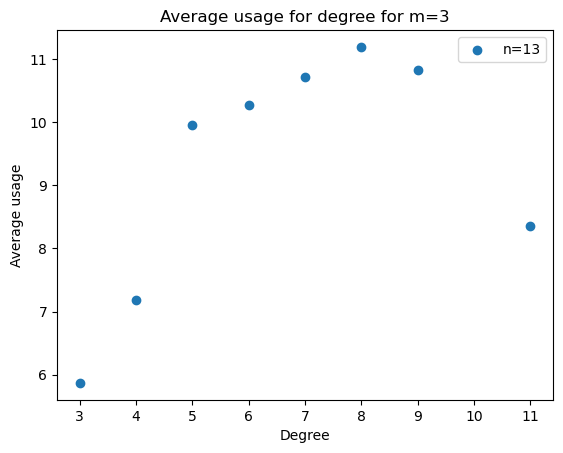

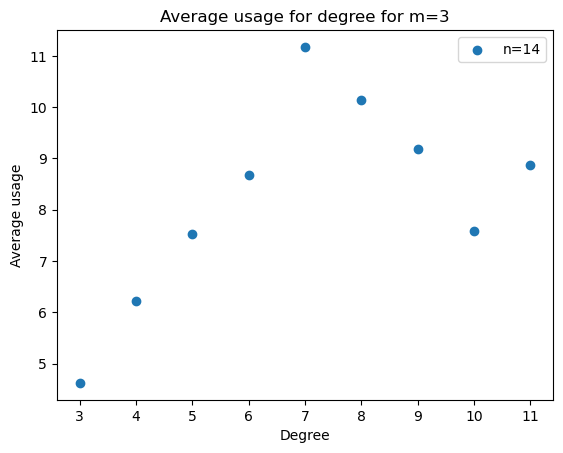

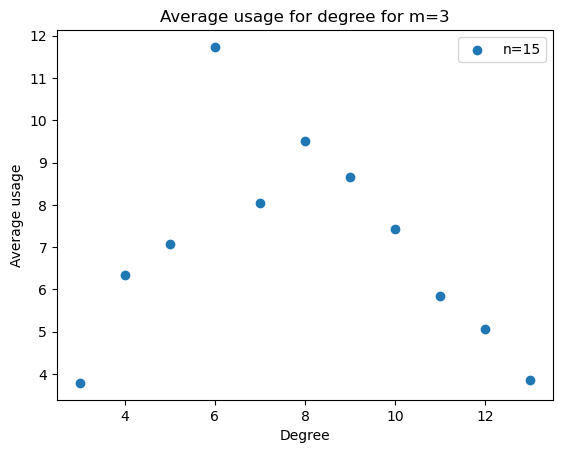

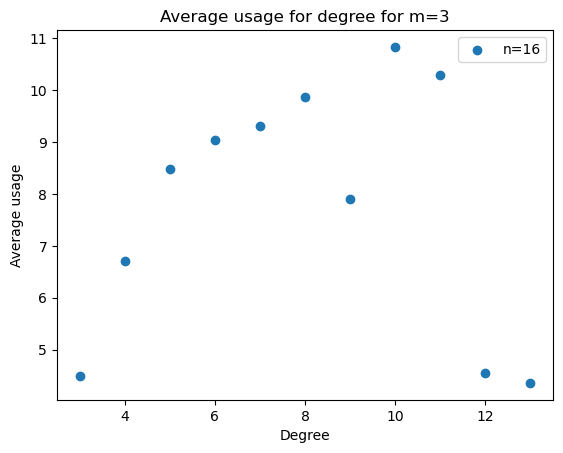

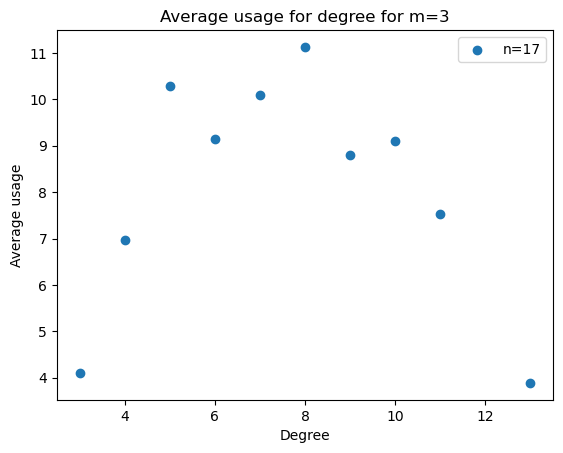

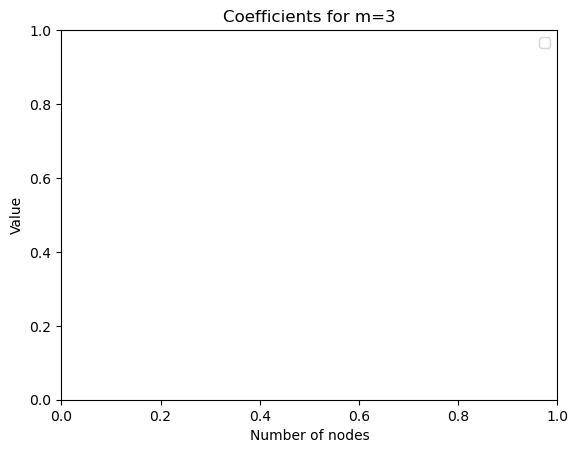

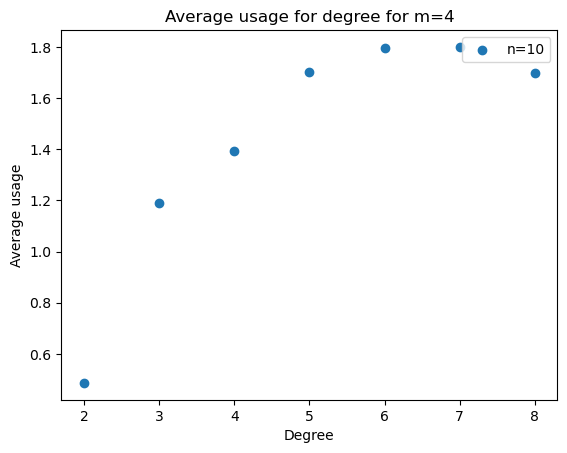

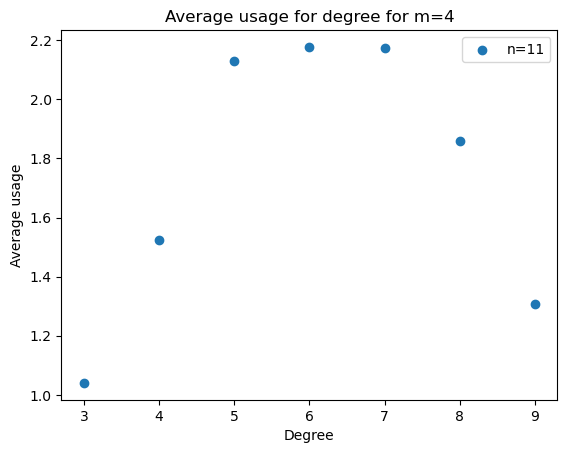

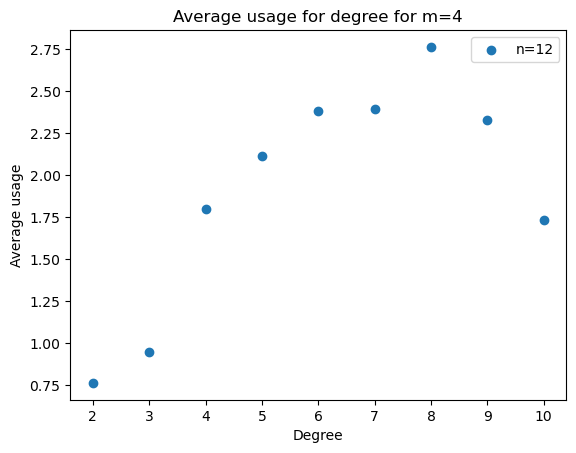

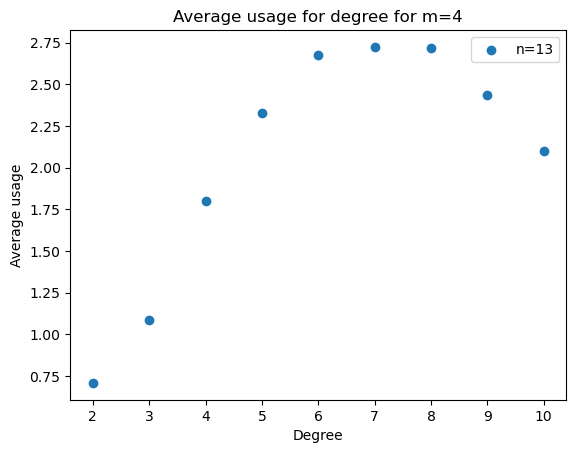

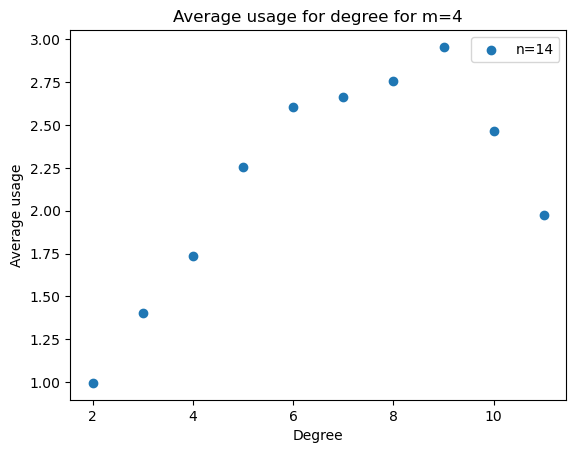

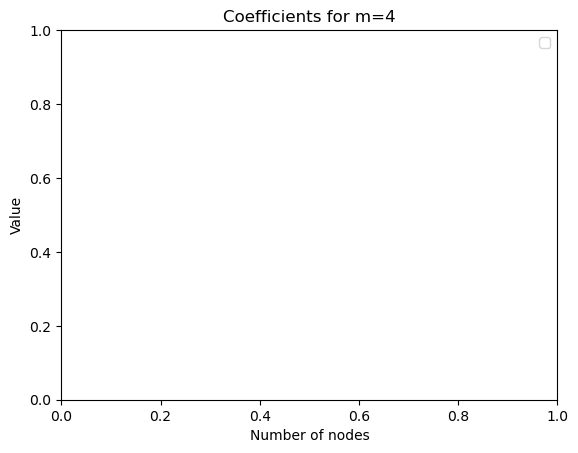

In [ ]:
input_data = {
    2: [3, [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]],
    3: [3, [10, 11, 12, 13, 14, 15, 16, 17]],
    4: [5, [10, 11, 12, 13, 14]]
}

comparison_data = {}

def calculate_degrees(graph, node):
    degree = graph.degree(node)
    neighbors = list(graph.neighbors(node))
    sum_of_neighbor_degrees = sum([graph.degree(neighbor) for neighbor in neighbors])
    neighbors_of_neighbors = set(
        nbr_of_nbr
        for neighbor in neighbors
        for nbr_of_nbr in graph.neighbors(neighbor)
        # if nbr_of_nbr != node
    )
    sum_of_neighbor_neighbors_degrees = sum([graph.degree(neighbor_neighbor) for neighbor_neighbor in neighbors_of_neighbors])

    return degree, sum_of_neighbor_degrees, sum_of_neighbor_neighbors_degrees

def logm(x, m):
    return math.log(x) / math.log(m)

def cluster_coeff(m, n):
    # if n < 1:
    #     return 0
    return (m-1) / 8 * math.log(n)**2 / n

def get_s(n, m):
    return -m ** (0.6 * n)

def get_i(n, m):
    # return m ** (0.9 * n)
    return m ** ((0.9 - cluster_coeff(m, n)) * n)

def coeff_s(s, m, n):
    return logm(-s, m) / n

def coeff_i(i, m, n):
    return logm(i, m) / n

def predict1(n, m, s):
    return m ** (0.9 * n) - m**(0.6 * n) * s

def predict2(n, m, s):
    c = 1 - cluster_coeff(m, n)
    return m ** (c * n) - m**(0.6 * n) * s

def predict3(n, m, s):
    return m ** (0.9 * n) - m**(0.3 * n) * s * n

for m, n0_ns in input_data.items():
    n0, ns = n0_ns
    degree_data = {}
    neighbor_degree_data = {}
    neighbor_neighbor_degree_data = {}

    a_values = []
    b_values = []
    c_values = []

    for n in ns:
        results = pickle.load(open(f'calculation-cache/results_{n0}_{m}_{n}.pkl', 'rb'))
        
        degree_usages = {}
        neighbor_degree_usages = {}
        neighbor_neighbor_degree_usages = {}
        for result in results:
            graph = result[0]
            nodes_usages = {}
            for edge, usage in result[2].items():
                if edge[0] not in nodes_usages:
                    nodes_usages[edge[0]] = 0
                if edge[1] not in nodes_usages:
                    nodes_usages[edge[1]] = 0
                nodes_usages[edge[0]] += usage
                nodes_usages[edge[1]] += usage

            for node, usage in nodes_usages.items():
                degree, neighbor_degree, neighbor_neighbor_degree = calculate_degrees(graph, node)

                if degree not in degree_usages:
                    degree_usages[degree] = []
                degree_usages[degree].append(usage)

                if neighbor_degree not in neighbor_degree_usages:
                    neighbor_degree_usages[neighbor_degree] = []
                neighbor_degree_usages[neighbor_degree].append(usage)

                if neighbor_neighbor_degree not in neighbor_neighbor_degree_usages:
                    neighbor_neighbor_degree_usages[neighbor_neighbor_degree] = []
                neighbor_neighbor_degree_usages[neighbor_neighbor_degree].append(usage)

        x1 = []
        y1 = []
        for degree, usages in degree_usages.items():
            x1.append(degree)
            y1.append(sum(usages) / len(usages))

        x2 = []
        y2 = []
        for degree, usages in neighbor_degree_usages.items():
            x2.append(degree)
            y2.append(sum(usages) / len(usages))
                      
        x3 = []
        y3 = []
        for degree, usages in neighbor_neighbor_degree_usages.items():
            x3.append(degree)
            y3.append(sum(usages) / len(usages))

        def predict(n, m, d):
            return -(d**2) * m ** (0.8 * n) + m**(0.8 * n) * d - m ** (0.8 * n)
        
        y1_preprocess = [y / (m**(0.8*n)) for y in y1]

        # plt.scatter(x1, y1, label=f'n={n}')
        plt.scatter(x1, y1_preprocess, label=f'n={n}')
        # plt.scatter(x1, [predict(n, m, x) for x in x1], label=f'Predicted')
        plt.xlabel('Degree')
        plt.ylabel('Average usage')
        plt.title(f'Average usage for degree for m={m}')
        plt.legend()
        plt.show()
        
        a, b, c = np.polyfit(x1, y1_preprocess, 2)
        a_values.append(a)
        b_values.append(b)
        c_values.append(c)

    # plt.scatter(ns, a_values, label='a')
    # plt.scatter(ns, [-m**(0.7 * n) for n in ns], label='pred')

    # plt.scatter(ns, b_values, label='b')
    # plt.scatter(ns, [m**(0.85 * n) for n in ns], label='pred')

    # plt.scatter(ns, c_values, label='c')
    # plt.scatter(ns, [-m**(0.8 * n) for n in ns], label='pred')

    plt.xlabel('Number of nodes')
    plt.ylabel('Value')
    plt.title(f'Coefficients for m={m}')
    plt.legend()
    plt.show()


In [ ]:
def set_metric(graph):
    centrality = nx.betweenness_centrality(graph)

    graph_with_metrics = nx.Graph()
    for node in graph.nodes():
        graph_with_metrics.add_node(node)

    for edge in graph.edges():
        c = (centrality[edge[0]] * centrality[edge[1]])
        edge_impact = 0
        if graph.degree(edge[0]) > 1:
            edge_impact += c * math.log(1 / (graph.degree(edge[0]) - 1))
        if graph.degree(edge[1]) > 1:
            edge_impact += c * math.log(1 / (graph.degree(edge[1]) - 1))

        graph_with_metrics.add_edge(edge[0], edge[1], metrics={'k33': edge_impact, 'k5': edge_impact})
    
    return graph_with_metrics


graph = generate_graph(5, 100, 3)

embs1 = mst_embeddings_without_weights(graph.copy(), True)
print([len(m.edges()) for m in embs1])

embs2 = mst_embeddings_with_weights(graph.copy(), True, set_metric)
print([len(m.edges()) for m in embs2])

[172, 111, 7]
[175, 107, 8]


In [ ]:
%%script echo skipping 

REPEATS = 10

NEIGHBOURS_NUMBER_LOW = 1
NEIGHBOURS_NUMBER_HIGH = 10
NEIGHBOURS_NUMBER_STEP = 1

INITIAL_NODES = 10
FINAL_NODES_LOW = 100
FINAL_NODES_HIGH = 10500
FINAL_NODES_STEP = 500
EDGES_PER_NODE_LOW = 1
EDGES_PER_NODE_HIGH = 10
EDGES_PER_NODE_STEP = 1

max_deg_data = {}
density_data = {}
for nn in range(NEIGHBOURS_NUMBER_LOW, NEIGHBOURS_NUMBER_HIGH + 1, NEIGHBOURS_NUMBER_STEP):
    print(f'nn = {nn}')
    max_deg_data_per_nn = {}
    density_data_per_nn = {}
    for m in range(EDGES_PER_NODE_LOW, EDGES_PER_NODE_HIGH + 1, EDGES_PER_NODE_STEP):
        print(f'm = {m}')
        graph_size = []
        max_deg = []
        avg_deg = []
        for n in range(FINAL_NODES_LOW, FINAL_NODES_HIGH + 1, FINAL_NODES_STEP):
            max_deg_sum = 0
            avg_deg_sum = 0
            for _ in range(REPEATS):
                graph = generate_graph(INITIAL_NODES, n, m)

                degree_dict = dict(graph.degree())
                top_degree_node = max(degree_dict, key=degree_dict.get)

                nodes_within_k_distance = nx.single_source_shortest_path_length(graph, top_degree_node, cutoff=nn)
                subgraph_nodes = list(nodes_within_k_distance.keys())
                subgraph = graph.subgraph(subgraph_nodes)

                max_deg_sum += graph.degree(top_degree_node)
                avg_deg_sum += (subgraph.number_of_edges() / subgraph.number_of_nodes())
            
            graph_size.append(n)
            max_deg.append(max_deg_sum / REPEATS)
            avg_deg.append(avg_deg_sum / REPEATS)

        max_deg_data_per_nn[m] = {'graph_size': graph_size, 'max_deg': max_deg}
        density_data_per_nn[m] = {'graph_size': graph_size, 'avg_deg': avg_deg}

    max_deg_data[nn] = max_deg_data_per_nn
    density_data[nn] = density_data_per_nn

with open('calculation-cache/neighbour-max-deg.pkl', 'wb') as f:
    pickle.dump(max_deg_data, f)

with open('calculation-cache/neighbour-density.pkl', 'wb') as f:
    pickle.dump(density_data, f)

skipping


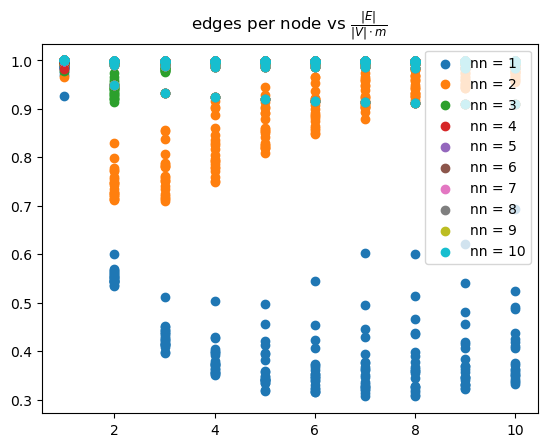

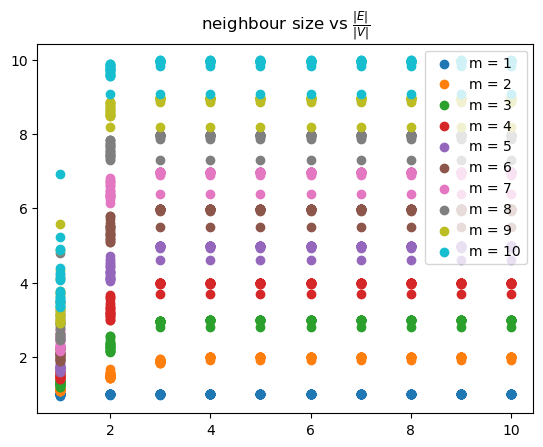

In [ ]:
COLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

with open('calculation-cache/neighbour-max-deg.pkl', 'rb') as f:
    max_deg_data = pickle.load(f)

with open('calculation-cache/neighbour-density.pkl', 'rb') as f:
    density_data = pickle.load(f)

nn_values = list(density_data.keys())
m_values = list(density_data[nn_values[0]].keys())
n_values = density_data[nn_values[0]][m_values[0]]['graph_size']

# for nn in nn_values:
#     for m in m_values:
#         plt.plot(density_data[nn][m]['graph_size'], density_data[nn][m]['avg_deg'], label=f'm = {m}', color=COLORS[m - 1])
#     plt.title(r"$|V_0|$ vs $\frac{|E|}{|V|}$ for neighbour size = " + str(nn))
#     plt.legend()
#     plt.show()

# for nn in nn_values:
#     for m in m_values:
#         edges_number = [n * m for n in density_data[nn][m]['graph_size']]
#         plt.plot(edges_number, density_data[nn][m]['avg_deg'], label=f'm = {m}', color=COLORS[m - 1])
#     plt.title(r"$|E_0|$ vs $\frac{|E|}{|V|}$ for neighbour size = " + str(nn))
#     plt.legend()
#     plt.show()

# for m in m_values:
#     for nn in nn_values:
#         plt.plot(density_data[nn][m]['graph_size'], density_data[nn][m]['avg_deg'], label=f'nn = {nn}', color=COLORS[nn - 1])
#     plt.title(r"$|V_0|$ vs $\frac{|E|}{|V|}$ for edges per node = " + str(m))
#     plt.legend()
#     plt.show()

# for m in m_values:
#     for nn in nn_values:
#         edges_number = [n * m for n in density_data[nn][m]['graph_size']]
#         plt.plot(edges_number, density_data[nn][m]['avg_deg'], label=f'nn = {nn}', color=COLORS[nn - 1])
#     plt.title(r"$|E_0|$ vs $\frac{|E|}{|V|}$ for edges per node = " + str(m))
#     plt.legend()
#     plt.show()

for nn in nn_values:
    x = []
    y = []
    for m in m_values:
        x.extend([m] * len(density_data[nn][m]['avg_deg']))
        y.extend([d/m for d in density_data[nn][m]['avg_deg']])
    plt.scatter(x, y, label=f'nn = {nn}')
plt.title(r"edges per node vs $\frac{|E|}{|V| \cdot m}$")
plt.legend(loc='upper right')
plt.show()

for m in m_values:
    x = []
    y = []
    for nn in nn_values:
        x.extend([nn] * len(density_data[nn][m]['avg_deg']))
        y.extend(density_data[nn][m]['avg_deg'])
    plt.scatter(x, y, label=f'm = {m}')
plt.title(r"neighbour size vs $\frac{|E|}{|V|}$")
plt.legend(loc='upper right')
plt.show()

# nn_vals = []
# m_vals = []
# y_vals = []
# for nn in nn_values:
#     for m in m_values:
#         for i in range(len(density_data[nn][m]['graph_size'])):
#             nn_vals.append(nn)
#             m_vals.append(m)
#             y_vals.append(density_data[nn][m]['avg_deg'][i])

# plt.scatter(m_vals, y_vals)
# plt.title(r"$\frac{|E|}{|V|}$ vs edges per node")
# plt.show()

# plt.scatter(nn_vals, y_vals)
# plt.title(r"$\frac{|E|}{|V|}$ vs neighbour size")
# plt.show()


In [ ]:
%%script echo skipping 

MAX_DEG_X_FUN = lambda nn, m, n, max_deg: n
MAX_DEG_Y_FUN = lambda nn, m, n, max_deg: max_deg / math.sqrt(n)

with open('calculation-cache/neighbour-max-deg.pkl', 'rb') as f:
    max_deg_data = pickle.load(f)

nn_values = list(max_deg_data.keys())
m_values = list(max_deg_data[nn_values[0]].keys())
n_values = max_deg_data[nn_values[0]][m_values[0]]['graph_size']

for nn in nn_values:
    for m in m_values:
        x = []
        y = []
        for i, n in enumerate(n_values):
            x.append(MAX_DEG_X_FUN(nn, m, n, max_deg_data[nn][m]['max_deg'][i]))
            y.append(MAX_DEG_Y_FUN(nn, m, n, max_deg_data[nn][m]['max_deg'][i]))
        plt.scatter(x, y, label=f'm = {m}', color=COLORS[m - 1])
    plt.title(r"$|V_0|$ vs $\frac{max deg}{f{|V|}}$ for neighbour size = " + str(nn))
    plt.legend(loc='lower right')
    plt.show()

skipping


In [ ]:
%%script echo skipping 

DENSITY_X_FUN = lambda nn, m, n, density: n
DENSITY_Y_FUN = lambda nn, m, n, density: density

with open('calculation-cache/neighbour-density.pkl', 'rb') as f:
    density_data = pickle.load(f)

nn_values = list(density_data.keys())
m_values = list(density_data[nn_values[0]].keys())
n_values = density_data[nn_values[0]][m_values[0]]['graph_size']

for nn in nn_values:
    for m in m_values:
        x = []
        y = []
        for i, n in enumerate(n_values):
            x.append(DENSITY_X_FUN(nn, m, n, density_data[nn][m]['avg_deg'][i]))
            y.append(DENSITY_Y_FUN(nn, m, n, density_data[nn][m]['avg_deg'][i]))
        plt.scatter(x, y, label=f'm = {m}', color=COLORS[m - 1])
    plt.title(r"$|V_0|$ vs $\frac{|E|}{|V|} \cdot \frac{1}{f(|V|)}$ for neighbour size = " + str(nn))
    plt.legend()
    plt.show()

skipping


In [ ]:
%%script echo skipping 

REPEATS = 10

N0 = 10
N = 10000
M = 3

NEIGHBOURS_NUMBER_LOW = 1
NEIGHBOURS_NUMBER_HIGH = 3
NEIGHBOURS_NUMBER_STEP = 1

TOP_DEGREES_NUMBER = 50

density_per_degree_data = {}
for nn in range(NEIGHBOURS_NUMBER_LOW, NEIGHBOURS_NUMBER_HIGH + 1, NEIGHBOURS_NUMBER_STEP):
    print(f'nn = {nn}')
    average_density_per_degree = {}
    average_density_per_degree_counter = {}

    for _ in range(REPEATS):
        graph = generate_graph(N0, N, M)
        degree_dict = dict(graph.degree())
        distinct_degrees = sorted(list(set(degree_dict.values())))[::-1][:TOP_DEGREES_NUMBER]

        for distinct_degree in distinct_degrees:
            if not distinct_degree in average_density_per_degree:
                average_density_per_degree[distinct_degree] = 0
                average_density_per_degree_counter[distinct_degree] = 0

            node_with_degree = [node for node in degree_dict if degree_dict[node] == distinct_degree][0]
            nodes_within_k_distance = nx.single_source_shortest_path_length(graph, node_with_degree, cutoff=nn)
            subgraph_nodes = list(nodes_within_k_distance.keys())
            subgraph = graph.subgraph(subgraph_nodes)
            average_density_per_degree[distinct_degree] += (subgraph.number_of_edges() / subgraph.number_of_nodes())
            average_density_per_degree_counter[distinct_degree] += 1

    degrees = []
    densities = []
    for degree in average_density_per_degree:
        degrees.append(degree)
        densities.append(average_density_per_degree[degree] / average_density_per_degree_counter[degree])
    density_per_degree_data[nn] = {'degrees': degrees, 'densities': densities}    

with open('calculation-cache/neighbour-density-per-degree.pkl', 'wb') as f:
    pickle.dump(density_per_degree_data, f)

skipping


In [ ]:
%%script echo skipping 

with open('calculation-cache/neighbour-density-per-degree.pkl', 'rb') as f:
    density_per_degree_data = pickle.load(f)

for nn, serie in density_per_degree_data.items():
    xs = []
    ys = []
    for i, y in enumerate(serie['densities']):
        xs.append(serie['degrees'][i])
        ys.append(y)
    plt.scatter(xs, ys, label=f'nn = {nn}')
plt.legend()
plt.show()

skipping


In [ ]:
%%script echo skipping 

REPEATS = 100

INITIAL_NODES = 10

FINAL_NODES_LOW = 15
FINAL_NODES_HIGH = 450
FINAL_NODES_STEP = 5

EDGES_PER_NODE_LOW = 2
EDGES_PER_NODE_HIGH = 5
EDGES_PER_NODE_STEP = 1

for m in range(EDGES_PER_NODE_LOW, EDGES_PER_NODE_HIGH+1, EDGES_PER_NODE_STEP):
    print(f'm = {m}')
    for n in range(FINAL_NODES_LOW, FINAL_NODES_HIGH+1, FINAL_NODES_STEP):
        print(f'n = {n}')
        for rep in range(REPEATS):
            graph = generate_graph(INITIAL_NODES, n, m)
            max_deg = max(dict(graph.degree()).values())
            is_planar, subgraph = nx.check_planarity(graph, True)
           
            with open(f'calculation-cache/planarity-reports/report_{m}_{n}_{rep}.pkl', 'wb') as f:
                pickle.dump((is_planar, subgraph), f)

skipping


In [ ]:
%%script echo skipping 

REPEATS = 100

INITIAL_NODES = 10

FINAL_NODES_LOW = 15
FINAL_NODES_HIGH = 450
FINAL_NODES_STEP = 5

EDGES_PER_NODE_LOW = 2
EDGES_PER_NODE_HIGH = 5
EDGES_PER_NODE_STEP = 1

def is_k33(graph):
    return nx.is_isomorphic(graph, nx.complete_bipartite_graph(3, 3))

def is_k5(graph):
    return nx.is_isomorphic(graph, nx.complete_graph(5))

def contract(graph):
    contracted_graph = graph.copy()
    nodes_to_contract = [node for node in contracted_graph.nodes if contracted_graph.degree(node) == 2]
    
    while len(nodes_to_contract) > 0:
        for node in nodes_to_contract:
            neighbors = list(contracted_graph.neighbors(node))
            if len(neighbors) == 2:
                u, v = neighbors
                contracted_graph = nx.contracted_nodes(contracted_graph, u, node, self_loops=False)
        
        nodes_to_contract = [node for node in contracted_graph.nodes if contracted_graph.degree(node) == 2]

    return contracted_graph


planarity_data = {}
for m in range(EDGES_PER_NODE_LOW, EDGES_PER_NODE_HIGH+1, EDGES_PER_NODE_STEP):
    print(f'm = {m}')
    planarity_data[m] = {}
    for n in range(FINAL_NODES_LOW, FINAL_NODES_HIGH+1, FINAL_NODES_STEP):
        planarity_data[m][n] = {'planar': 0, 'non-planar-k5': 0, 'non-planar-k33': 0}
        for rep in range(REPEATS):
            with open(f'calculation-cache/planarity-reports/report_{m}_{n}_{rep}.pkl', 'rb') as f:
                (is_planar, subgraph) = pickle.load(f)

            if is_planar:
                planarity_data[m][n]['planar'] += 1
            else:
                contracted_subgraph = contract(subgraph)
                if is_k33(contracted_subgraph):
                    planarity_data[m][n]['non-planar-k33'] += 1
                elif is_k5(contracted_subgraph):
                    planarity_data[m][n]['non-planar-k5'] += 1
                else:
                    print('ERROR: ', f'calculation-cache/planarity-reports/report_{m}_{n}_{rep}.pkl')
                
with open('calculation-cache/planarity-analysis.pkl', 'wb') as f:
    pickle.dump(planarity_data, f)

skipping


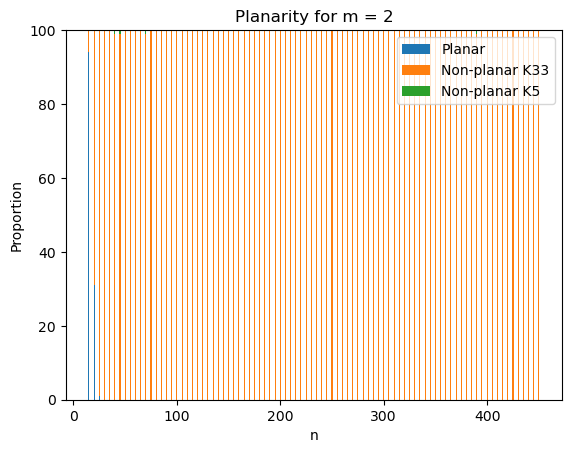

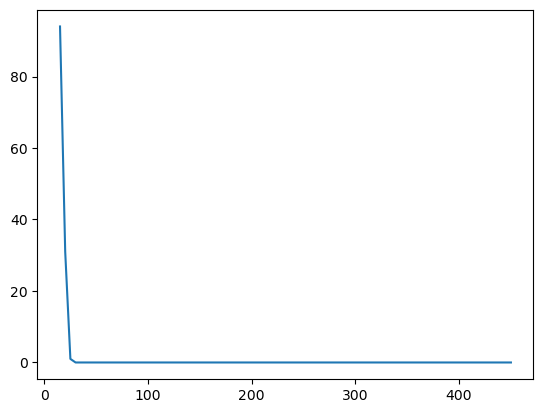

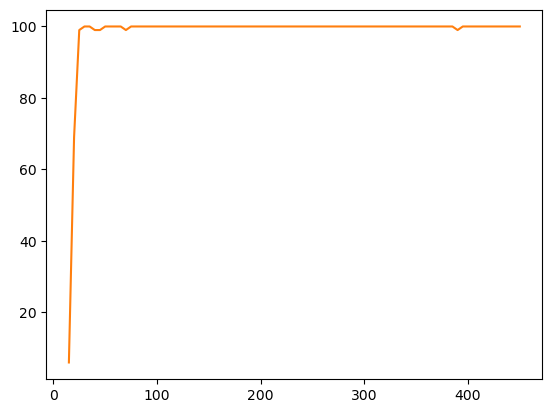

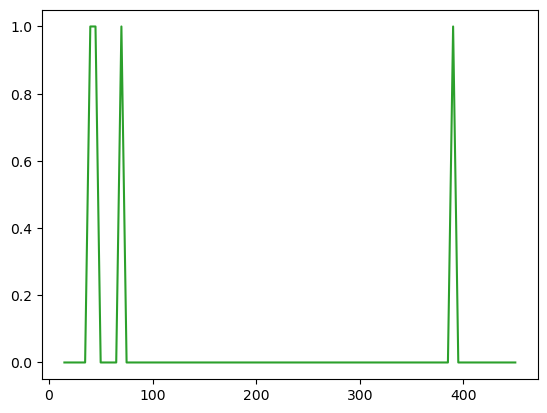

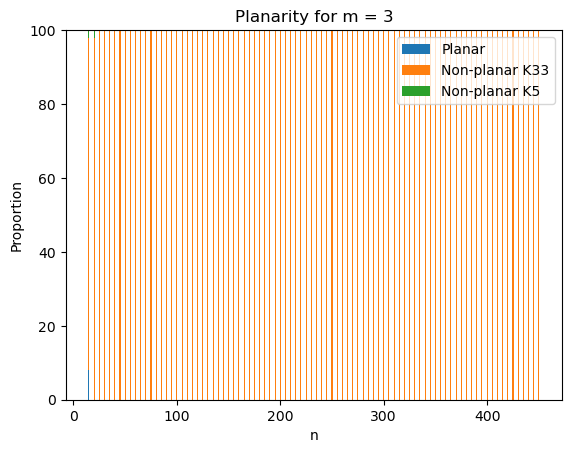

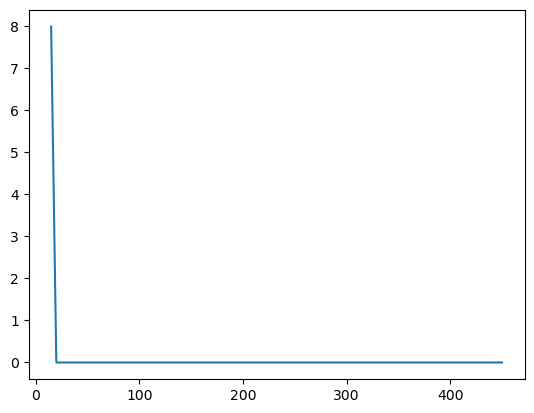

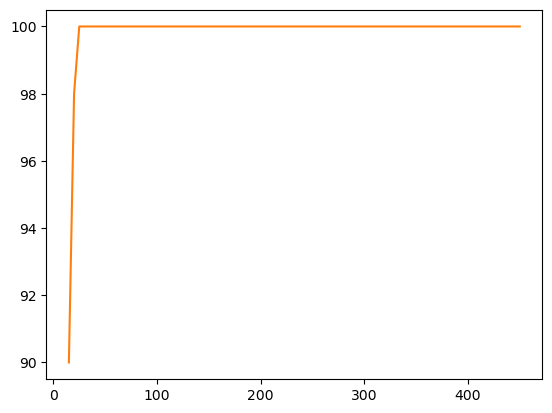

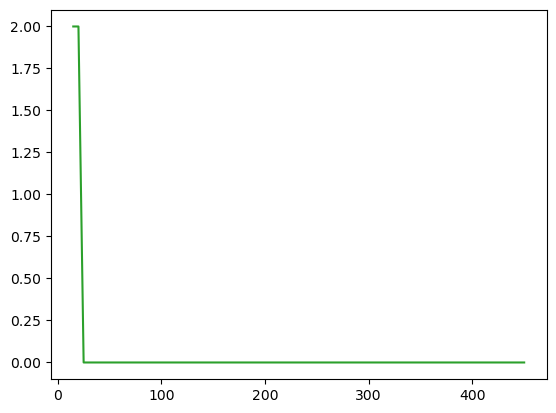

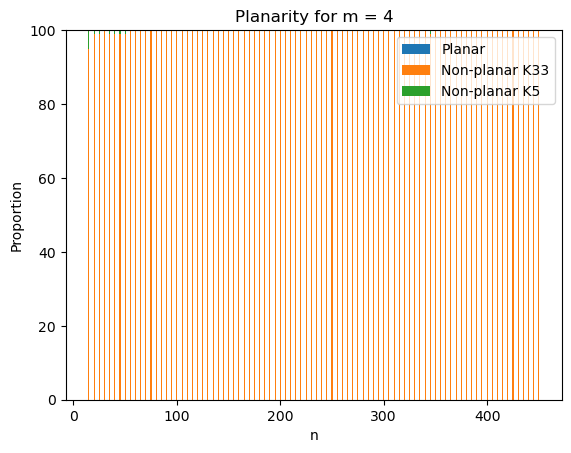

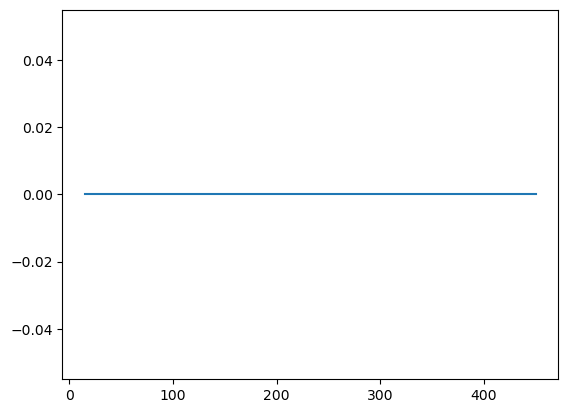

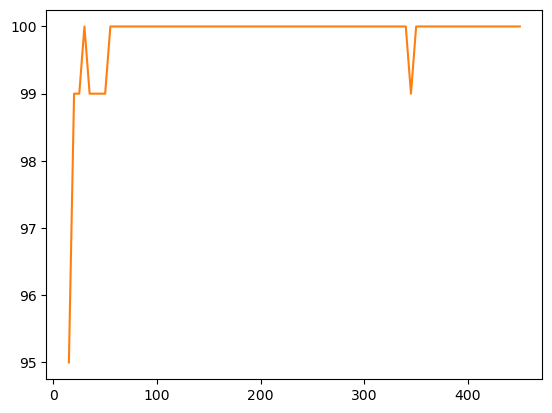

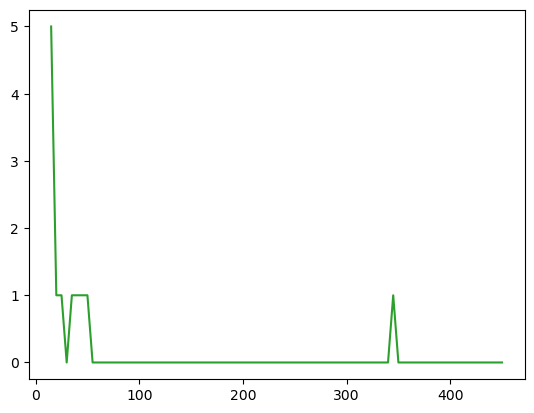

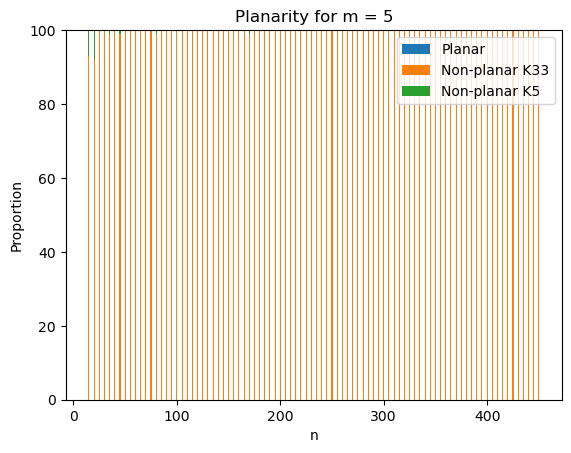

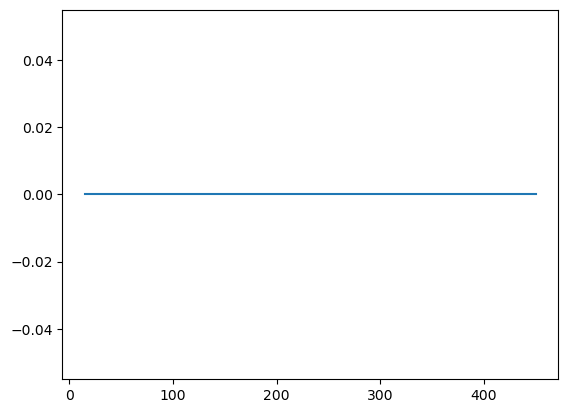

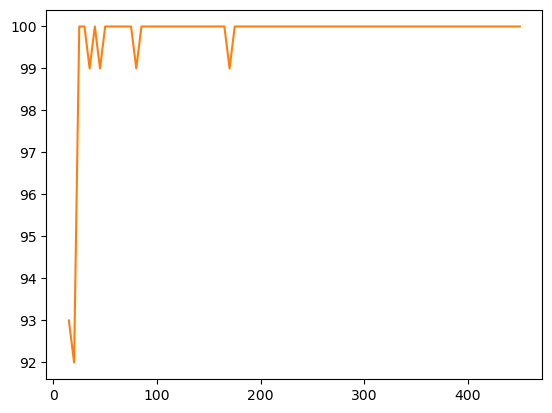

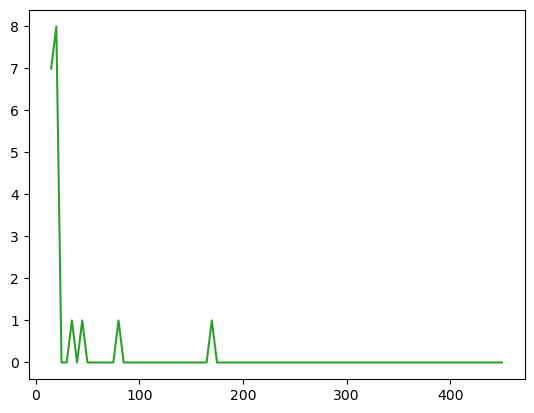

In [ ]:
COLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

with open('calculation-cache/planarity-analysis.pkl', 'rb') as f:
    planarity_data = pickle.load(f)

for m, data in planarity_data.items():
    x = []
    y_planar = []
    y_non_planar_k5 = []
    y_non_planar_k33 = []
    for n, serie in data.items():
        if n < 500:
            x.append(n)
            y_planar.append(serie['planar'])
            y_non_planar_k5.append(serie['non-planar-k5'])
            y_non_planar_k33.append(serie['non-planar-k33'])
            s = serie['planar'] + serie['non-planar-k5'] + serie['non-planar-k33']
    
    fig, ax = plt.subplots()

    bar_width = 1

    series1 = np.array(y_planar)
    series2 = np.array(y_non_planar_k33)
    series3 = np.array(y_non_planar_k5)

    bottom2 = series1
    bottom3 = series1 + series2

    ax.bar(x, series1, bar_width, label='Planar', color=COLORS[0])
    ax.bar(x, series2, bar_width, bottom=bottom2, label='Non-planar K33', color=COLORS[1])
    ax.bar(x, series3, bar_width, bottom=bottom3, label='Non-planar K5', color=COLORS[2])

    ax.set_xlabel('n')
    ax.set_ylabel('Proportion')
    ax.set_title(f"Planarity for m = {m}")
    ax.legend()
    plt.show()


    plt.plot(x, y_planar, color=COLORS[0])
    plt.show()

    plt.plot(x, y_non_planar_k33, color=COLORS[1])
    plt.show()

    plt.plot(x, y_non_planar_k5, color=COLORS[2])

In [ ]:
%%script echo skipping 

REPEATS = 10

INITIAL_NODES = 10

FINAL_NODES_LOW = 15
FINAL_NODES_HIGH = 100
FINAL_NODES_STEP = 1

EDGES_PER_NODE_LOW = 1
EDGES_PER_NODE_HIGH = 5
EDGES_PER_NODE_STEP = 1

K5 = nx.complete_graph(5)
K33 = nx.complete_bipartite_graph(3, 3)

def find_5_node_cliques(G):
    cliques = []
    for nodes in nx.find_cliques(G):
        if len(nodes) == 5:
            cliques.append(G.subgraph(nodes))
    return cliques

def find_3_full_bipartite(G):
    matcher = nx.isomorphism.GraphMatcher(G, K33)
    K33_subgraphs = []
    
    for subgraph in matcher.subgraph_isomorphisms_iter():
        K33_subgraphs.append(nx.subgraph(G, subgraph.keys()))
    
    return K33_subgraphs

def is_k5_homeomorphic(graph):
    contracted_graph = graph.copy()
    nodes_to_contract = [node for node in contracted_graph.nodes() if contracted_graph.degree(node) == 2]

    for node in nodes_to_contract:
        neighbors = list(contracted_graph.neighbors(node))
        if len(neighbors) == 2:
            u, v = neighbors[0], neighbors[1]
            if contracted_graph.has_edge(u, v):
                contracted_graph.remove_edge(u, node)
                contracted_graph.remove_edge(node, v)
            else:
                contracted_graph.add_edge(u, v)
                contracted_graph.remove_node(node)

    return len(find_5_node_cliques(contracted_graph)) > 0

def is_k33_homeomorphic(graph):
    contracted_graph = graph.copy()
    nodes_to_contract = [node for node in contracted_graph.nodes() if contracted_graph.degree(node) == 2]

    for node in nodes_to_contract:
        neighbors = list(contracted_graph.neighbors(node))
        if len(neighbors) == 2:
            u, v = neighbors[0], neighbors[1]
            if contracted_graph.has_edge(u, v):
                contracted_graph.remove_edge(u, node)
                contracted_graph.remove_edge(node, v)
            else:
                contracted_graph.add_edge(u, v)
                contracted_graph.remove_node(node)

        
    return len(find_3_full_bipartite(contracted_graph)) > 0

planarity_data = {}
for m in range(EDGES_PER_NODE_LOW, EDGES_PER_NODE_HIGH+1, EDGES_PER_NODE_STEP):
    print(f'm = {m}')
    planarity_data[m] = {
        'size': {},
        'max_deg': {}
    }
    for n in range(FINAL_NODES_LOW, FINAL_NODES_HIGH+1, FINAL_NODES_STEP):
        print(f'n = {n}')
        planarity_data[m]['size'][n] = {'planar': 0, 'non-planar-k5': 0, 'non-planar-k33': 0}
        for _ in range(REPEATS):
            graph = generate_graph(INITIAL_NODES, n, m)
            max_deg = max(dict(graph.degree()).values())
            is_planar, subgraph = nx.check_planarity(graph, True)
            if not max_deg in planarity_data[m]['max_deg']:
                planarity_data[m]['max_deg'][max_deg] = {'planar': 0, 'non-planar-k5': 0, 'non-planar-k33': 0}

            if is_planar:
                planarity_data[m]['size'][n]['planar'] += 1
                planarity_data[m]['max_deg'][max_deg]['planar'] += 1
            else:
                if is_k5_homeomorphic(subgraph):
                    planarity_data[m]['size'][n]['non-planar-k5'] += 1
                    planarity_data[m]['max_deg'][max_deg]['non-planar-k5'] += 1

                if is_k33_homeomorphic(subgraph):
                    planarity_data[m]['size'][n]['non-planar-k33'] += 1
                    planarity_data[m]['max_deg'][max_deg]['non-planar-k33'] += 1


with open('calculation-cache/planarity.pkl', 'wb') as f:
    pickle.dump(planarity_data, f)

skipping


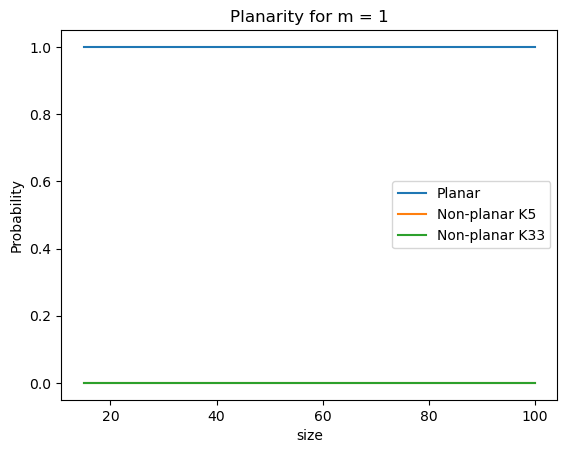

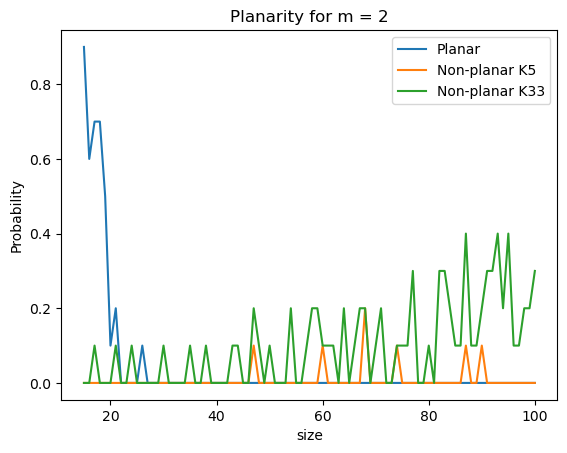

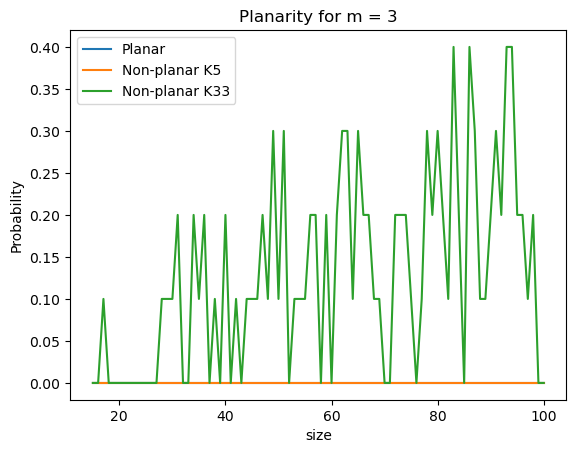

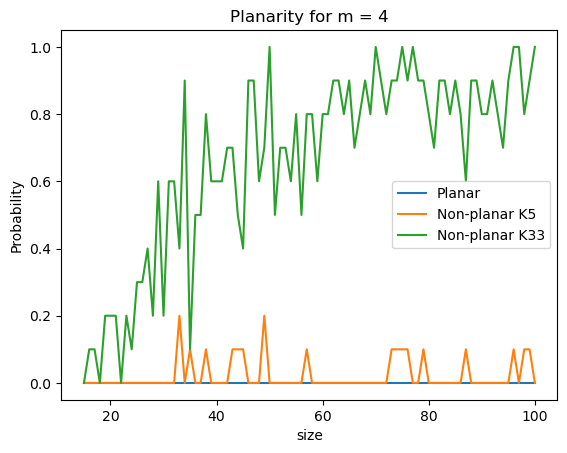

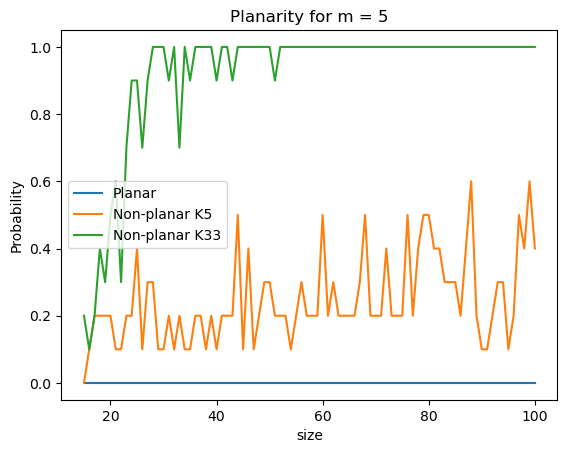

In [ ]:
COLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
X_PARAM = 'size'
REPEATS = 10

with open('calculation-cache/planarity.pkl', 'rb') as f:
    planarity_data = pickle.load(f)

for m, data in planarity_data.items():
    x = []
    y_planar = []
    y_non_planar_k5 = []
    y_non_planar_k33 = []
    for n, serie in data[X_PARAM].items():
        x.append(n)
        y_planar.append(serie['planar'] / REPEATS)
        y_non_planar_k5.append(serie['non-planar-k5'] / REPEATS)
        y_non_planar_k33.append(serie['non-planar-k33'] / REPEATS)
        s = serie['planar'] + serie['non-planar-k5'] + serie['non-planar-k33']
    
    plt.plot(x, [y for y in y_planar], label='Planar', color=COLORS[0])
    plt.plot(x, [y for y in y_non_planar_k5], label='Non-planar K5', color=COLORS[1])
    plt.plot(x, [y for y in y_non_planar_k33], label='Non-planar K33', color=COLORS[2])
    plt.title(f"Planarity for m = {m}")
    plt.xlabel(X_PARAM)
    plt.ylabel("Probability")
    plt.legend()
    plt.show()

In [ ]:
def has_cycle_of_length_n(graph, n):
    def dfs(node, visited, path):
        visited.add(node)
        path.append(node)

        if len(path) > n:
            visited.remove(node)
            path.pop()
            return False

        for neighbor in graph.get(node, []):
            if neighbor == path[0] and len(path) == n:
                return True
            if neighbor not in visited:
                if dfs(neighbor, visited, path):
                    return True

        visited.remove(node)
        path.pop()
        return False

    for node in graph:
        if dfs(node, set(), []):
            return True

    return False

def has_clique_of_size_n(graph, n):
    if len(graph.keys()) != n:
        return False
    
    for _, value in graph.items():
        if len(value) != n-1:
            return False
        
    return True

def has_complete_bipartite_of_size_n(graph, n):
    for node in graph:
        if len(graph[node]) != n//2:
            return False
        
    G = nx.Graph()
    for node, neighbors in graph.items():
        for neighbor in neighbors:
            G.add_edge(node, neighbor)

    return nx.bipartite.is_bipartite(G)

def count_in_out_degrees_(graph):
    in_degrees = {node: 0 for node in graph}
    out_degrees = {node: 0 for node in graph}
    for node, neighbors in graph.items():
        in_degrees[node] = len([n for n in neighbors if n > node])
        out_degrees[node] = len([n for n in neighbors if n < node])

    return in_degrees, out_degrees

def find_combinations_with_repeats_(target):
    def backtrack(start, path, target):
        if target == 0:
            if len(path) > 0:
                result.append(path)
            return
        for i in range(start, target + 1):
            if i > target:
                break
            backtrack(i, path + [i], target - i)
    
    result = []
    backtrack(1, [], target)
    return result

def find_posibilities_(in_degrees, out_degrees):
    posibilities = {}
    for key in in_degrees.keys():
        posibilities[key] = {}
        posibilities[key]['out'] = ''.join([f'(m-{k})' if k != 0 else 'm' for k in range(out_degrees[key])])
        
    for key, value in in_degrees.items():
        all_combinations = find_combinations_with_repeats_(value)
        
        posibilities[key]['in'] = []
        for comb in all_combinations:
            factor = ''.join([f'(m-{k})' if k != 0 else 'm' for k in range(len(comb))])
            coeff = math.factorial(len(comb))
            for k in set(comb):
                coeff //= math.factorial(comb.count(k))
            if coeff != 1:
                posibilities[key]['in'].append((str(coeff) + factor, comb))
            else:
                posibilities[key]['in'].append((str(factor), comb))
            print('--> ', key, ': ', comb, ' = ', str(coeff) + factor)

    return posibilities


def count_(V, E, check):
    groups = [
        [chr(ord('A') + i)] for i in range(V)
    ]

    group_pairs = list(combinations(range(len(groups)), 2))

    all_edges = []
    for (i, j) in group_pairs:
        for node1, node2 in product(groups[i], groups[j]):
            all_edges.append((node1, node2))

    sorted_all_edges = []
    for edge in all_edges:
        if edge[0][0] > edge[1][0]:
            sorted_all_edges.append(edge)
        else:
            sorted_all_edges.append((edge[1], edge[0]))

    edges_groups = list(combinations(sorted_all_edges, E))

    counter = 0
    for group in edges_groups:
        graph = {chr(ord('A') + i) : [] for i in range(V)}
        for edge in group:
            e1 = edge[0][0]
            e2 = edge[1][0]
            graph[e1].append(e2)
            graph[e2].append(e1)

        if check(graph, V):
            counter += 1
            print(count_in_out_degrees_(graph))
            print(find_posibilities_(*count_in_out_degrees_(graph)))
            for key, values in find_posibilities_(*count_in_out_degrees_(graph)).items():
                value_out = values['out']
                values_in = values['in']
                if len(values_in) == 0:
                    values_in = [('', '[]')]
                for value_in in values_in:
                    print(key + ': ' + value_in[0] + value_out + ': ' + str(value_in[1]))
    
    print(counter)
    print()

# count_(3, 3, has_cycle_of_length_n)
# count_(4, 4, has_cycle_of_length_n)
# count_(5, 10, has_clique_of_size_n)
# count_(6, 9, has_complete_bipartite_of_size_n)

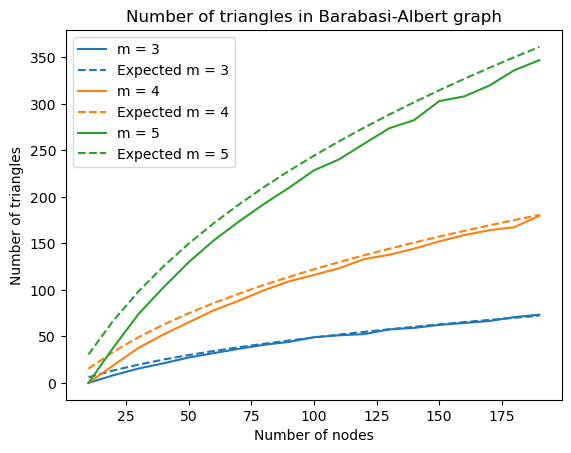

In [ ]:
COLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
RECALCULATE = False

import math

def k3_expected_number(n, m):
    return (m-1) * m * (m+1) * math.log(n)**3 / 48

for m in [3, 4, 5]:
    if RECALCULATE:
        x = []
        y = []
        for n in range(10, 200, 10):
            print(n)
            n_sum = 0
            for _ in range(1000):
                G = generate_graph(10, n, m)
                triangles = nx.triangles(G)
                total_triangles = sum(triangles.values()) // 3
                n_sum += total_triangles
            x.append(n)
            y.append(n_sum / 1000)
        pickle.dump((x, y), open(f'calculation-cache/k3_data_m_{m}.pkl', 'wb'))
    else:
        x, y = pickle.load(open(f'calculation-cache/k3_data_m_{m}.pkl', 'rb'))
    
    exp_y = [k3_expected_number(n, m) for n in x]
    plt.plot(x, y, label=f'm = {m}', linestyle='-', color=COLORS[m - 3])
    plt.plot(x, exp_y, label=f'Expected m = {m}', linestyle='--', color=COLORS[m - 3])
plt.title("Number of triangles in Barabasi-Albert graph")
plt.xlabel("Number of nodes")
plt.ylabel("Number of triangles")
plt.legend()
plt.show()

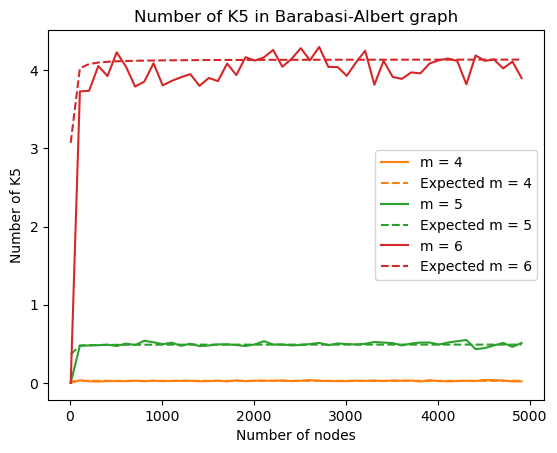

In [54]:
COLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
RECALCULATE = False

import pickle
from matplotlib import pyplot as plt

def harmonic_number(m, n):
    s = 0
    for i in range(1, n+1):
        s += 1 / i**m
    return s

def k5_expected_number(n, m):
    return (m**2-9) * (m**2-4)**2 * (m**2-1)**3 / m**2 / 14745600 * harmonic_number(2, n)**5 / 6.5
    # return (m**2-9) * (m**2-4)**2 * (m**2-1)**3 / m**2 * zeta(2) / 122880 / math.factorial(5) 

for m in [4, 5, 6]:
    if RECALCULATE:
        x = []
        y = []
        for n in range(10, 5000, 100):
            print(n)
            n_sum = 0
            for _ in range(100):
                G = generate_graph(10, n, m)
                cliques = nx.find_cliques(G)
                k5_cliques = [clique for clique in cliques if len(clique) == 5]
                n_sum += len(k5_cliques)
            x.append(n)
            y.append(n_sum / 100)
        pickle.dump((x, y), open(f'calculation-cache/k5_data_m_{m}.pkl', 'wb'))
    else:
        x, y = pickle.load(open(f'calculation-cache/k5_data_m_{m}.pkl', 'rb'))
        
    exp_y = [k5_expected_number(n, m) for n in x]
    plt.plot(x, y, label=f'm = {m}', linestyle='-', color=COLORS[m - 3])
    plt.plot(x, exp_y, label=f'Expected m = {m}', linestyle='--', color=COLORS[m - 3])
plt.title("Number of K5 in Barabasi-Albert graph")
plt.xlabel("Number of nodes")
plt.ylabel("Number of K5")
plt.legend()
plt.show()

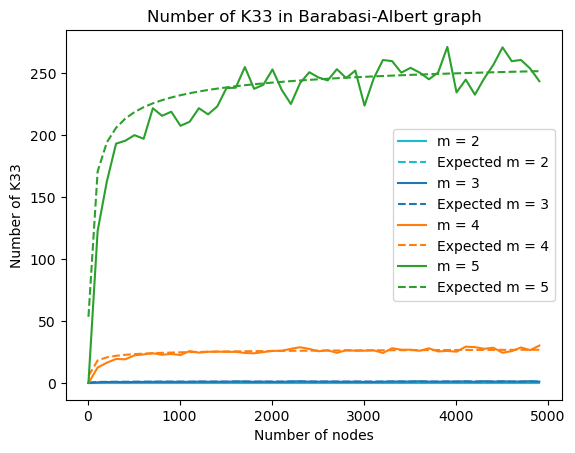

In [55]:
COLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
RECALCULATE = False

def harmonic_number(m, n):
    s = 0
    for i in range(1, n+1):
        s += 1 / i**m
    return s

def count_complete_bipartite_subgraphs(graph, k):
    cnt = 0
    for nodes in combinations(graph.nodes, k-1):
        neighbors = set(graph.neighbors(nodes[0]))
        for node in nodes[1:]:
            neighbors.intersection_update(graph.neighbors(node))
        neighbors.difference_update(nodes)

        if len(neighbors) >= k:
            for node in graph.nodes():
                if node <= nodes[-1]:
                    continue
                new_nodes = nodes + (node,)
                if len(set(new_nodes)) != k:
                    continue
                new_neighbors = neighbors.intersection(graph.neighbors(node))
                new_neighbors.difference_update(new_nodes)

                if len(new_neighbors) >= k:
                    cnt += math.comb(len(new_neighbors), k)

    return cnt // 2

# def count_complete_bipartite_subgraphs(graph, k):
#     cnt = 0
#     for nodes in combinations(graph.nodes, k):
#         neighbors = set(graph.neighbors(nodes[0]))
#         for node in nodes[1:]:
#             neighbors.intersection_update(graph.neighbors(node))
#         neighbors.difference_update(nodes)

#         if len(neighbors) >= k:
#             cnt += math.comb(len(neighbors), k)

#     return cnt // 2

def k33_expected_number(n, m):
    return (m-2) * (m+2) * (m**2-2) * (m**2-1)**2 * (5*m**4 - 5*m**2 + 4) / m**3 * harmonic_number(1.5, n)**6 / 2211840 / math.sqrt(5) / 1.6

for m in [2, 3, 4, 5]:
    if RECALCULATE:
        x = []
        y = []
        for n in range(10, 5000, 100):
            print(n)
            n_sum = 0
            for _ in range(100):
                G = generate_graph(10, n, m)
                n_sum += count_complete_bipartite_subgraphs(G, 3)
                
            x.append(n)
            y.append(n_sum / 100)
        pickle.dump((x, y), open(f'calculation-cache/k33_data_m_{m}.pkl', 'wb'))
    else:
        x, y = pickle.load(open(f'calculation-cache/k33_data_m_{m}.pkl', 'rb'))

    exp_y = [k33_expected_number(n, m) for n in x]
    plt.plot(x, y, label=f'm = {m}', linestyle='-', color=COLORS[m - 3])
    plt.plot(x, exp_y, label=f'Expected m = {m}', linestyle='--', color=COLORS[m - 3])
plt.title("Number of K33 in Barabasi-Albert graph")
plt.xlabel("Number of nodes")
plt.ylabel("Number of K33")
plt.legend()
plt.show()

In [56]:
# calculate standard deviation
data = {}
for m in [3, 4, 5]:
    x, y = pickle.load(open(f'calculation-cache/k33_data_m_{m}.pkl', 'rb'))
    for xs, ys in zip(x, y):
        if not xs in data:
            data[xs] = []
        data[xs].append(ys)
        data[xs].append(abs(ys - k33_expected_number(xs, m))/1)

with open('std-k33.txt', 'w') as f:
    f.write('n s1 err1 s2 err2 s3 err3\n')
    for xs in data:
        f.write(f'{xs} ')
        for ys in data[xs]:
            f.write(f'{ys} ')
        f.write('\n')

data = {}
for m in [4, 5, 6]:
    x, y = pickle.load(open(f'calculation-cache/k5_data_m_{m}.pkl', 'rb'))
    for xs, ys in zip(x, y):
        if not xs in data:
            data[xs] = []
        data[xs].append(ys)
        data[xs].append(abs(ys - k5_expected_number(xs, m))/1)

with open('std-k5.txt', 'w') as f:
    f.write('n s1 err1 s2 err2 s3 err3\n')
    for xs in data:
        f.write(f'{xs} ')
        for ys in data[xs]:
            f.write(f'{ys} ')
        f.write('\n')

In [ ]:
# Testing correspendence between G(n, m) and G(n*m, 1)

def generate_g1_nm(n0, n, m, colors=None):
    fn = n0 + (n - n0) * m
    graph = generate_graph(n0, fn, 1)

    if colors != None:
        color_index = 0
        for i in range(n0):
            graph.nodes[i]['color'] = colors[color_index]
        color_index += 1
        
        for i in range(n0, fn, m):
            for j in range(m):
                graph.nodes[i + j]['color'] = colors[color_index]
            color_index += 1

    return graph

def fold_g1_nm_to_gm_n(graph, n0, n, m):
    def convert(i):
        return i if i < n0 else n0 + (i - n0) // m

    new_graph = nx.Graph()
    
    fn = n0 + (n - n0) * m
    for i in range(n0):
        new_graph.add_node(i)
        new_graph.nodes[i]['color'] = graph.nodes[i]['color']

    for i in range(n0, fn, m):
        for j in range(m):
            old_id = i + j
            new_id = convert(i)
            
        new_graph.add_node(new_id)
        new_graph.nodes[new_id]['color'] = graph.nodes[old_id]['color']


    converted_edges = [(convert(u), convert(v)) for (u, v) in graph.edges()]
    converted_edges = [(u,v) if u > v else (v,u) for (u,v) in converted_edges]
    initial_edges = [(u,v) for (u,v) in converted_edges if u < n0 and v < n0]
    rest_nodes = [(u,v) for (u,v) in converted_edges if u >= n0 or v >= n0]
    rest_nodes = sorted(rest_nodes, key=lambda x: (x[0], x[1]))

    for u,v in initial_edges:
        new_graph.add_edge(u,v)

    for u,v in rest_nodes:
        new_graph.add_edge(u,v)

    return new_graph
    

# N0 = 10
# N = 100
# M = 5

# colors = ['#000000'] + generate_colors(N - N0, 2)
# initial_graph = generate_g1_nm(N0, N, M, colors)
# merged_graph = fold_g1_nm_to_gm_n(initial_graph, N0, N, M)

# draw_graph(initial_graph)
# draw_graph(merged_graph)

In [ ]:
def generate_gm_n(n0, n, m, colors=None):
    if (n - n0) % m != 0:
        raise ValueError("n - n0 must be divisible by m")
    
    graph = generate_graph(n0, n, m)

    if colors != None:
        color_index = 0
        for i in range(n0):
            graph.nodes[i]['color'] = colors[color_index]
        color_index += 1
        for i in range(n0, n):
            graph.nodes[i]['color'] = colors[color_index]
            color_index += 1

    return graph


def unfold_gm_n_to_g1_nm(graph, n0, n, m):
    new_graph = nx.Graph()

    nodes_translation = {}
    
    for i in range(n0):
        new_graph.add_node(i)
        new_graph.nodes[i]['color'] = graph.nodes[i]['color']
        
    for i in range(n0, n):
        for j in range(n0 + m * (i - n0), n0 + m * (i - n0 + 1)):
            new_graph.add_node(j)
            new_graph.nodes[j]['color'] = graph.nodes[i]['color']

    edges_with_endpoints_less_than_n0 = [(u, v) for u, v in graph.edges() if u < n0 and v < n0]
    for e1, e2 in edges_with_endpoints_less_than_n0:
        new_graph.add_edge(e1, e2)
        nodes_translation[e1] = e1
        nodes_translation[e2] = e2

    for node in range(n0, n):
        edges_to_remove = [(u,v) for u,v in graph.edges(node) if v < u]

        for index, edge in enumerate(edges_to_remove):
            new_start_id = n0 + m * (node - n0)
            new_graph.add_edge(new_start_id + index, nodes_translation[edge[1]])
            nodes_translation[edge[0]] = new_start_id

    return new_graph

# N0 = 5
# N = 101
# M = 3

# colors = ['#000000'] + generate_colors(N - N0, 2)
# initial_graph = generate_gm_n(N0, N, M, colors)
# divided_graph = unfold_gm_n_to_g1_nm(initial_graph, N0, N, M)

# draw_graph(initial_graph)
# draw_graph(divided_graph)

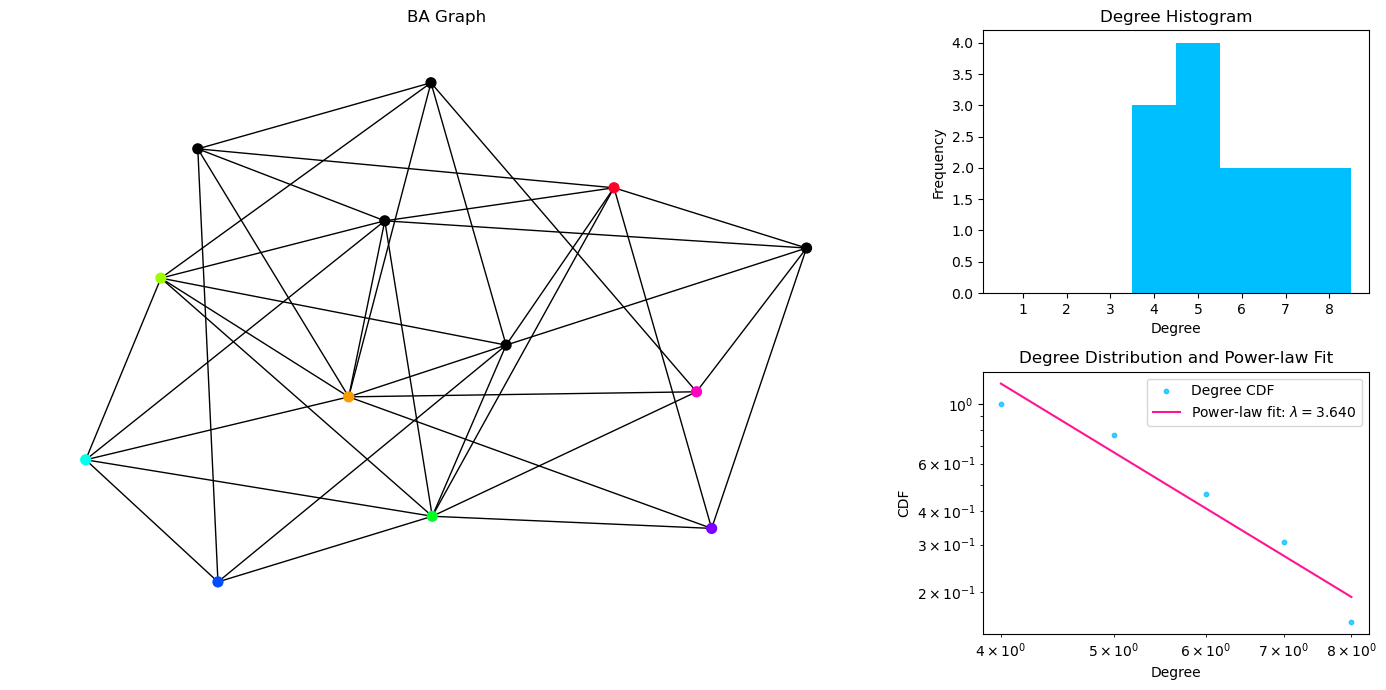

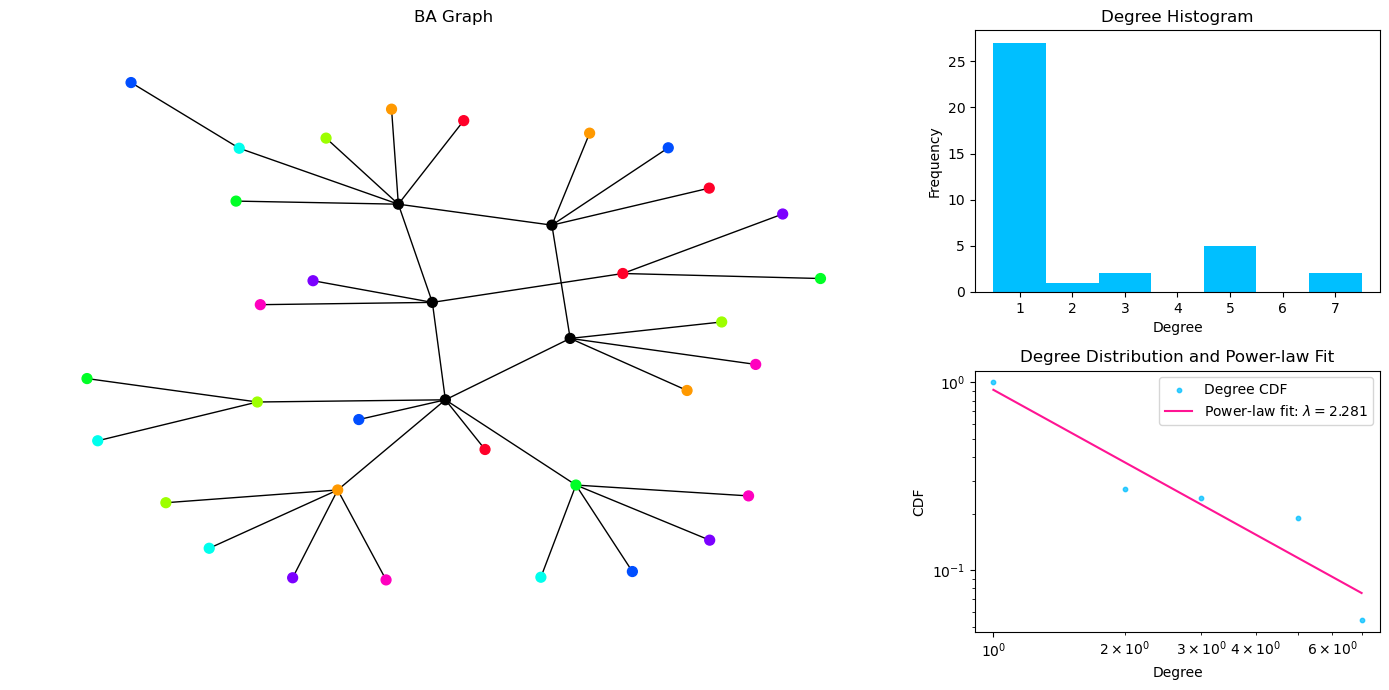

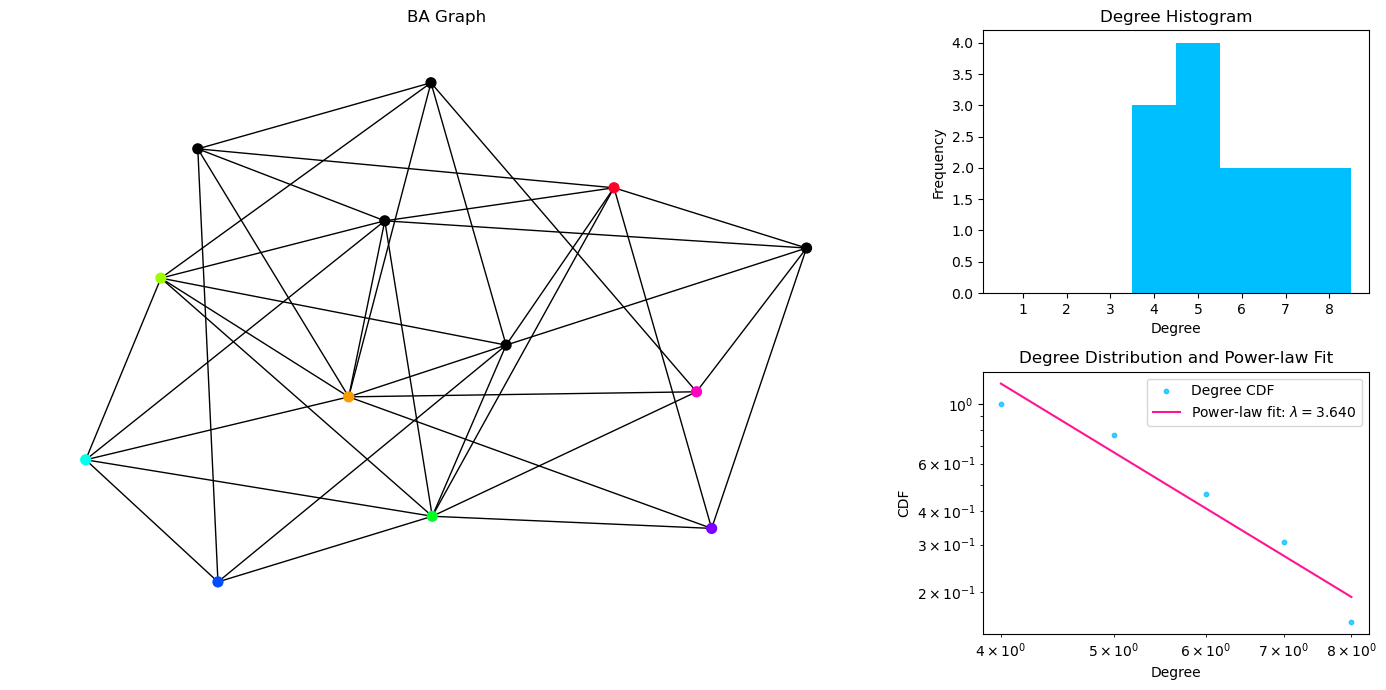

({0: array([1.      , 0.272068]),
  1: array([ 0.20151233, -0.02335099]),
  2: array([0.00180017, 0.77526937]),
  3: array([-0.61794889,  0.57406294]),
  4: array([-0.12094779,  0.35493461]),
  5: array([0.4882556 , 0.45552904]),
  6: array([-0.21683864, -0.18091449]),
  7: array([-0.71605124,  0.18050097]),
  8: array([ 0.00521162, -0.54441361]),
  9: array([-0.91592688, -0.37254909]),
  10: array([-0.56439013, -0.74430821]),
  11: array([ 0.7477607 , -0.58134326]),
  12: array([ 0.70756315, -0.1654853 ])},
 10)

In [ ]:
N0 = 5
N = 13
M = 4

colors = ['#000000'] + generate_colors(N - N0, 2)

g1 = generate_gm_n(N0, N, M, colors)
g2 = unfold_gm_n_to_g1_nm(g1, N0, N, M)
g3 = fold_g1_nm_to_gm_n(g2, N0, N, M)

draw_graph(g1)
draw_graph(g2)
draw_graph(g3)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


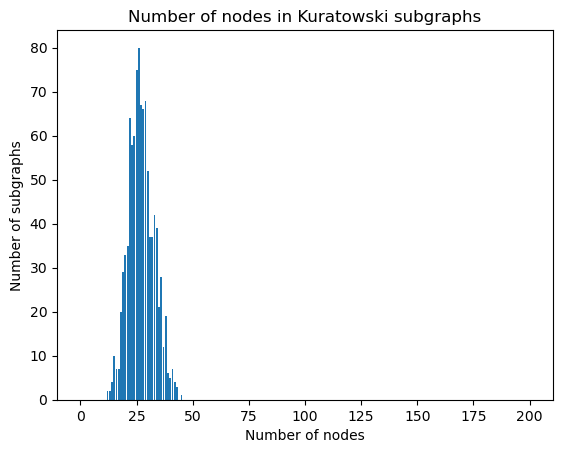

In [ ]:
# create BA graph and create histogram of number of nodes in each kuratowski subgraph as result from planarity check

N0 = 5
N = 200
M = 4
TRIES = 1000

nodes_number = {}
for n in range(0, N+1, 1):
    nodes_number[n] = 0

for _ in range(TRIES):
    if _ % 50 == 0:
        print(_)
    graph = generate_graph(N0, N, M)
    is_planar = False
    while not is_planar:
        is_planar, subgraph = nx.check_planarity(graph, True)
        if not is_planar:
            nodes_number[subgraph.number_of_nodes()] += 1

            # get edge from subgraph and remove it from graph
            # edge = list(subgraph.edges())[0]
            # graph.remove_edge(*edge)
            break

plt.bar(nodes_number.keys(), nodes_number.values())
plt.xlabel('Number of nodes')
plt.ylabel('Number of subgraphs')
plt.title('Number of nodes in Kuratowski subgraphs')
plt.show()


In [ ]:
pickle.dump(nodes_number, open('calculation-cache/kuratowski-subgraphs-n200.pkl', 'wb'))

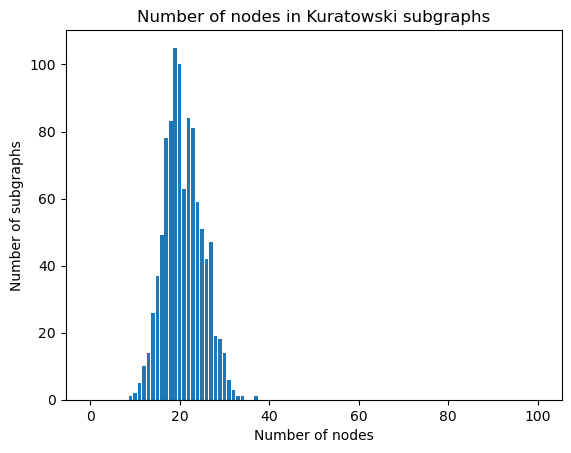

In [ ]:
nodes_number = pickle.load(open('calculation-cache/kuratowski-subgraphs-n100.pkl', 'rb'))
plt.bar(nodes_number.keys(), nodes_number.values())
plt.xlabel('Number of nodes')
plt.ylabel('Number of subgraphs')
plt.title('Number of nodes in Kuratowski subgraphs')
plt.show()

# nodes_number = pickle.load(open('calculation-cache/kuratowski-subgraphs-n200.pkl', 'rb'))
# plt.bar(nodes_number.keys(), nodes_number.values())
# plt.xlabel('Number of nodes')
# plt.ylabel('Number of subgraphs')
# plt.title('Number of nodes in Kuratowski subgraphs')
# plt.show()

with open('subdivisions.txt', 'w') as f:
    f.write('k s\n')
    for n, count in nodes_number.items():
        f.write(f'{n} {count / 1000}\n')

In [ ]:
from sympy import factorial, exp, log, harmonic
import random

def ExpK5Single(n, m, k):
    """
    Calculate the value of ExpK5Single based on the given parameters.
    
    Parameters:
    n : int or float
        Input parameter n.
    m : int or float
        Input parameter m.
    k : int or float
        Input parameter k.

    Returns:
    result : float
        The result of the computation.
    """
    # Expression components
    term1 = k**9 / factorial(k)
    term2 = (m / 2)**(k + 5) + (m / 2)**((2 * k + 20) / 3)
    term3 = exp(k**3 * log(m * n) / (m * n * 100))
    term4 = harmonic(n, 2)**5
    term5 = log(n)**(k - 5)
    
    # Full expression
    result = term1 * term2 * term3 * term4 * term5

    if k > 50:
        return 5.066165664063493e-15 * random.random()
    
    return result

def ExpK33Single(n, m, k):
    """
    Calculate the value of ExpK33Single based on the given parameters.
    
    Parameters:
    n : int or float
        Input parameter n.
    m : int or float
        Input parameter m.
    k : int or float
        Input parameter k.

    Returns:
    result : float
        The result of the computation.
    """
    # Expression components
    term1 = k**8 / factorial(k)
    term2 = (m / 2)**(k + 3) + (m / 2)**((2 * k + 15) / 3)
    term3 = exp(k**3 * log(m * n) / (m * n * 150))
    term4 = harmonic(n, 3/2)**6
    term5 = log(n)**(k - 6)
    
    # Full expression
    result = term1 * term2 * term3 * term4 * term5

    if k > 50:
        return 5.066165664063493e-15 * random.random()
    
    return result

# n_value = 100  # Example value for n
# m_value = 4   # Example value for m

# ks = []
# ss = []
# for k in range(0, n_value + 1):
#     ks.append(k)
#     ss.append(ExpK5Single(n_value, m_value, k) / 5) 

# plt.plot(ks, ss)
# plt.xlabel('k')
# plt.ylabel('ExpK5Single')
# plt.title('ExpK5Single for n=50, m=4')
# plt.show()

# with open('exp-subdivisions.txt', 'w') as f:
#     f.write('k s\n')
#     for k, s in zip(ks, ss):
#         f.write(f'{k} {float(s)}\n')

data = {}
for m in [2, 3, 4, 5]:
    data[m] = {}
    print(f'm = {m}')
    ns = []
    ts = []
    for n in range(10, 461, 25):
        print(f'n = {n}')
        total = 0
        for k in range(5, n+1, 1):
            total += ExpK33Single(n, m, k)
        
        ns.append(n)
        ts.append(total)

    data[m] = (ns, ts)

m = 2
n = 10
n = 35
n = 60
n = 85
n = 110
n = 135
n = 160
n = 185
n = 210
n = 235
n = 260
n = 285
n = 310
n = 335
n = 360
n = 385
n = 410
n = 435
n = 460
m = 3
n = 10
n = 35
n = 60
n = 85
n = 110
n = 135
n = 160
n = 185
n = 210
n = 235
n = 260
n = 285
n = 310
n = 335
n = 360
n = 385
n = 410
n = 435
n = 460
m = 4
n = 10
n = 35
n = 60
n = 85
n = 110
n = 135
n = 160
n = 185
n = 210
n = 235
n = 260
n = 285
n = 310
n = 335
n = 360
n = 385
n = 410
n = 435
n = 460
m = 5
n = 10
n = 35
n = 60
n = 85
n = 110
n = 135
n = 160
n = 185
n = 210
n = 235
n = 260
n = 285
n = 310
n = 335
n = 360
n = 385
n = 410
n = 435
n = 460


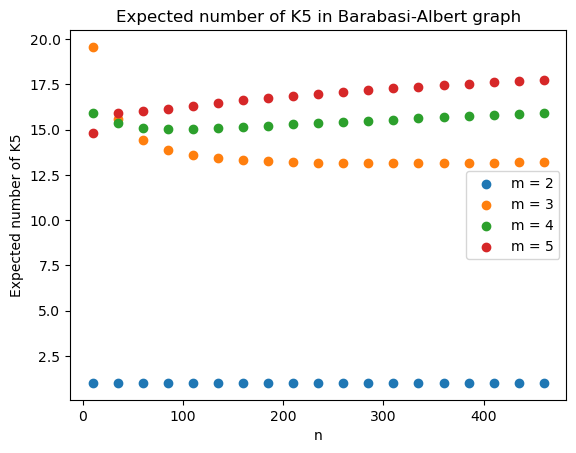

In [ ]:
def logm(m, n):
    if m == 1:
        return 1
    return math.log(n) / math.log(m)

def harmonic_number(m, n):
    s = 0
    for i in range(1, n+1):
        s += 1 / i**m
    return s


for m in [2, 3, 4, 5]:
    ns, ts = data[m]
    plt.scatter(ns, [logm(m/2, t / (harmonic_number(3/2, n)**6) / math.log(n)**8) for t,n in zip(ts,ns)], label=f'm = {m}')
    # plt.plot(ns, [t / ((m**20) * (math.log(n))) for n,t in zip(ns,ts)], label=f'm = {m}')

plt.xlabel('n')
plt.ylabel('Expected number of K5')
plt.title("Expected number of K5 in Barabasi-Albert graph")
plt.legend()    
plt.show()

# data1 = {}
# for m in [2, 3, 4, 5]:
#     ns, ts = data[m]
#     data1[m] = (ns, [math.log(t) for t in ts])

# with open('exp-k33-subdivisions.txt', 'w') as f:
#     f.write('n ')
#     for m in [2, 3, 4, 5]:
#         f.write(f'm{m} ')
#     f.write('\n')

#     ns, _ = data1[2]
#     for i, n in enumerate(ns):
#         f.write(f'{n} ')
#         for m in [2, 3, 4, 5]:
#             f.write(f'{data1[m][1][i]} ')
#         f.write('\n')